# SC Cosmetics 
## Enhancing Consumer Safety in Cosmetics: Designing a Data Pipeline and Classification Model for SC Cosmetics 

### Import Libaries

In [164]:
!pip install -q --upgrade pip
!pip install -q pyathena
!pip install -q imbalanced-learn
!pip install -q smclarify==0.1
!pip install -q --upgrade statsmodels
!pip install -q --upgrade threadpoolctl
!pip install -q --upgrade s3fs

import boto3
import sagemaker
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pyathena import connect
from imblearn.over_sampling import SMOTE

from smclarify.bias import report
from typing import Dict
from collections import defaultdict

from sklearn.feature_selection import chi2
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score

from sklearn.model_selection import train_test_split

from sqlalchemy import create_engine

%matplotlib inline
%config InlineBackend.figure_format='retina'

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.12.3 requires botocore<1.34.70,>=1.34.41, but you have botocore 1.33.13 which is incompatible.
awscli 1.31.9 requires

### Copy Data from S3

Link to S3 bucket:
https://us-east-1.console.aws.amazon.com/s3/buckets/sc-cosmetics?region=us-east-1&bucketType=general&tab=objects

Link to download Chemicals in Cosmetics dataframe from S3 bucket: 
https://sc-cosmetics.s3.amazonaws.com/chemicals-in-cosmetics/cosmetic_chemicals.csv

Link to download Cosmetics dataframe from S3 bucket:
https://sc-cosmetics.s3.amazonaws.com/cosmetic-ingedients-ranking-pricing/cosmetics.csv

Link to download Customer Propensity dataframe from S3 bucket:
https://sc-cosmetics.s3.amazonaws.com/customer-propensity-to-purchase/customer.csv

In [165]:
# define the S3 bucket, role, and region
sess = sagemaker.Session()
bucket = "sc-cosmetics"  
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

# define S3 paths for the source (public) and destination (private) locations
s3_public_path_chemicals = "s3://sc-cosmetics/chemicals-in-cosmetics"
s3_public_path_cosmetics = "s3://sc-cosmetics/cosmetic-ingredients-ranking-pricing"
s3_public_path_customer = "s3://sc-cosmetics/customer-propensity-to-purchase"
s3_private_path = f"s3://{bucket}/"  
s3_private_path_chemicals = f"s3://{bucket}/chemicals-in-cosmetics"
s3_private_path_cosmetics = f"s3://{bucket}/cosmetic-ingredients-ranking-pricing"
s3_private_path_customer = f"s3://{bucket}/customer-propensity-to-purchase"

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [166]:
# copy data from the public S3 buckets to our private S3 buckets
!aws s3 cp --recursive $s3_public_path_chemicals/ $s3_private_path_chemicals/
!aws s3 cp --recursive $s3_public_path_cosmetics/ $s3_private_path_cosmetics/
!aws s3 cp --recursive $s3_public_path_customer/ $s3_private_path_customer/

copy: s3://sc-cosmetics/chemicals-in-cosmetics/cosmetic_chemicals.csv to s3://sc-cosmetics/chemicals-in-cosmetics/cosmetic_chemicals.csv
copy: s3://sc-cosmetics/cosmetic-ingredients-ranking-pricing/cosmetics.csv to s3://sc-cosmetics/cosmetic-ingredients-ranking-pricing/cosmetics.csv
copy: s3://sc-cosmetics/customer-propensity-to-purchase/customer.csv to s3://sc-cosmetics/customer-propensity-to-purchase/customer.csv


In [167]:
# list files in private S3 bucket
print("Files in private S3 bucket - Chemicals:")
!aws s3 ls $s3_private_path_chemicals/

print("\nFiles in private S3 bucket - Cosmetics:")
!aws s3 ls $s3_private_path_cosmetics/

print("\nFiles in private S3 bucket - Customer:")
!aws s3 ls $s3_private_path_customer/

Files in private S3 bucket - Chemicals:
2024-04-14 21:44:30   24067011 cosmetic_chemicals.csv

Files in private S3 bucket - Cosmetics:
2024-04-14 21:44:32    1157561 cosmetics.csv

Files in private S3 bucket - Customer:
2024-04-14 21:44:33   35077618 customer.csv


In [168]:
# read files into pd df
chemicals_df = pd.read_csv(s3_private_path_chemicals + "/cosmetic_chemicals.csv")
cosmetics_df = pd.read_csv(s3_private_path_cosmetics + "/cosmetics.csv")
customer_df = pd.read_csv(s3_private_path_customer + "/customer.csv")

### Data Exploration

In [169]:
pd.set_option('display.max_columns', None)

In [170]:
chemicals_df.head()

,ProductName,CompanyId,CompanyName,BrandName,PrimaryCategoryId,PrimaryCategory,SubCategoryId,SubCategory,ChemicalId,ChemicalName,InitialDateReported,MostRecentDateReported,ChemicalCreatedAt,ChemicalUpdatedAt,ChemicalCount,Discontinued,ChemicalRemoved,brand_id
0,ULTRA COLOR RICH EXTRA PLUMP LIPSTICK-ALL SHADES,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),53,Lip Color - Lipsticks Liners and Pencils,6,Titanium dioxide,2009-06-17,2013-08-28,2009-07-09,2009-07-09,1,1,0,70.0
1,Glover's Medicated Shampoo,338,J. Strickland & Co.,Glover's,18,Hair Care Products (non-coloring),25,Hair Shampoos (making a cosmetic claim),4,Distillates (coal tar),2009-07-01,2009-07-01,2009-07-01,2009-07-01,2,0,0,960.0
2,Glover's Medicated Shampoo,338,J. Strickland & Co.,Glover's,18,Hair Care Products (non-coloring),25,Hair Shampoos (making a cosmetic claim),5,Estragole,2009-07-01,2009-07-01,2009-07-02,2009-07-02,2,0,0,960.0
3,PRECISION GLIMMER EYE LINER-ALL SHADES �,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),46,Eyeliner/Eyebrow Pencils,7,Titanium dioxide,2009-07-09,2013-08-28,2009-07-09,2009-07-09,1,0,0,70.0
4,AVON BRILLIANT SHINE LIP GLOSS-ALL SHADES �,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),52,Lip Gloss/Shine,8,Titanium dioxide,2009-07-09,2013-08-28,2009-07-09,2009-07-09,1,1,0,70.0


In [171]:
chemicals_df['PrimaryCategory'].value_counts() 

Makeup Products (non-permanent)      75827
Nail Products                        15347
Skin Care Products                    7683
Sun-Related Products                  4939
Bath Products                         3466
Hair Coloring Products                2061
Hair Care Products (non-coloring)     1620
Tattoos and Permanent Makeup          1477
Personal Care Products                 765
Fragrances                             654
Oral Hygiene Products                  525
Shaving Products                       222
Baby Products                           49
Name: PrimaryCategory, dtype: int64

In [172]:
cosmetics_df['Label'].value_counts()

Moisturizer    298
Cleanser       281
Face Mask      266
Treatment      248
Eye cream      209
Sun protect    170
Name: Label, dtype: int64

In [173]:
customer_df.head()

,UserID,basket_icon_click,basket_add_list,basket_add_detail,sort_by,account_page_click,detail_wishlist_add,list_size_dropdown,closed_minibasket_click,checked_delivery_detail,checked_returns_detail,sign_in,saw_checkout,saw_delivery,saw_homepage,device_mobile,device_computer,device_tablet,returning_user,loc_uk,ordered,product_id
0,a720-6b732349-a720-4862-bd21-644732,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,NaN
1,a0c0-6b73247c-a0c0-4bd9-8baa-797356,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,NaN
2,86a8-6b735c67-86a8-407b-ba24-333055,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,NaN
3,6a3d-6b736346-6a3d-4085-934b-396834,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,NaN
4,b74a-6b737717-b74a-45c3-8c6a-421140,0,1,0,1,0,0,1,0,1,0,1,1,0,1,0,0,1,0,1,1,321.0


Since the cosmetics dataframe exclusively comprises skincare items, our analysis will focus solely on skincare products and those associated with sun protection from the chemicals present in the cosmetic dataframe.

### Table Manipulation

#### Chemicals Table

- Converted certain columns into binary values based on the presence of NaN values.
- Dropped unneeded columns from the dataframe.
- Removed commas from the 'SubCategory' column.
- Removed leading and trailing spaces from identified columns.
- Converted date columns to the proper format.
- Added a 'brand_id' column to the dataframe based on the 'BrandName'.


#### Cosmetics Table

- Removed commas from the 'Ingredients' column.
- Created a 'product_id' column with a unique identifier for each row.

#### Customer Table

- Dropped unneeded columns from the dataframe.
- Created a new column 'product_id' to assign a random product ID to each row where 'ordered' equals 1.

#### Note 

- This code should only be run once due to operations that alter the data irreversibly or generate random values.
- Unique identifiers like 'product_id' or 'brand_id' may lead to inconsistencies if the code is run multiple times without resetting the identifiers.
- Random generation of 'product_id' for customers with 'ordered' equals 1 will generate different IDs each time the code is run, potentially leading to data duplication or inconsistency if run multiple times.

### Create Athena Database

In [174]:
# athena database name
db_name = 'sc_cosmetics'

In [175]:
# S3 staging directory
s3_staging = "s3://{0}/athena/staging".format(bucket)

In [176]:
# create connection for athena database
conn = connect(region_name=region, s3_staging_dir=s3_staging)

In [177]:
create_query = "CREATE DATABASE IF NOT EXISTS {}".format(db_name)
pd.read_sql(create_query, conn)

""


In [178]:
# create chemicals in cosmetics table
chem_table_name ='cosmetic_chemicals'

# chemical data S3 directory
chem_s3_dir = f's3://{bucket}/chemicals-in-cosmetics'

# drop table if it already exists
drop_query = f'DROP TABLE IF EXISTS {db_name}.{chem_table_name}'
pd.read_sql(drop_query, conn)

# create table
create_query = f"""
                CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.{chem_table_name}(
                ProductName string,
                CompanyID int,
                CompanyName string,
                BrandName string,
                PrimaryCategoryID int,
                PrimaryCategory string,
                SubCategoryID int,
                SubCategory string,
                ChemicalID int,
                ChemicalName string,
                InitialDateReported date,
                MostRecentDateReported date,
                ChemicalCreatedAt date,
                ChemicalUpdatedAt date,
                ChemicalCount int,
                Discontinued int,
                ChemicalRemoved int, 
                brand_id int
                )
                
                ROW FORMAT DELIMITED
                FIELDS TERMINATED BY ','
                LOCATION '{chem_s3_dir}/'
                TBLPROPERTIES ('skip.header.line.count'='1')
"""
pd.read_sql(create_query, conn)

""


In [179]:
# view top 5 rows of chemical_cosmetics table
pd.read_sql(f'SELECT * FROM {db_name}.{chem_table_name} LIMIT 5', conn)

,productname,companyid,companyname,brandname,primarycategoryid,primarycategory,subcategoryid,subcategory,chemicalid,chemicalname,initialdatereported,mostrecentdatereported,chemicalcreatedat,chemicalupdatedat,chemicalcount,discontinued,chemicalremoved,brand_id
0,ULTRA COLOR RICH EXTRA PLUMP LIPSTICK-ALL SHADES,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),53,Lip Color - Lipsticks Liners and Pencils,6,Titanium dioxide,2009-06-17,2013-08-28,2009-07-09,2009-07-09,1,1,0,70
1,Glover's Medicated Shampoo,338,J. Strickland & Co.,Glover's,18,Hair Care Products (non-coloring),25,Hair Shampoos (making a cosmetic claim),4,Distillates (coal tar),2009-07-01,2009-07-01,2009-07-01,2009-07-01,2,0,0,960
2,Glover's Medicated Shampoo,338,J. Strickland & Co.,Glover's,18,Hair Care Products (non-coloring),25,Hair Shampoos (making a cosmetic claim),5,Estragole,2009-07-01,2009-07-01,2009-07-02,2009-07-02,2,0,0,960
3,PRECISION GLIMMER EYE LINER-ALL SHADES �,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),46,Eyeliner/Eyebrow Pencils,7,Titanium dioxide,2009-07-09,2013-08-28,2009-07-09,2009-07-09,1,0,0,70
4,AVON BRILLIANT SHINE LIP GLOSS-ALL SHADES �,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),52,Lip Gloss/Shine,8,Titanium dioxide,2009-07-09,2013-08-28,2009-07-09,2009-07-09,1,1,0,70


In [180]:
# create subquery with the skin care products and sun-related products 
skinproducts_sub = ["Sun-Related Products", "Skin Care Products"]
in_clause = "', '".join(skinproducts_sub)

sub_query = f"""
            (
            SELECT *
            FROM sc_cosmetics.cosmetic_chemicals
            WHERE PrimaryCategory IN ('{in_clause}')
            )
"""

# create a new table using the subquery
cosmetic_chemical_sub = f"""
                         CREATE TABLE IF NOT EXISTS {db_name}.cosmetic_chemical_sub AS {sub_query}
                         """

# execute the create table query
with conn.cursor() as cursor:
    cursor.execute(cosmetic_chemical_sub)

In [181]:
# view top 5 rows of cosmetic_chemical_sub table
pd.read_sql(f'SELECT * FROM {db_name}.cosmetic_chemical_sub LIMIT 5', conn)

,productname,companyid,companyname,brandname,primarycategoryid,primarycategory,subcategoryid,subcategory,chemicalid,chemicalname,initialdatereported,mostrecentdatereported,chemicalcreatedat,chemicalupdatedat,chemicalcount,discontinued,chemicalremoved,brand_id
0,Nu Colour Tinted Moisturizer Broad Spectrum SP...,248,NSE Products Inc.,Nu Skin,106,Sun-Related Products,107,Sunscreen (making a cosmetic claim),10012,Titanium dioxide,2009-10-20,2013-12-27,2009-10-20,2013-09-17,2,0,1,1590
1,Nu Colour Tinted Moisturizer Broad Spectrum SP...,248,NSE Products Inc.,Nu Skin,106,Sun-Related Products,107,Sunscreen (making a cosmetic claim),33293,Retinyl palmitate,2009-10-20,2013-12-27,2013-12-27,2013-12-27,2,0,0,1590
2,Nature's Gate Organics Advanced Care Natural R...,1232,LEVLAD LLC,Nature's Gate,90,Skin Care Products,91,Acne Products (making a cosmetic claim),10013,Methyleugenol,2009-10-20,2019-07-18,2009-10-20,2009-10-20,1,1,0,1546
3,Nature's Gate Organics Advanced Care Natural R...,1232,LEVLAD LLC,Nature's Gate,90,Skin Care Products,93,Skin Cleansers,10013,Methyleugenol,2009-10-20,2019-07-18,2009-10-20,2009-10-20,1,1,0,1546
4,DDF Wrinkle Resist Plus Pore Minimizer Moistur...,86,The Procter & Gamble Company,DDF,90,Skin Care Products,102,Skin Moisturizers (making a cosmetic claim),10018,Titanium dioxide,2009-10-21,2017-05-11,2009-10-21,2009-10-21,1,1,0,651


In [182]:
# create cosmetics table
cos_table_name ='cosmetics'

# cosmetics data S3 directory
cos_s3_dir = f's3://{bucket}/cosmetic-ingredients-ranking-pricing'

# drop table if it already exists
drop_query = f'DROP TABLE IF EXISTS {db_name}.{cos_table_name}'
pd.read_sql(drop_query, conn)

# create table
create_query = f"""
                CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.{cos_table_name}(
                Label string,
                Brand string,
                Name string,
                Price float,
                Rank float,
                Ingredients string,
                Combination int,
                Dry int,
                Normal int,
                Oily int,
                Sensitive int,
                product_id int, 
                brand_id int
                )
                
                ROW FORMAT DELIMITED
                FIELDS TERMINATED BY ','
                LOCATION '{cos_s3_dir}/'
                TBLPROPERTIES ('skip.header.line.count'='1')
"""
pd.read_sql(create_query, conn)

""


In [183]:
# view top 5 rows of cosmetics table
pd.read_sql(f'SELECT * FROM {db_name}.{cos_table_name} LIMIT 5', conn)

,label,brand,name,price,rank,ingredients,combination,dry,normal,oily,sensitive,product_id,brand_id
0,Moisturizer,LA MER,Crème de la Mer,175.0,4.1,Algae (Seaweed) Extract- Mineral Oil- Petrolat...,1,1,1,1,1,64,1
1,Moisturizer,SK-II,Facial Treatment Essence,179.0,4.1,Galactomyces Ferment Filtrate (Pitera)- Butyle...,1,1,1,1,1,95,2
2,Moisturizer,DRUNK ELEPHANT,Protini™ Polypeptide Cream,68.0,4.4,Water- Dicaprylyl Carbonate- Glycerin- Ceteary...,1,1,1,1,0,29,3
3,Moisturizer,LA MER,The Moisturizing Soft Cream,175.0,3.8,Algae (Seaweed) Extract- Cyclopentasiloxane- P...,1,1,1,1,1,64,4
4,Moisturizer,IT COSMETICS,Your Skin But Better™ CC+™ Cream with SPF 50+,38.0,4.1,Water- Snail Secretion Filtrate- Phenyl Trimet...,1,1,1,1,1,49,5


In [184]:
# create customer table
cust_table_name ='customer'

# customer data S3 directory
cust_s3_dir = f's3://{bucket}/customer-propensity-to-purchase'

# drop table if it already exists
drop_query = f'DROP TABLE IF EXISTS {db_name}.{cust_table_name}'
pd.read_sql(drop_query, conn)

# create table
create_query = f"""
                CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.{cust_table_name}(
                UserID string,
                basket_icon_click int,
                basket_add_list int,
                basket_add_detail int,
                sort_by int,
                account_page_click int,
                detail_wishlist_add int,
                list_size_dropdown int,
                closed_minibasket_click int,
                checked_delivery_detail int,
                checked_returns_detail int,
                sign_in int,
                saw_checkout int,
                saw_delivery int,
                saw_homepage int,
                device_mobile int,
                device_computer int,
                device_tablet int,
                returning_user int,
                loc_uk int,
                ordered int,
                product_id int
                )
                
                ROW FORMAT DELIMITED
                FIELDS TERMINATED BY ','
                LOCATION '{cust_s3_dir}/'
                TBLPROPERTIES ('skip.header.line.count'='1')
"""
pd.read_sql(create_query, conn)

""


In [185]:
# view top 5 rows of customer table
pd.read_sql(f'SELECT * FROM {db_name}.{cust_table_name} LIMIT 5', conn)

,userid,basket_icon_click,basket_add_list,basket_add_detail,sort_by,account_page_click,detail_wishlist_add,list_size_dropdown,closed_minibasket_click,checked_delivery_detail,checked_returns_detail,sign_in,saw_checkout,saw_delivery,saw_homepage,device_mobile,device_computer,device_tablet,returning_user,loc_uk,ordered,product_id
0,84d0-82c61917-84d0-41aa-a04c-607845,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,None
1,68dc-82c6b1c9-68dc-b168-8425-91412,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,None
2,8786-82c1eb1b-8786-411b-bd14-548509,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,None
3,1a2b-82c6b429-1a2b-4c1d-b019-845548,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,None
4,c752-82c6b546-c752-47a3-a5bd-104606,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,None


In [186]:
statement = "SHOW DATABASES"
df_show = pd.read_sql(statement, conn)
df_show.head(5)

,database_name
0,default
1,dsoaws
2,sagemaker_featurestore
3,sc_cosmetics


In [187]:
# define query to show tables in db
show_tables_query = f"SHOW TABLES IN {db_name}"

# execute query+ display tables in db
tables_df = pd.read_sql(show_tables_query, conn)
tables_df

,tab_name
0,cosmetic_chemical_sub
1,cosmetic_chemicals
2,cosmetic_chemicals_sub
3,cosmetics
4,customer


In [188]:
if db_name in df_show.values:
    ingest_create_athena_db_passed = True

In [189]:
%store ingest_create_athena_db_passed

Stored 'ingest_create_athena_db_passed' (bool)


In [190]:
# define SQL query
query = """
        SELECT cu.UserID,
               cu.basket_icon_click,
               cu.basket_add_list,
               cu.account_page_click,
               cu.detail_wishlist_add,
               cu.saw_checkout,
               cu.device_mobile,
               cu.device_computer, 
               cu.device_tablet,
               cu.returning_user,
               cu.ordered,
               c.*,
               ccc.PrimaryCategory,
               ccc.SubCategory,
               ccc.ChemicalName,
               ccc.ChemicalCount,
               ccc.Discontinued,
               ccc.ChemicalRemoved
        FROM sc_cosmetics.customer cu
        INNER JOIN sc_cosmetics.cosmetics c ON cu.product_id = c.product_id
        INNER JOIN sc_cosmetics.cosmetic_chemical_sub ccc ON c.brand_id = ccc.brand_id;
        """

In [191]:
sc_df = pd.read_sql(query, conn)

In [192]:
sc_df.sample(n=10, random_state=42)

,UserID,basket_icon_click,basket_add_list,account_page_click,detail_wishlist_add,saw_checkout,device_mobile,device_computer,device_tablet,returning_user,ordered,label,brand,name,price,rank,ingredients,combination,dry,normal,oily,sensitive,product_id,brand_id,PrimaryCategory,SubCategory,ChemicalName,ChemicalCount,Discontinued,ChemicalRemoved
28322,7d65-5687bc62-7d65-400d-9673-518802,0,0,0,0,1,0,1,0,0,1,Cleanser,YOUTH TO THE PEOPLE,Superfood Antioxidant Cleanser,36.0,4.4,Water- Sodium Cocoyl Glutamate- Cocamidopropyl...,0.0,0.0,0,0,0,114,327,Skin Care Products,Skin Moisturizers (making a cosmetic claim),Titanium dioxide,1.0,1.0,0.0
76289,c9c9-0d132171-c9c9-4d13-b89b-66529,0,0,0,0,1,1,0,0,1,1,Face Mask,DR. JART+,Shake & Shot™ Rubber Masks,12.0,4.1,-Vitamin C (Ascorbic Acid): Brightens the look...,1.0,1.0,1,1,1,28,899,Skin Care Products,Skin Moisturizers (making a cosmetic claim),Titanium dioxide,1.0,0.0,0.0
36941,99ab-b6a3avbd-99ab-4167-b3dd-908839,1,1,0,0,1,1,0,0,1,1,Eye cream,PETER THOMAS ROTH,Instant FIRMx Eye™,38.0,3.6,Water- Glycerin- Butylene Glycol- Sodium Silic...,0.0,0.0,0,0,0,87,1203,Skin Care Products,Skin Cleansers,Cocamide diethanolamine,0.0,0.0,1.0
53778,6111-3c78b014-6111-4a51-9706-689430,0,0,0,0,1,0,0,1,1,1,Eye cream,ESTÉE LAUDER,Resilience Lift Firming/Sculpting Eye Creme,65.0,3.3,Res Lift Frm/Sclp Eye Creme Division: El (Este...,0.0,0.0,0,0,0,33,1239,Skin Care Products,Skin Moisturizers (making a cosmetic claim),Titanium dioxide,1.0,0.0,0.0
73837,6759-1bbc3683-6759-47b4-9310-34796,0,0,0,0,1,0,1,0,1,1,Treatment,BOSCIA,Clear Complexion Moisturizer,36.0,3.6,Water- Butylene Glycol- Isononyl Isononanoate-...,1.0,1.0,1,1,1,13,807,Skin Care Products,Skin Cleansers,Methyleugenol,2.0,1.0,0.0
701,285b-6771e68d-285b-471e-856d-996231,0,0,0,0,1,1,0,0,0,1,Cleanser,KOH GEN DO,Cleansing Spa Water Makeup Remover,46.0,4.5,Water- Dipropylene Glycol- Peg-7 Glyceryl Coco...,0.0,0.0,0,0,0,59,403,Sun-Related Products,Sunscreen (making a cosmetic claim),Titanium dioxide,1.0,1.0,0.0
66364,cc20-25bac77c-cc20-4896-9780-362506,1,0,0,0,1,1,0,0,1,1,Moisturizer,AMOREPACIFIC,Color Control Cushion Compact Broad Spectrum S...,60.0,4.0,Phyllostachis Bambusoides Juice- Cyclopentasil...,1.0,1.0,1,1,1,1,62,Skin Care Products,Other Skin Care Product,Triethanolamine,1.0,0.0,0.0
5567,5a3d-6290b595-5a3d-41c5-9703-413484,1,1,0,0,1,1,0,0,1,1,Moisturizer,BELIF,Aqua Bomb Sleeping Mask,34.0,4.7,Water- Dipropylene Glycol- Polyglycerin-3- 1-2...,1.0,1.0,1,1,1,7,114,Skin Care Products,Skin Moisturizers (making a cosmetic claim),Retinyl acetate,2.0,0.0,0.0
61071,6970-2a7d73a6-6970-41e2-840a-962976,1,1,0,0,1,1,0,0,0,1,Sun protect,DIOR,Hydra Life BB Creme Broad Spectrum SPF 30,60.0,4.0,-Jisten (Transversal Technology): LVMH patent-...,0.0,0.0,0,0,0,24,1345,Sun-Related Products,Suntan Enhancers,Titanium dioxide,1.0,0.0,0.0
26054,7774-577672b7-7774-b17d-9d78-463952,1,1,0,0,1,0,0,1,0,1,Face Mask,SEPHORA COLLECTION,Face Mask - Coconut - Nourishing,6.0,3.5,Water- Butylene Glycol- Glycerin- Betaine- Man...,1.0,1.0,1,1,1,93,920,Sun-Related Products,Sunscreen (making a cosmetic claim),Titanium dioxide,1.0,0.0,0.0


### Exploratory Data Analysis (EDA)

In [193]:
# inspect df 
print('Number of Rows:', sc_df.shape[0])
print('Number of Columns:', sc_df.shape[1], '\n')

sc_df.info()

Number of Rows: 78393
Number of Columns: 30 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78393 entries, 0 to 78392
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   UserID               78393 non-null  object 
 1   basket_icon_click    78393 non-null  int64  
 2   basket_add_list      78393 non-null  int64  
 3   account_page_click   78393 non-null  int64  
 4   detail_wishlist_add  78393 non-null  int64  
 5   saw_checkout         78393 non-null  int64  
 6   device_mobile        78393 non-null  int64  
 7   device_computer      78393 non-null  int64  
 8   device_tablet        78393 non-null  int64  
 9   returning_user       78393 non-null  int64  
 10  ordered              78393 non-null  int64  
 11  label                78393 non-null  object 
 12  brand                78393 non-null  object 
 13  name                 78393 non-null  object 
 14  price                76688 non-null  flo

#### Identifying and Removing Null Values

In [194]:
sc_df.isnull().sum()

UserID                    0
basket_icon_click         0
basket_add_list           0
account_page_click        0
detail_wishlist_add       0
saw_checkout              0
device_mobile             0
device_computer           0
device_tablet             0
returning_user            0
ordered                   0
label                     0
brand                     0
name                      0
price                  1705
rank                    352
ingredients               0
combination            1353
dry                     352
normal                    0
oily                      0
sensitive                 0
product_id                0
brand_id                  0
PrimaryCategory           0
SubCategory               0
ChemicalName              0
ChemicalCount           830
Discontinued             30
ChemicalRemoved          30
dtype: int64

In [195]:
# calculate missing values as a percentage of total data 
missing_percentage = (sc_df.isnull().sum() / len(sc_df)) * 100 # convert to percentage 
missing_percentage = missing_percentage.sort_values(ascending=False) # place in ascending order

print('Missing Value Percentage per Column:')
print(missing_percentage)

Missing Value Percentage per Column:
price                  2.174939
combination            1.725919
ChemicalCount          1.058768
rank                   0.449020
dry                    0.449020
Discontinued           0.038269
ChemicalRemoved        0.038269
device_computer        0.000000
normal                 0.000000
basket_add_list        0.000000
account_page_click     0.000000
ChemicalName           0.000000
SubCategory            0.000000
PrimaryCategory        0.000000
brand_id               0.000000
product_id             0.000000
sensitive              0.000000
oily                   0.000000
detail_wishlist_add    0.000000
device_tablet          0.000000
saw_checkout           0.000000
ingredients            0.000000
basket_icon_click      0.000000
device_mobile          0.000000
name                   0.000000
brand                  0.000000
label                  0.000000
ordered                0.000000
returning_user         0.000000
UserID                 0.000000
dty

In [196]:
# impute values with rows missing less than 20% data using mode 
low_missing_cols = ['ChemicalCount', 'price', 'rank', 'dry','ChemicalRemoved', 'Discontinued', 'combination']
for col in low_missing_cols:
    sc_df[col] = sc_df[col].fillna(sc_df[col].mode()[0])

In [197]:
sc_df.isnull().sum() # confirm misisng values are handled

UserID                 0
basket_icon_click      0
basket_add_list        0
account_page_click     0
detail_wishlist_add    0
saw_checkout           0
device_mobile          0
device_computer        0
device_tablet          0
returning_user         0
ordered                0
label                  0
brand                  0
name                   0
price                  0
rank                   0
ingredients            0
combination            0
dry                    0
normal                 0
oily                   0
sensitive              0
product_id             0
brand_id               0
PrimaryCategory        0
SubCategory            0
ChemicalName           0
ChemicalCount          0
Discontinued           0
ChemicalRemoved        0
dtype: int64

In [198]:
sc_df.head()

,UserID,basket_icon_click,basket_add_list,account_page_click,detail_wishlist_add,saw_checkout,device_mobile,device_computer,device_tablet,returning_user,ordered,label,brand,name,price,rank,ingredients,combination,dry,normal,oily,sensitive,product_id,brand_id,PrimaryCategory,SubCategory,ChemicalName,ChemicalCount,Discontinued,ChemicalRemoved
0,a706-av7a653a-a706-46bc-b262-162924,1,0,0,0,1,1,0,0,0,1,Cleanser,L'OCCITANE,Shea Cleansing Oil,24.0,4.5,Helianthus Annuus (Sunflower) Seed Oil- Isopro...,0.0,0.0,0,0,0,63,447,Skin Care Products,Other Skin Care Product,Cocamide diethanolamine,1.0,0.0,0.0
1,9a65-avbb6b86-9a65-41e9-970c-290462,1,0,0,0,1,1,0,0,1,1,Moisturizer,FARSÁLI,Rose Gold Elixir – 24k Gold Infused Beauty Oil,54.0,4.0,Rosa Rubiginosa (Rosehip) Seed Oil- Carthamus ...,0.0,0.0,0,0,0,36,70,Skin Care Products,Facial Masks,Titanium dioxide,1.0,0.0,0.0
2,9a65-avbb6b86-9a65-41e9-970c-290462,1,0,0,0,1,1,0,0,1,1,Moisturizer,FARSÁLI,Rose Gold Elixir – 24k Gold Infused Beauty Oil,54.0,4.0,Rosa Rubiginosa (Rosehip) Seed Oil- Carthamus ...,0.0,0.0,0,0,0,36,70,Skin Care Products,Facial Cream,Titanium dioxide,1.0,0.0,0.0
3,9a65-avbb6b86-9a65-41e9-970c-290462,1,0,0,0,1,1,0,0,1,1,Moisturizer,FARSÁLI,Rose Gold Elixir – 24k Gold Infused Beauty Oil,54.0,4.0,Rosa Rubiginosa (Rosehip) Seed Oil- Carthamus ...,0.0,0.0,0,0,0,36,70,Skin Care Products,Other Skin Care Product,Titanium dioxide,1.0,0.0,0.0
4,9a65-avbb6b86-9a65-41e9-970c-290462,1,0,0,0,1,1,0,0,1,1,Moisturizer,FARSÁLI,Rose Gold Elixir – 24k Gold Infused Beauty Oil,54.0,4.0,Rosa Rubiginosa (Rosehip) Seed Oil- Carthamus ...,0.0,0.0,0,0,0,36,70,Sun-Related Products,Indoor Tanning Products,Titanium dioxide,1.0,0.0,0.0


In [199]:
sc_df['ChemicalName'].value_counts() # chemicals present in cosmetics 

Titanium dioxide                                     59198
Vitamin A palmitate                                   4015
Triethanolamine                                       3153
Butylated hydroxyanisole                              1774
Retinyl palmitate                                     1310
Retinol                                                869
Cocamide diethanolamine                                705
Methyleugenol                                          672
Benzophenone                                           657
Trade Secret                                           625
Coffea arabica extract                                 595
Ginkgo biloba extract                                  459
Mica                                                   368
"Titanium dioxide (airborne                            350
"Silica                                                325
Coffee                                                 321
Caffeine                                               3

In [200]:
sc_df.shape #30 columns and 53325 rows of data 

(78393, 30)

### Visualizations 

#### Histograms

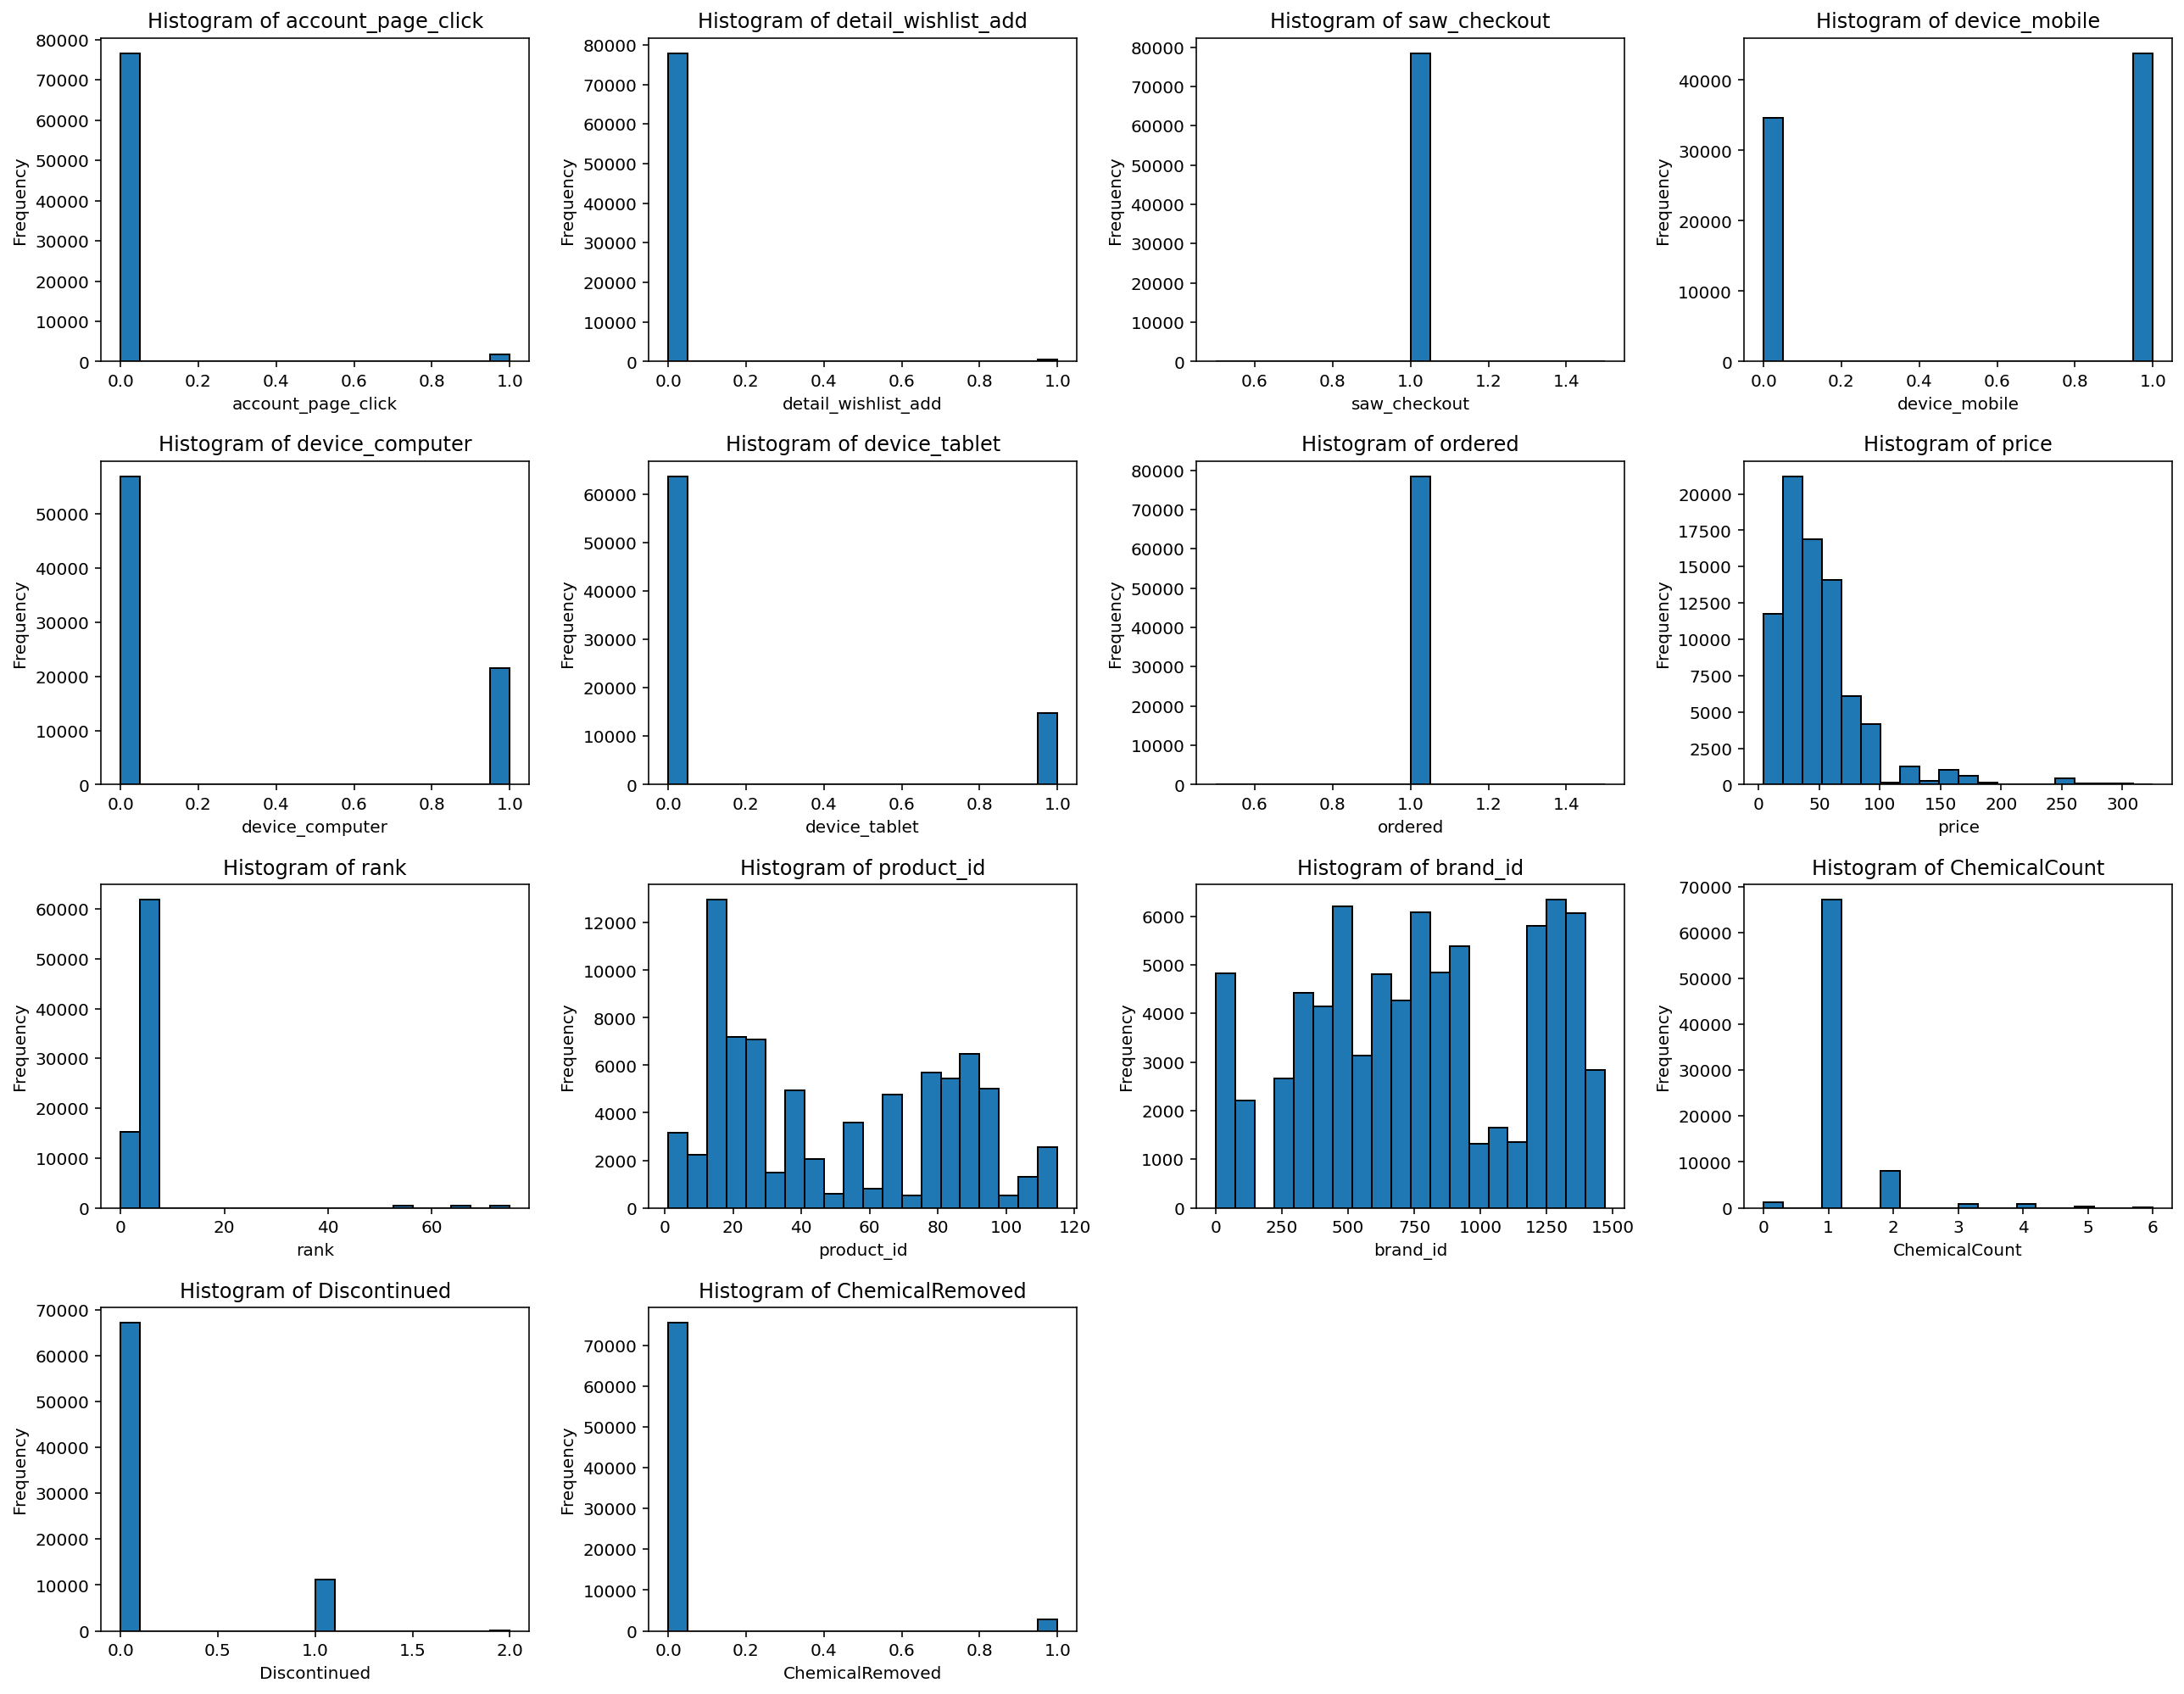

In [201]:
# list numerical predictors for histograms
predictors = [
    'account_page_click', 'detail_wishlist_add', 'saw_checkout', 'device_mobile', 
    'device_computer', 'device_tablet', 'ordered', 'price', 'rank', 'product_id', 
    'brand_id', 'ChemicalCount', 'Discontinued', 'ChemicalRemoved'
]

# create figure
num_cols = 4
num_rows = (len(predictors) - 1) // num_cols + 1
plt.figure(figsize=(18, 14))  

# create histograms 
for i, predictor in enumerate(predictors):
    plt.subplot(num_rows, num_cols, i + 1)  
    plt.hist(sc_df[predictor], bins=20, edgecolor='black')
    plt.title(f'Histogram of {predictor}')
    plt.xlabel(predictor)
    plt.ylabel('Frequency')

plt.tight_layout()  
plt.show()

#### Box Plots

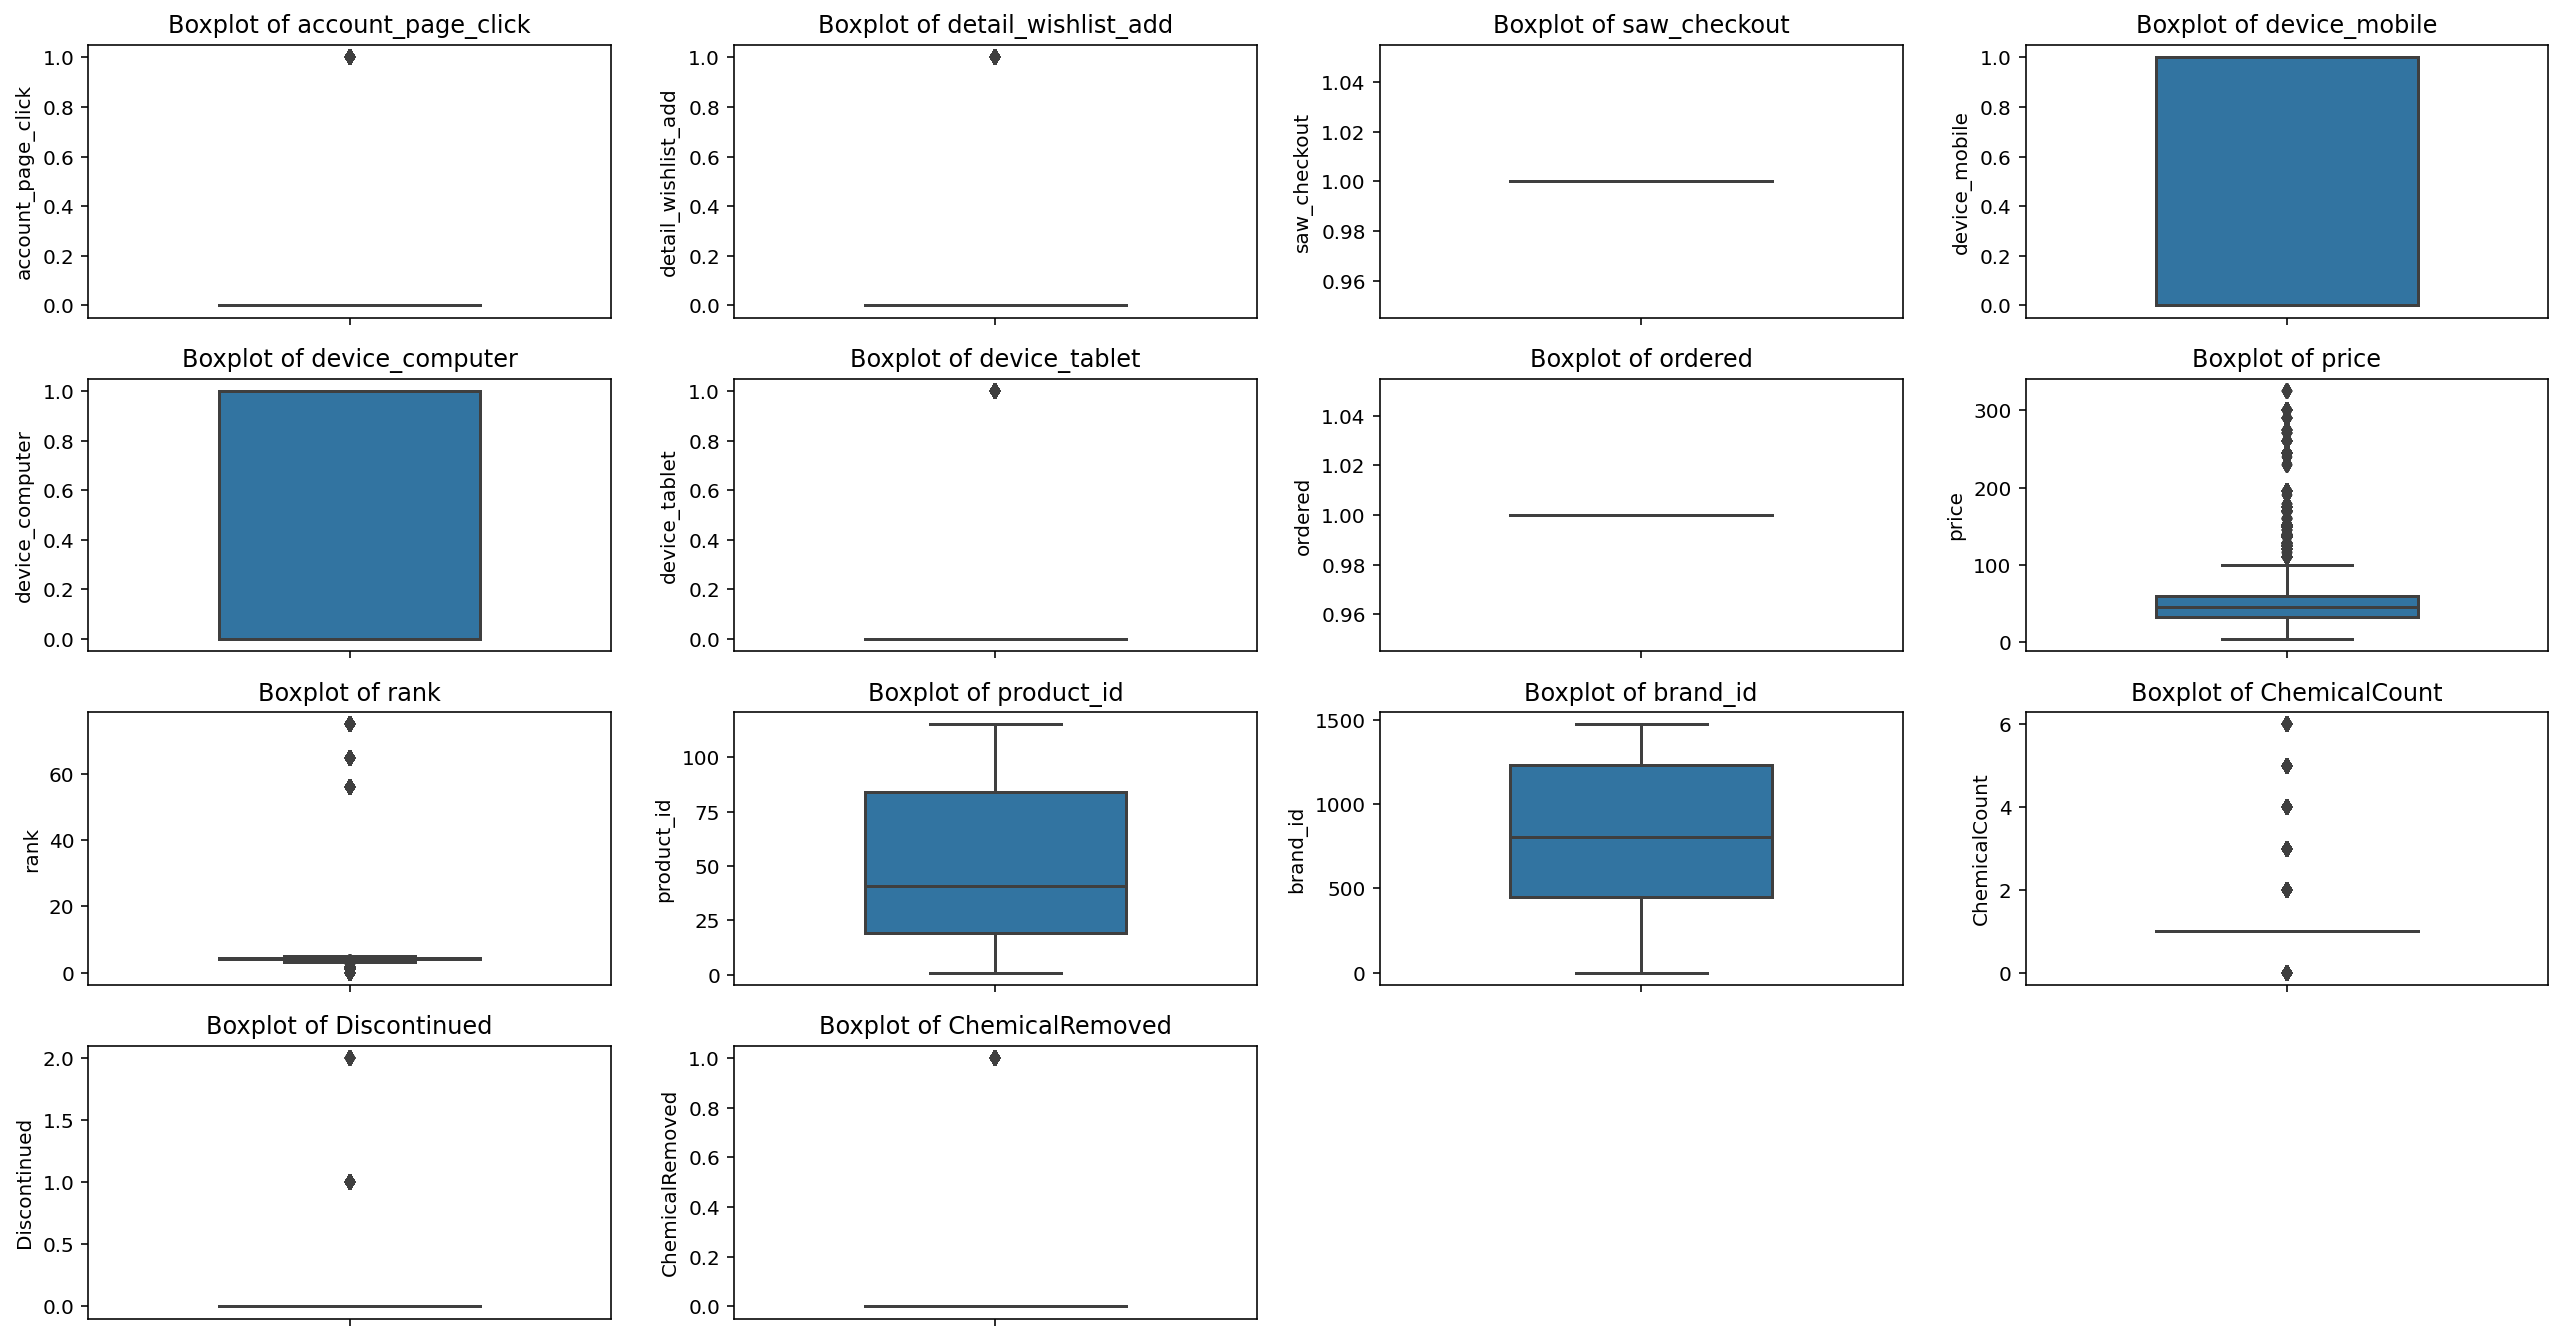

In [202]:
# list numerical predictors to create boxplots 
predictors = numerical_predictors = [
    'account_page_click','detail_wishlist_add', 'saw_checkout', 'device_mobile', 
    'device_computer', 'device_tablet', 'ordered', 'price', 'rank', 'product_id', 
    'brand_id', 'ChemicalCount', 'Discontinued', 'ChemicalRemoved'
]

# create figure for boxplots subplots 
plt.figure(figsize=(18, 14))  

# create boxplots for each predictor
for i, predictor in enumerate(predictors):
    plt.subplot(6, 4, i + 1)  
    sns.boxplot(data=sc_df, y=predictor, width=0.5)
    plt.title(f'Boxplot of {predictor}')
    plt.ylabel(predictor)

plt.tight_layout()  
plt.show()

#### Bar Plots 

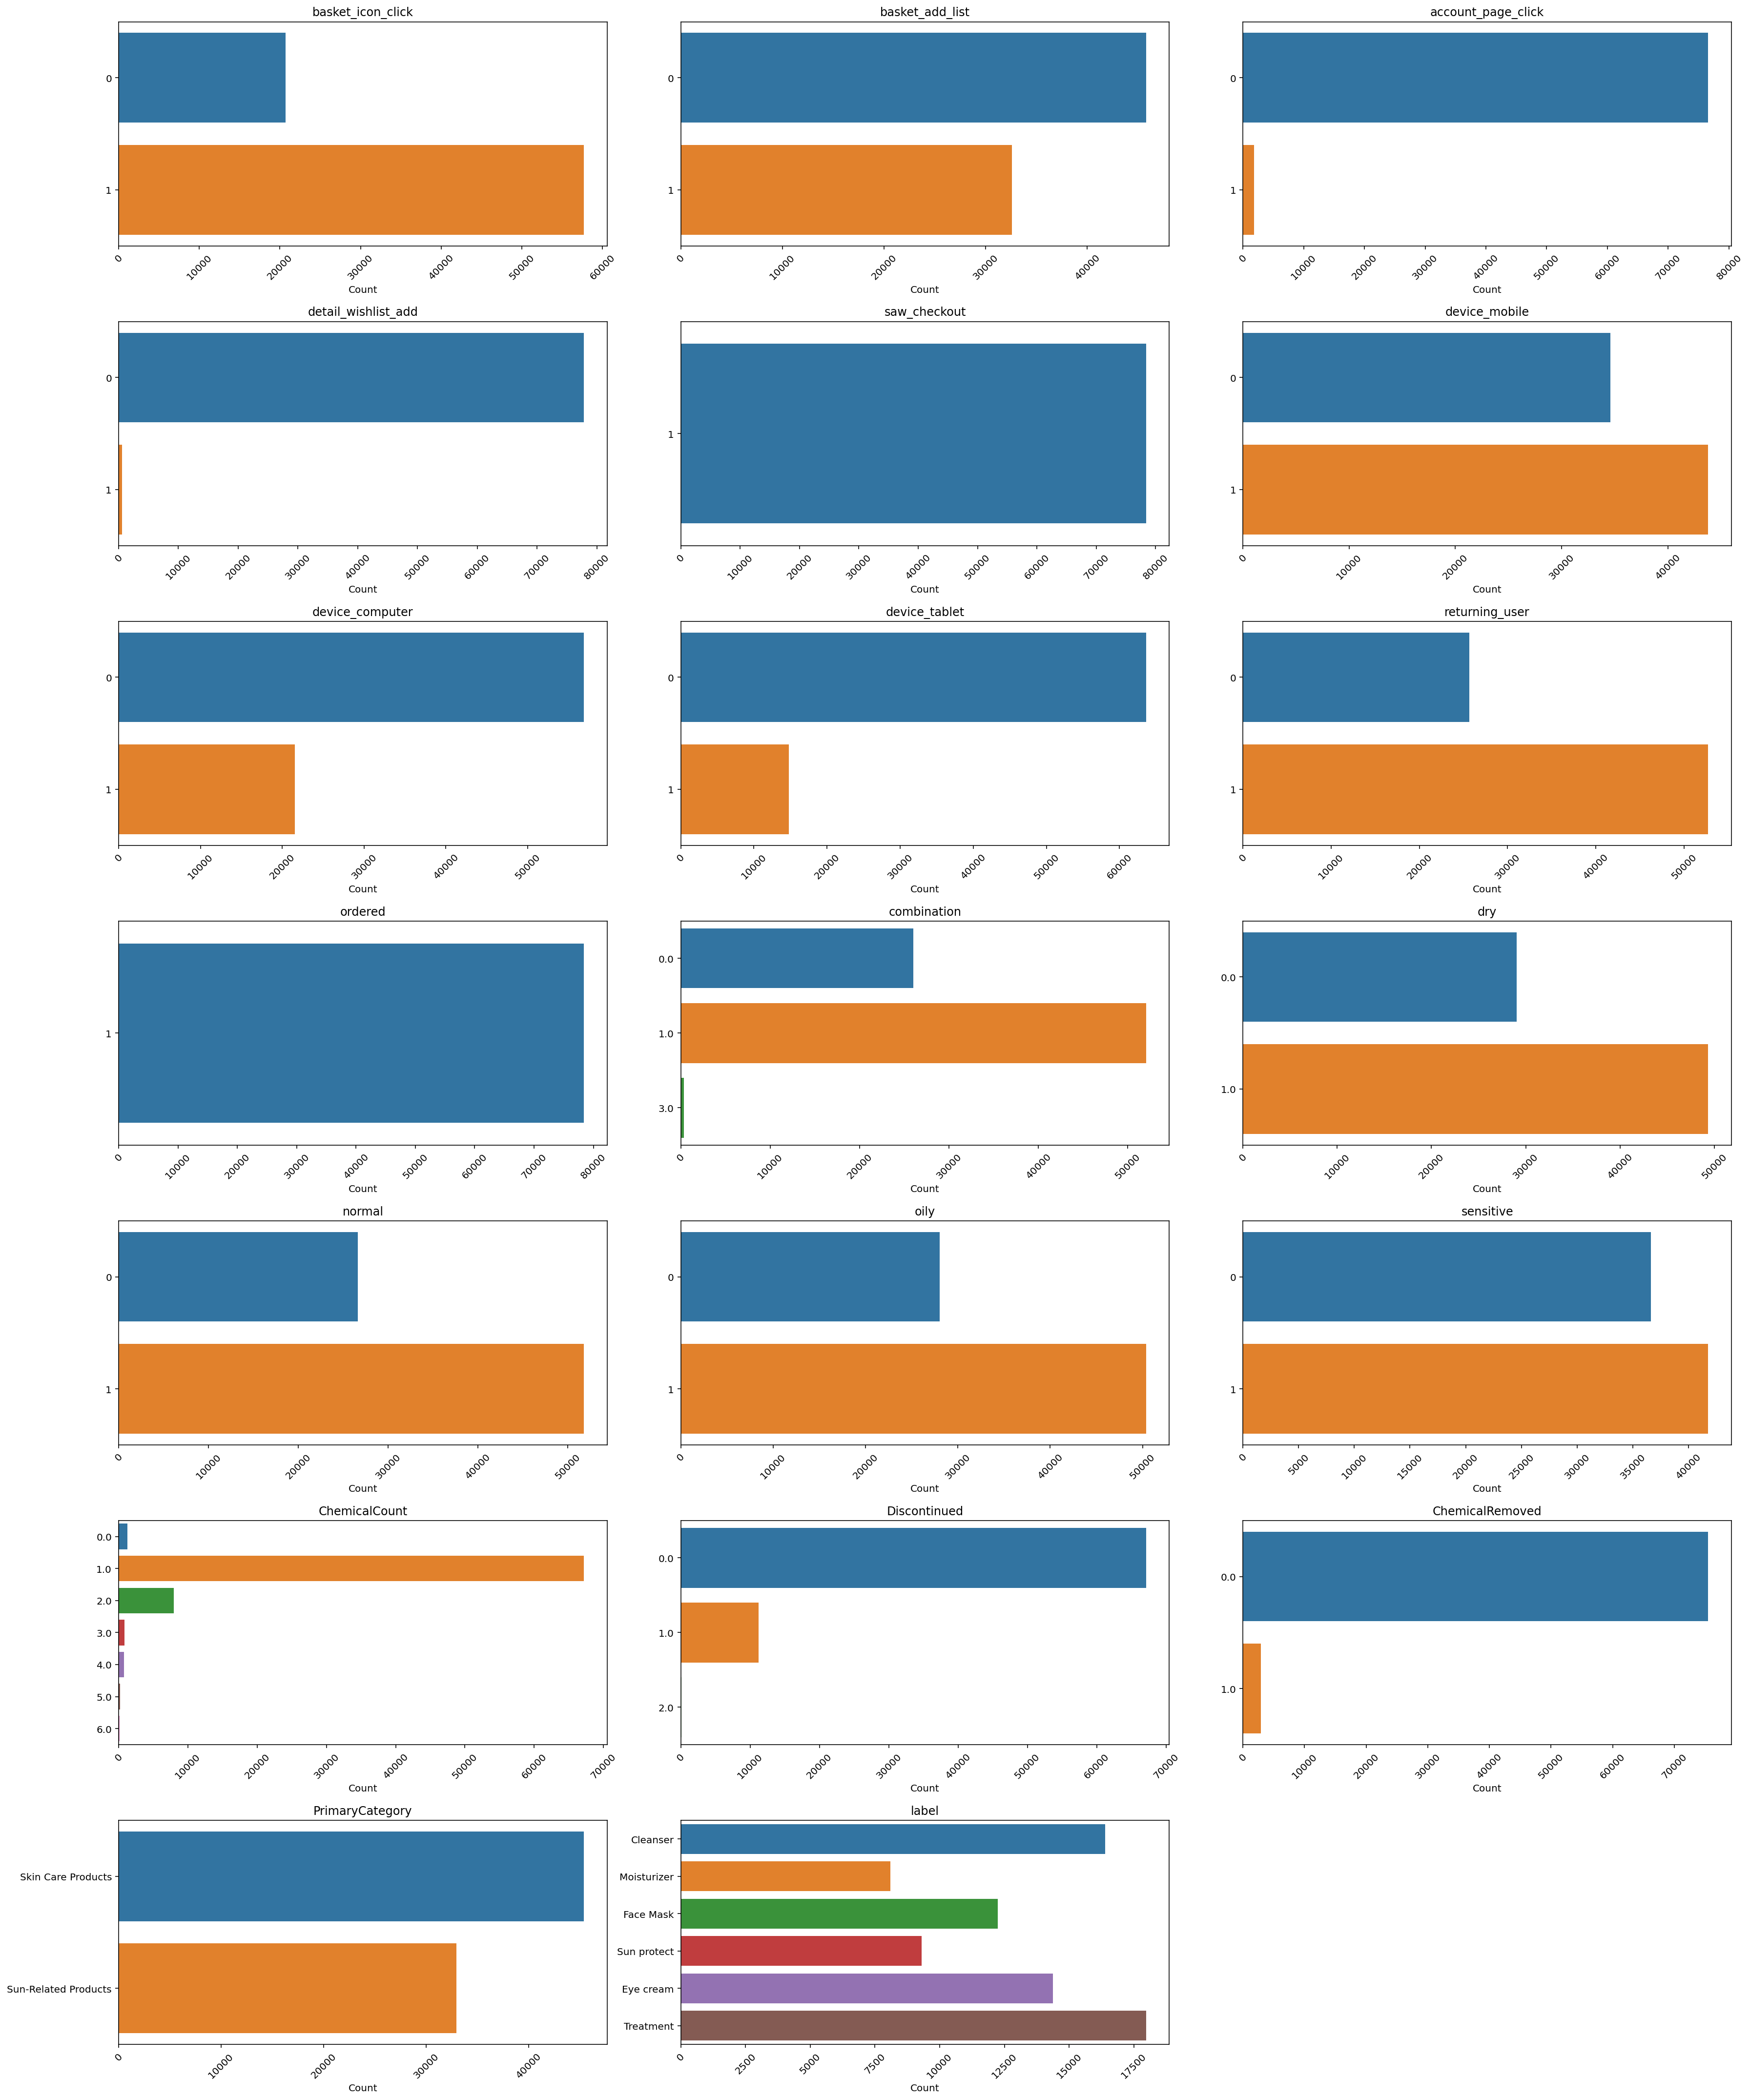

In [203]:
# list of selected columns for bar plot 
selected_columns = [
    'basket_icon_click', 'basket_add_list', 'account_page_click', 
    'detail_wishlist_add', 'saw_checkout', 'device_mobile', 
    'device_computer', 'device_tablet', 'returning_user', 
    'ordered', 'combination', 'dry', 'normal', 'oily', 'sensitive', 
    'ChemicalCount', 'Discontinued', 'ChemicalRemoved','PrimaryCategory', 'label'
]

# calculate the number of rows and columns for the subplot grid
num_cols = 3
num_rows = (len(selected_columns) - 1) // num_cols + 1

# create subplots and flatten axis
fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 30))
axes = axes.flatten()

# iterate through selected columns and create horizontal countplots
for i, column in enumerate(selected_columns):
    sns.countplot(data=sc_df, y=column, ax=axes[i])
    axes[i].tick_params(axis='x', rotation=45)  

    axes[i].set_title(f'{column}')
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel('')

# remove empty subplots
for i in range(len(selected_columns), num_rows * num_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

#### Class Imbalance 
('ordered' and 'saw_checkout')

In [204]:
# check distribution of classes before adding class
print("\nBefore balancing:")
print(sc_df['ordered'].value_counts())
print(sc_df['saw_checkout'].value_counts())


Before balancing:
1    78393
Name: ordered, dtype: int64
1    78393
Name: saw_checkout, dtype: int64


In [205]:
# shuffle df to ensure randomness
sc_shuffled = sc_df.sample(frac=1)
sc_shuffled['ChemicalCount'] = sc_shuffled['ChemicalCount'].astype(int)

# define columns to balance 
columns_to_balance = ['ordered', 'saw_checkout']

# calculate number of records for 'saw_checkout' class 1 to maintain 60% balance
num_records_to_change_saw_checkout = int(len(sc_shuffled[sc_shuffled['saw_checkout'] == 1]) * 0.6)
records_to_change_saw_checkout = sc_shuffled[sc_shuffled['saw_checkout'] == 1].head(num_records_to_change_saw_checkout)
records_to_change_saw_checkout['saw_checkout'] = 0

# update df 
sc_shuffled.loc[records_to_change_saw_checkout.index, 'saw_checkout'] = records_to_change_saw_checkout['saw_checkout']


# define threshold for chemical count to determine class imbalance
chemical_count_threshold = 1

# calculate the number of records to change for 'ordered' class 1 based on chemical count 
num_records_to_change_ordered = int(len(sc_shuffled[(sc_shuffled['ordered'] == 1) & 
                                                    (sc_shuffled['ChemicalCount'] <= chemical_count_threshold)]))

# select records where 'ordered' = 1 and chemical count does not exceed the threshold
records_to_change_ordered = sc_shuffled[(sc_shuffled['ordered'] == 1) & 
                                        (sc_shuffled['ChemicalCount'] <= chemical_count_threshold)].head(num_records_to_change_ordered)
records_to_change_ordered['ordered'] = 0

# update df 
sc_shuffled.loc[records_to_change_ordered.index, 'ordered'] = records_to_change_ordered['ordered']

In [206]:
# check distribution of classes after adding class
print("\nAfter balancing:")
print(sc_shuffled ['saw_checkout'].value_counts())
print(sc_shuffled ['ordered'].value_counts())


After balancing:
0    47035
1    31358
Name: saw_checkout, dtype: int64
0    68453
1     9940
Name: ordered, dtype: int64


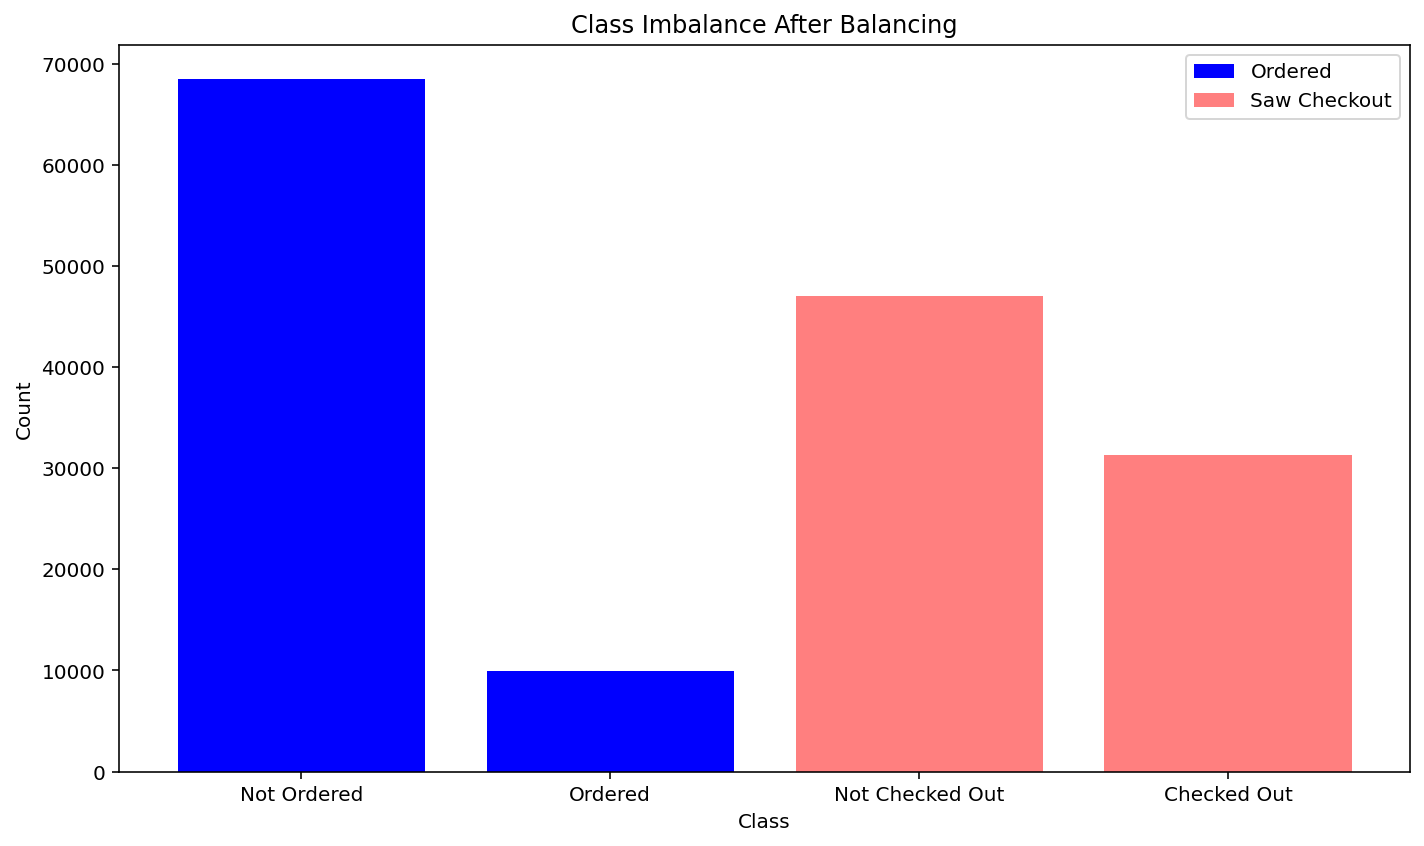

In [207]:
plt.figure(figsize=(10, 6))

# bar plot for 'ordered' column
plt.bar(['Not Ordered', 'Ordered'], sc_shuffled['ordered'].value_counts(), color='blue', label='Ordered')

# bar plot for 'saw_checkout' column
plt.bar(['Not Checked Out', 'Checked Out'], sc_shuffled['saw_checkout'].value_counts(), color='red', label='Saw Checkout', alpha=0.5)

plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Imbalance After Balancing')
plt.legend()
plt.tight_layout()

plt.show()

In [208]:
checkout_distribution = sc_shuffled['saw_checkout'].value_counts(normalize=True)
print("Class Distribution for Saw Check Out:\n", checkout_distribution)

ordered_distribution = sc_shuffled['ordered'].value_counts(normalize=True)
print("Class Distribution for Ordered:\n", ordered_distribution)

Class Distribution for Saw Check Out:
 0    0.59999
1    0.40001
Name: saw_checkout, dtype: float64
Class Distribution for Ordered:
 0    0.873203
1    0.126797
Name: ordered, dtype: float64


In [209]:
balanced_df = sc_shuffled.copy()
balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78393 entries, 62854 to 56484
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   UserID               78393 non-null  object 
 1   basket_icon_click    78393 non-null  int64  
 2   basket_add_list      78393 non-null  int64  
 3   account_page_click   78393 non-null  int64  
 4   detail_wishlist_add  78393 non-null  int64  
 5   saw_checkout         78393 non-null  int64  
 6   device_mobile        78393 non-null  int64  
 7   device_computer      78393 non-null  int64  
 8   device_tablet        78393 non-null  int64  
 9   returning_user       78393 non-null  int64  
 10  ordered              78393 non-null  int64  
 11  label                78393 non-null  object 
 12  brand                78393 non-null  object 
 13  name                 78393 non-null  object 
 14  price                78393 non-null  float64
 15  rank                 78393 non-n

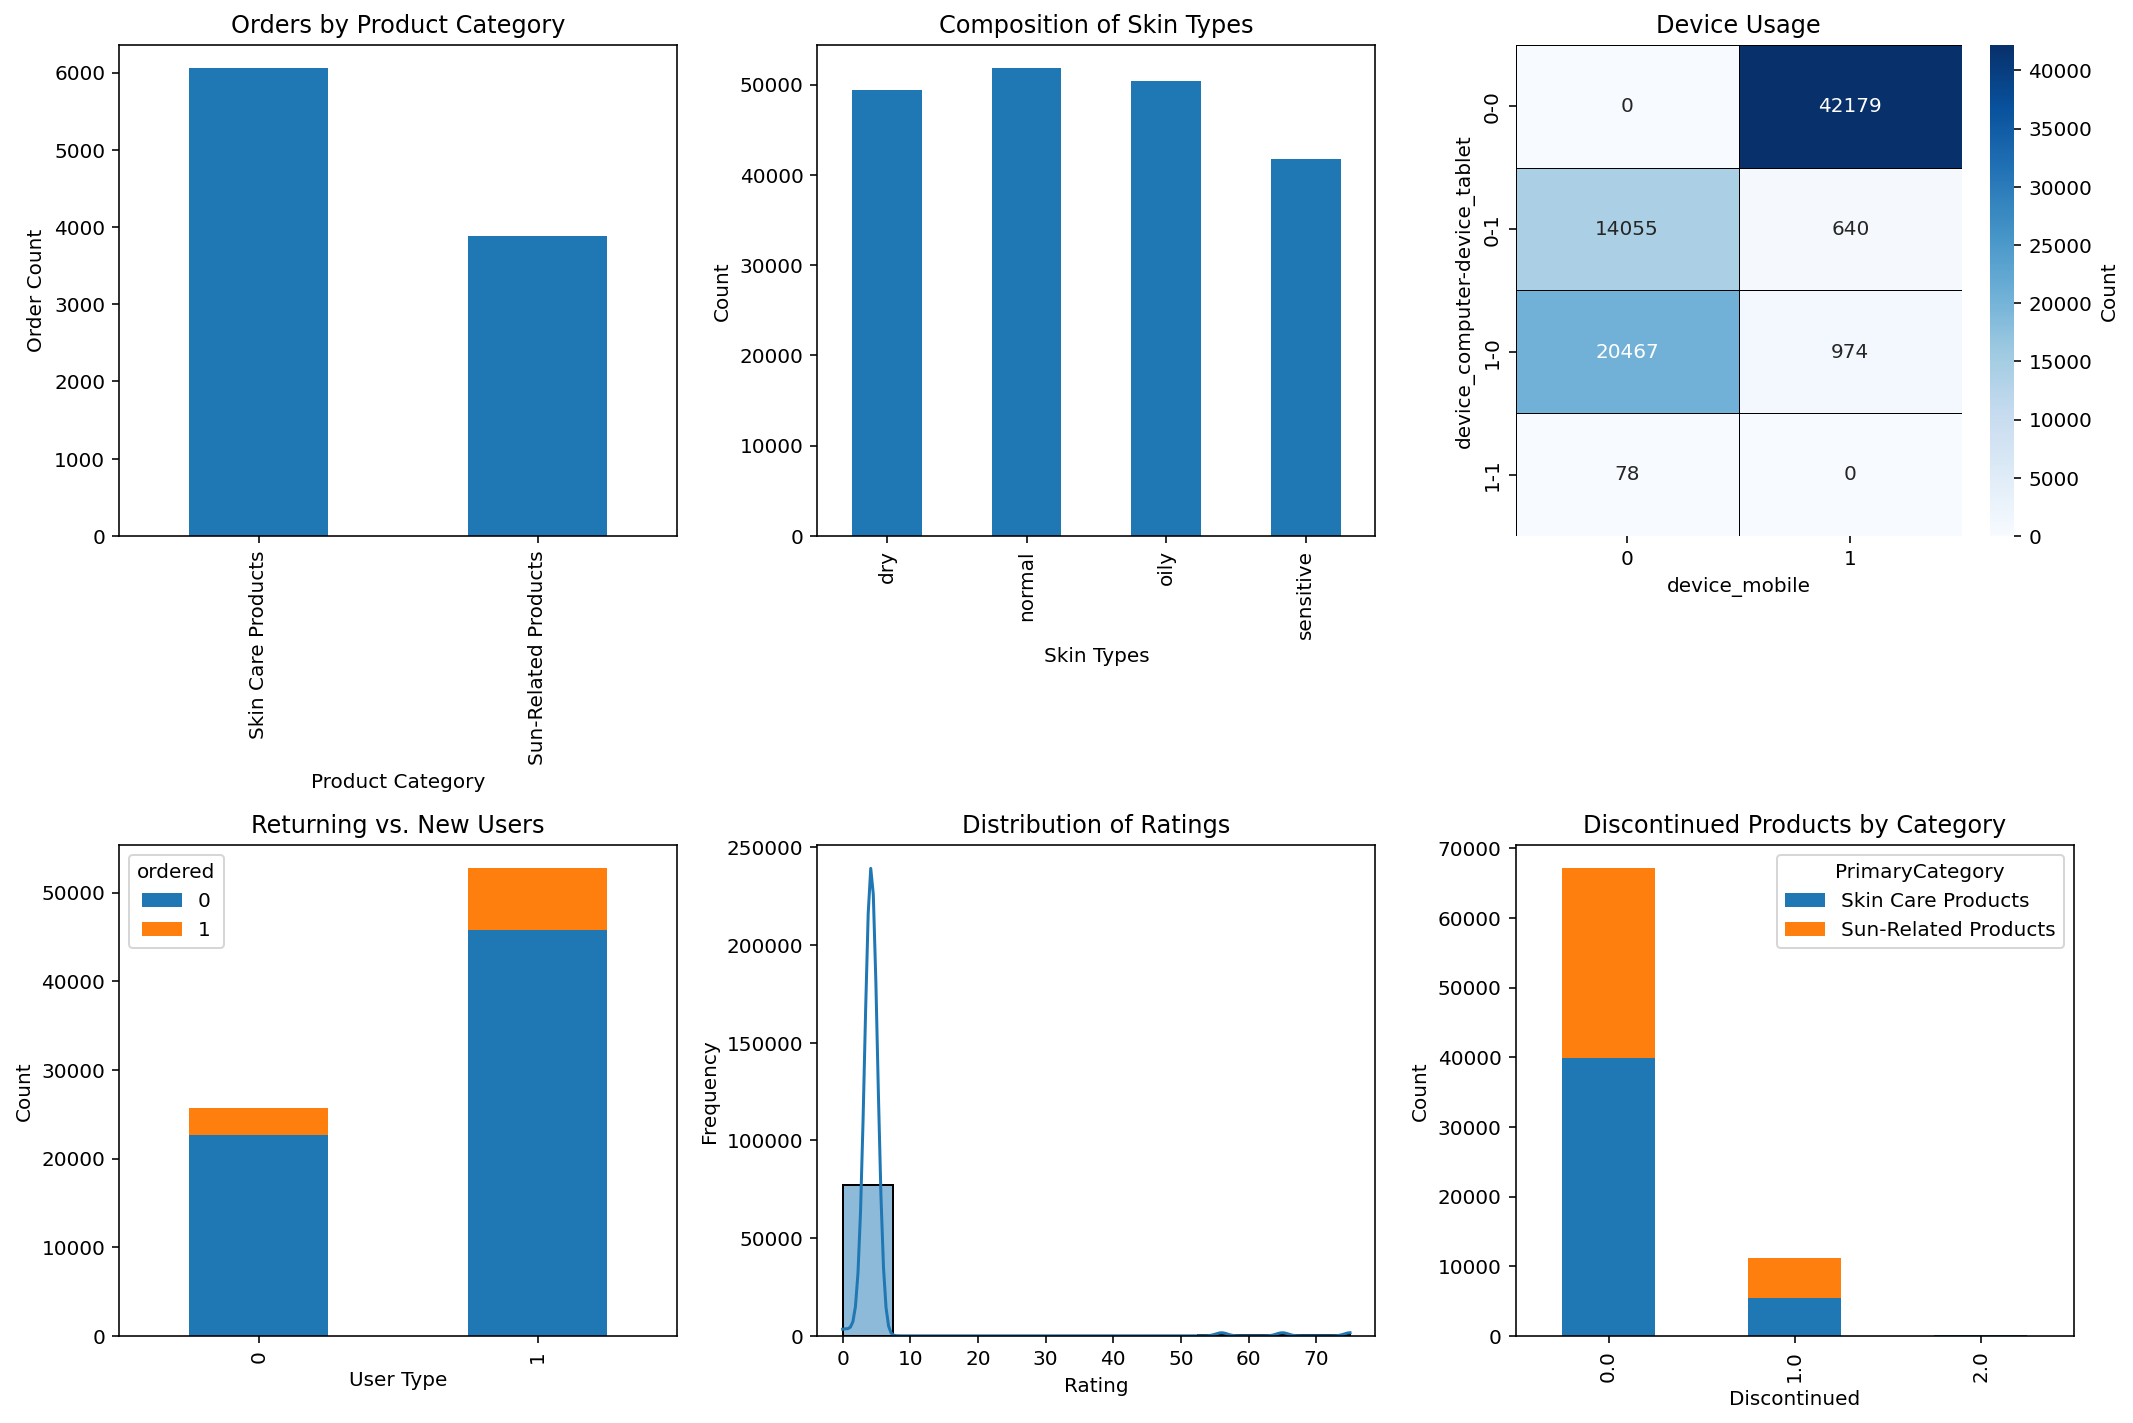

In [210]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# count of ordered by product category
order_count_by_category = balanced_df.groupby('PrimaryCategory')['ordered'].sum()
order_count_by_category.plot(kind='bar', ax=axs[0, 0], 
                             xlabel='Product Category', ylabel='Order Count', 
                             title='Orders by Product Category')

# composition of skin types
skin_type_counts = balanced_df[['dry', 'normal', 'oily', 'sensitive']].sum()
skin_type_counts.plot(kind='bar', stacked=True, ax=axs[0, 1], 
                      xlabel='Skin Types', ylabel='Count', 
                      title='Composition of Skin Types')

# device usage 
device_usage = balanced_df[['device_computer', 'device_tablet', 'device_mobile']].astype(int)
device_usage_counts = device_usage.groupby(device_usage.columns.tolist()).size().unstack(fill_value=0)
sns.heatmap(device_usage_counts, ax=axs[0, 2], cmap="Blues", annot=True, fmt="d",
            cbar_kws={'label': 'Count'}, 
            linewidths=0.5, linecolor='black')
axs[0, 2].set_title('Device Usage')

# returning vs new users 
returning_new_users = pd.crosstab(balanced_df['returning_user'], 
                                  balanced_df['ordered'])

returning_new_users.plot(kind='bar', stacked=True, ax=axs[1, 0], 
                         xlabel='User Type', ylabel='Count', 
                         title='Returning vs. New Users')

# distribution of ratings 
sns.histplot(data=balanced_df, x='rank', bins=10, kde=True, ax=axs[1, 1])
axs[1, 1].set_xlabel('Rating')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].set_title('Distribution of Ratings')

# discontinued products 
discontinued_category_counts = pd.crosstab(index=balanced_df['Discontinued'], 
                                           columns=balanced_df['PrimaryCategory'])

discontinued_category_counts.plot(kind='bar', stacked=True, ax=axs[1, 2], 
                                  xlabel='Discontinued', ylabel='Count', 
                                  title='Discontinued Products by Category')

plt.tight_layout()
plt.show()

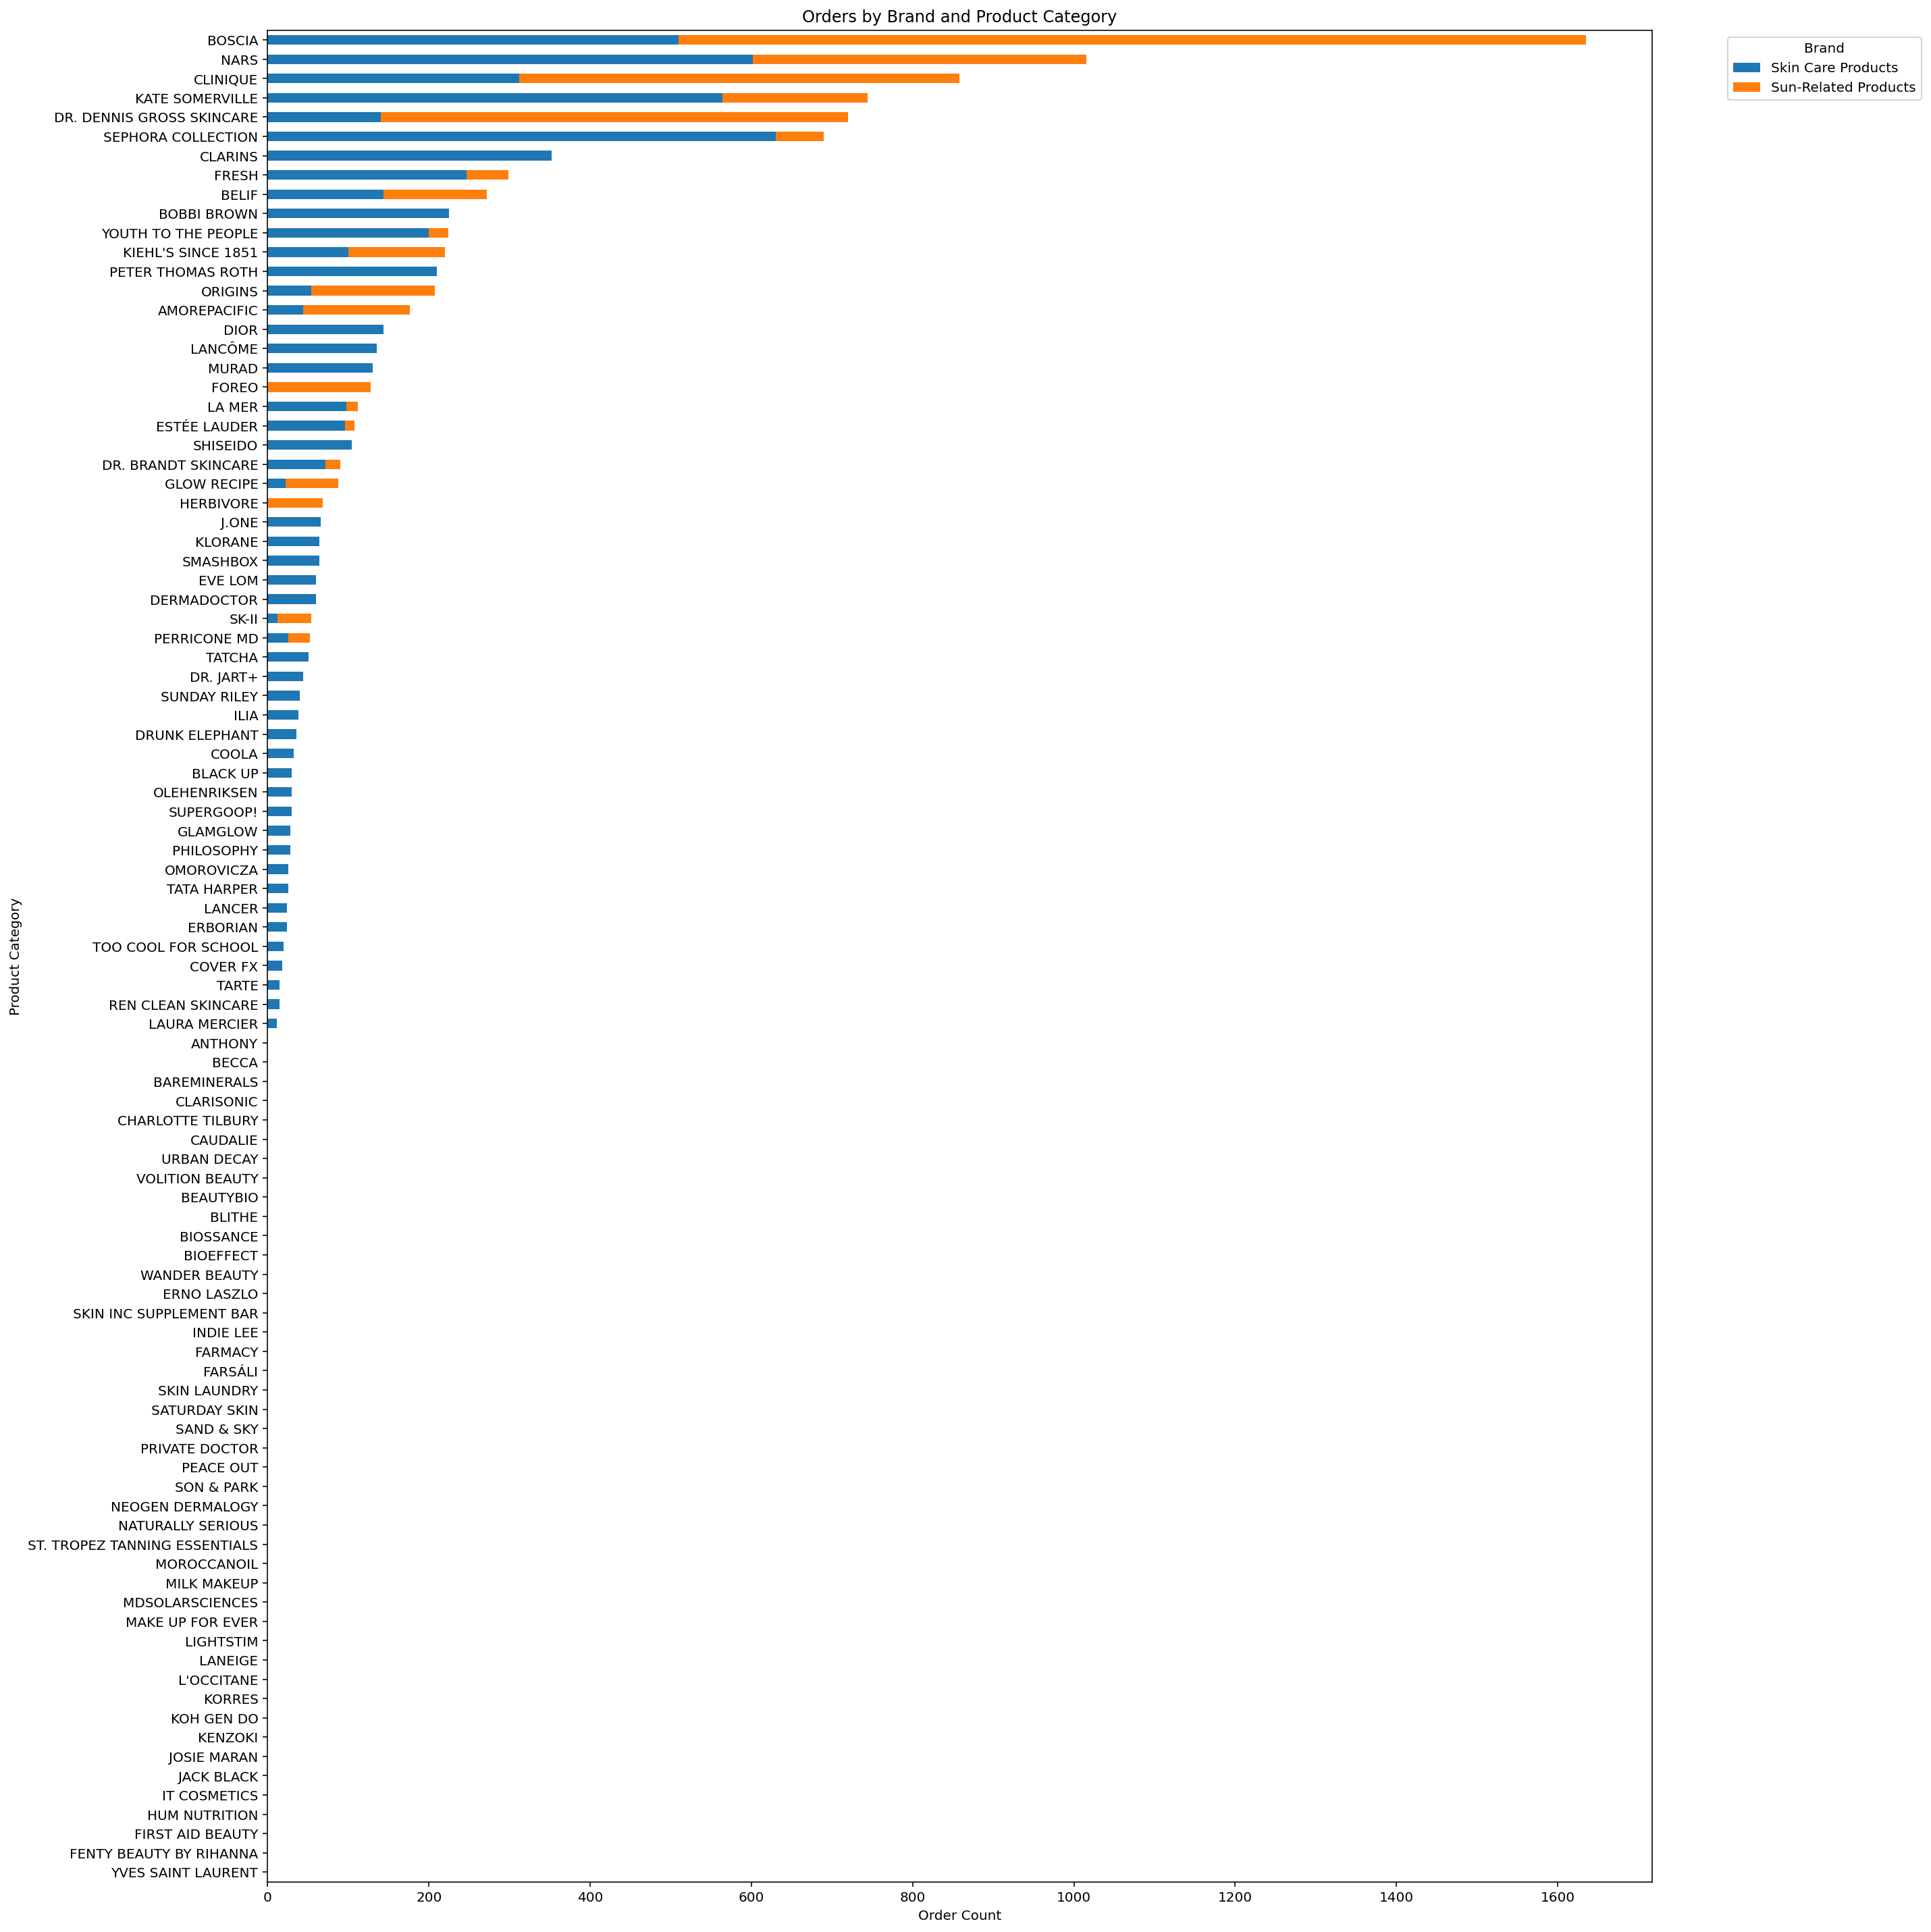

In [211]:
#  order count by brand and product category
order_count_by_brand_category = balanced_df.groupby(['brand', 'PrimaryCategory'])['ordered'].sum().unstack().fillna(0)
order_count_by_brand = order_count_by_brand_category.sum(axis=1).sort_values()
order_count_by_brand_category = order_count_by_brand_category.loc[order_count_by_brand.index]


order_count_by_brand_category.plot(kind='barh', stacked=True, figsize=(20, 20))
plt.xlabel('Order Count')
plt.ylabel('Product Category')
plt.title('Orders by Brand and Product Category')
plt.legend(title='Brand', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

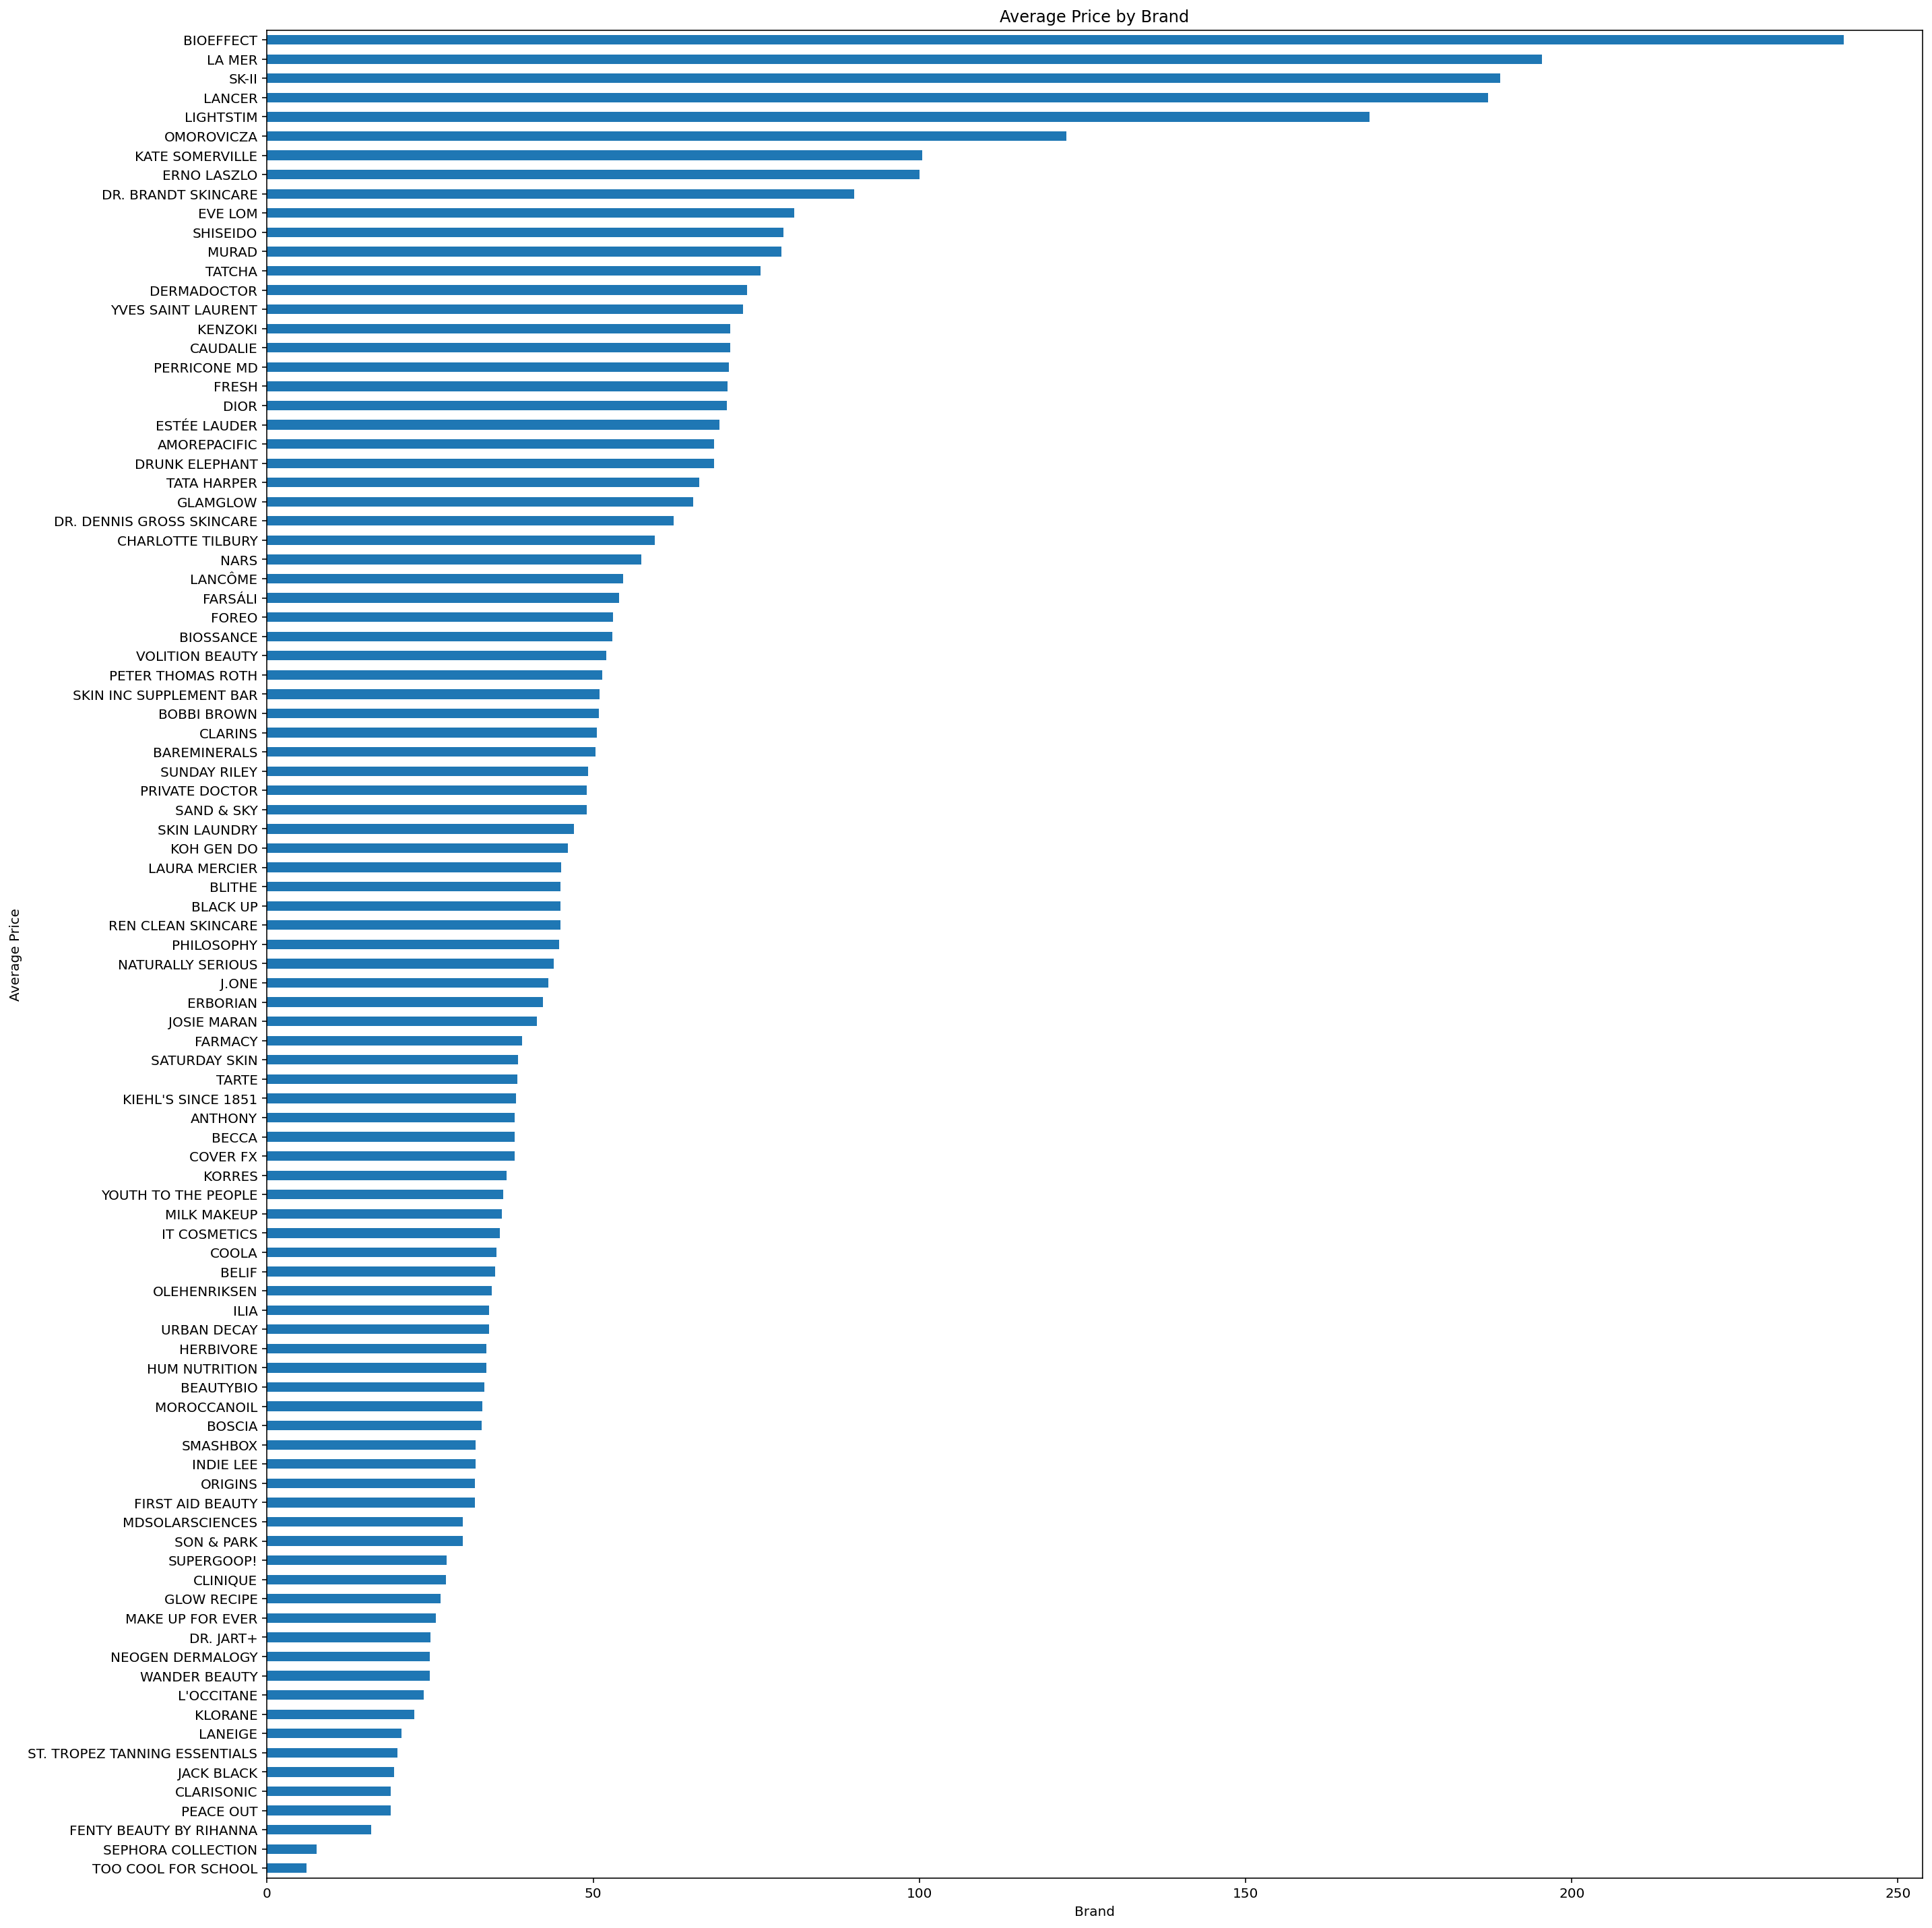

In [212]:
# plot the average price by brand
avg_price_by_brand = balanced_df.groupby('brand')['price'].mean().sort_values()

plt.figure(figsize=(20, 20))
avg_price_by_brand.plot(kind='barh')
plt.xlabel('Brand')
plt.ylabel('Average Price')
plt.title('Average Price by Brand')
plt.tight_layout()
plt.show()

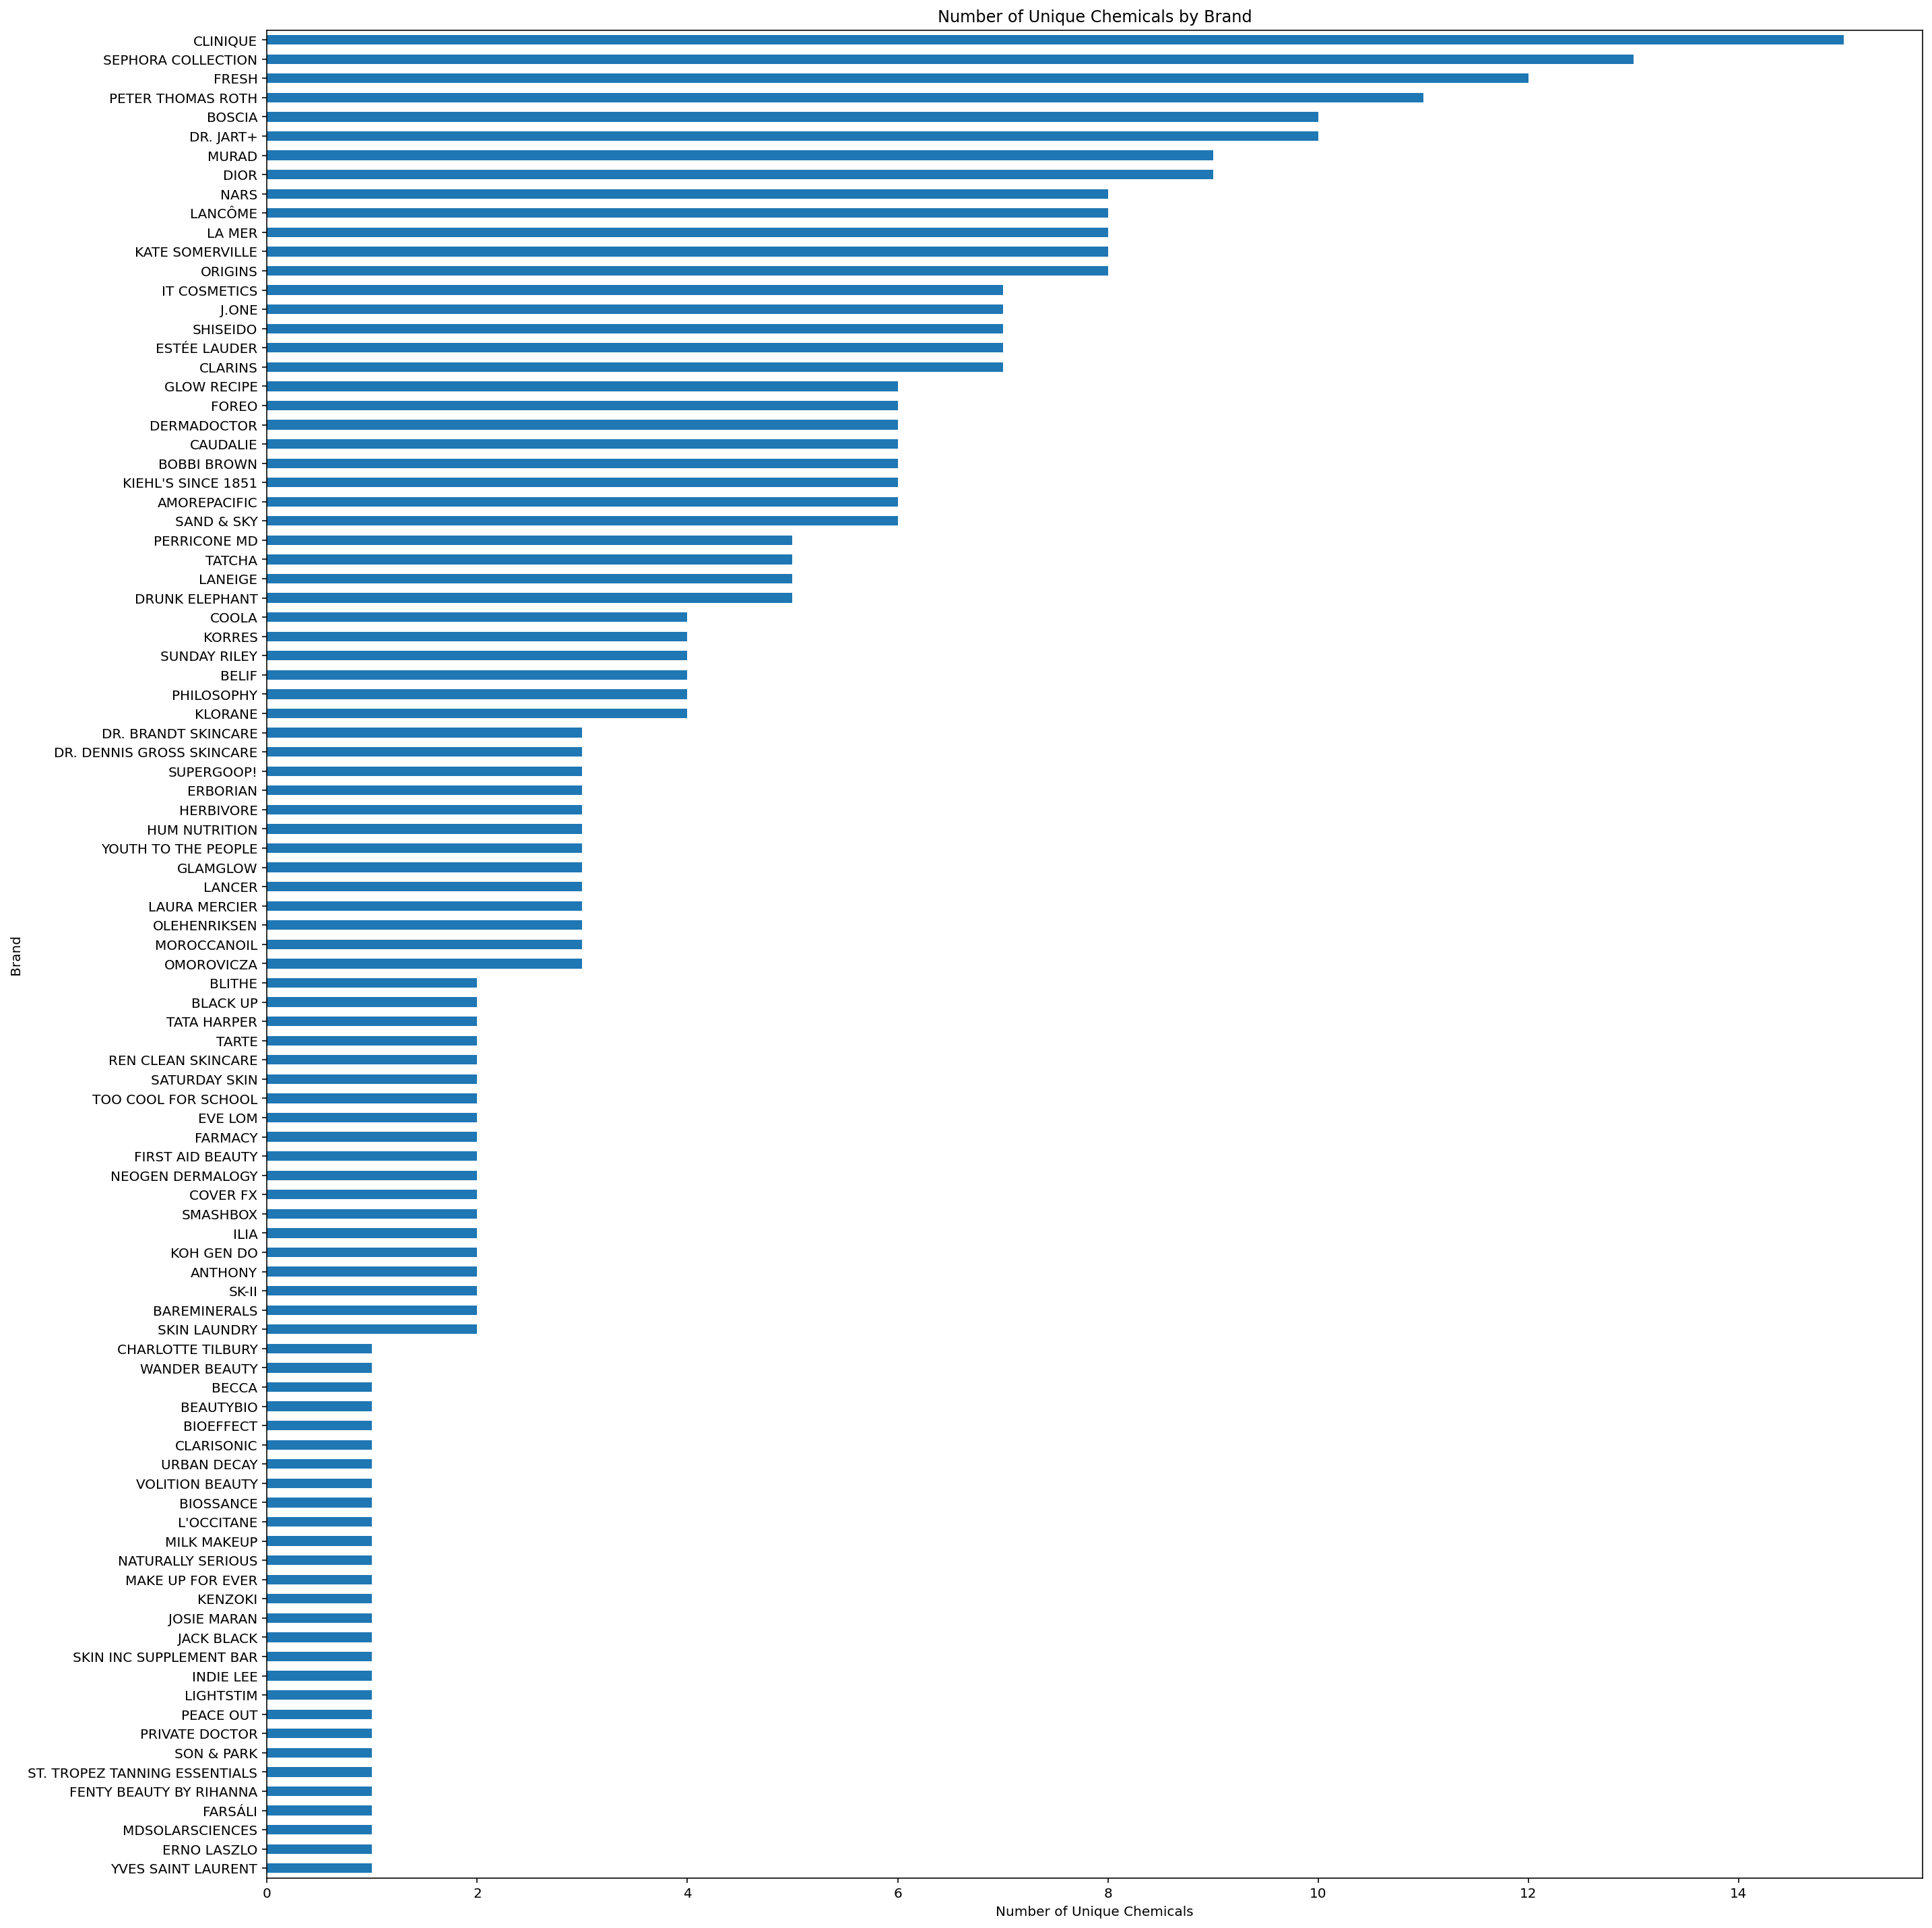

In [213]:
# number of unique chemicals per brand
chemicals_by_brand = balanced_df.groupby('brand')['ChemicalName'].nunique().sort_values()
plt.figure(figsize=(20, 20))
chemicals_by_brand.plot(kind='barh')
plt.xlabel('Number of Unique Chemicals')
plt.ylabel('Brand')
plt.title('Number of Unique Chemicals by Brand')
plt.tight_layout()
plt.show()

In [214]:
# pivot table to aggregate the binary values for each chemical and skin type combination
pivot_table = balanced_df.pivot_table(index='ChemicalName', 
                                values=['dry', 'normal', 'oily', 'sensitive'], 
                                aggfunc='sum')

<Figure size 1296x720 with 0 Axes>

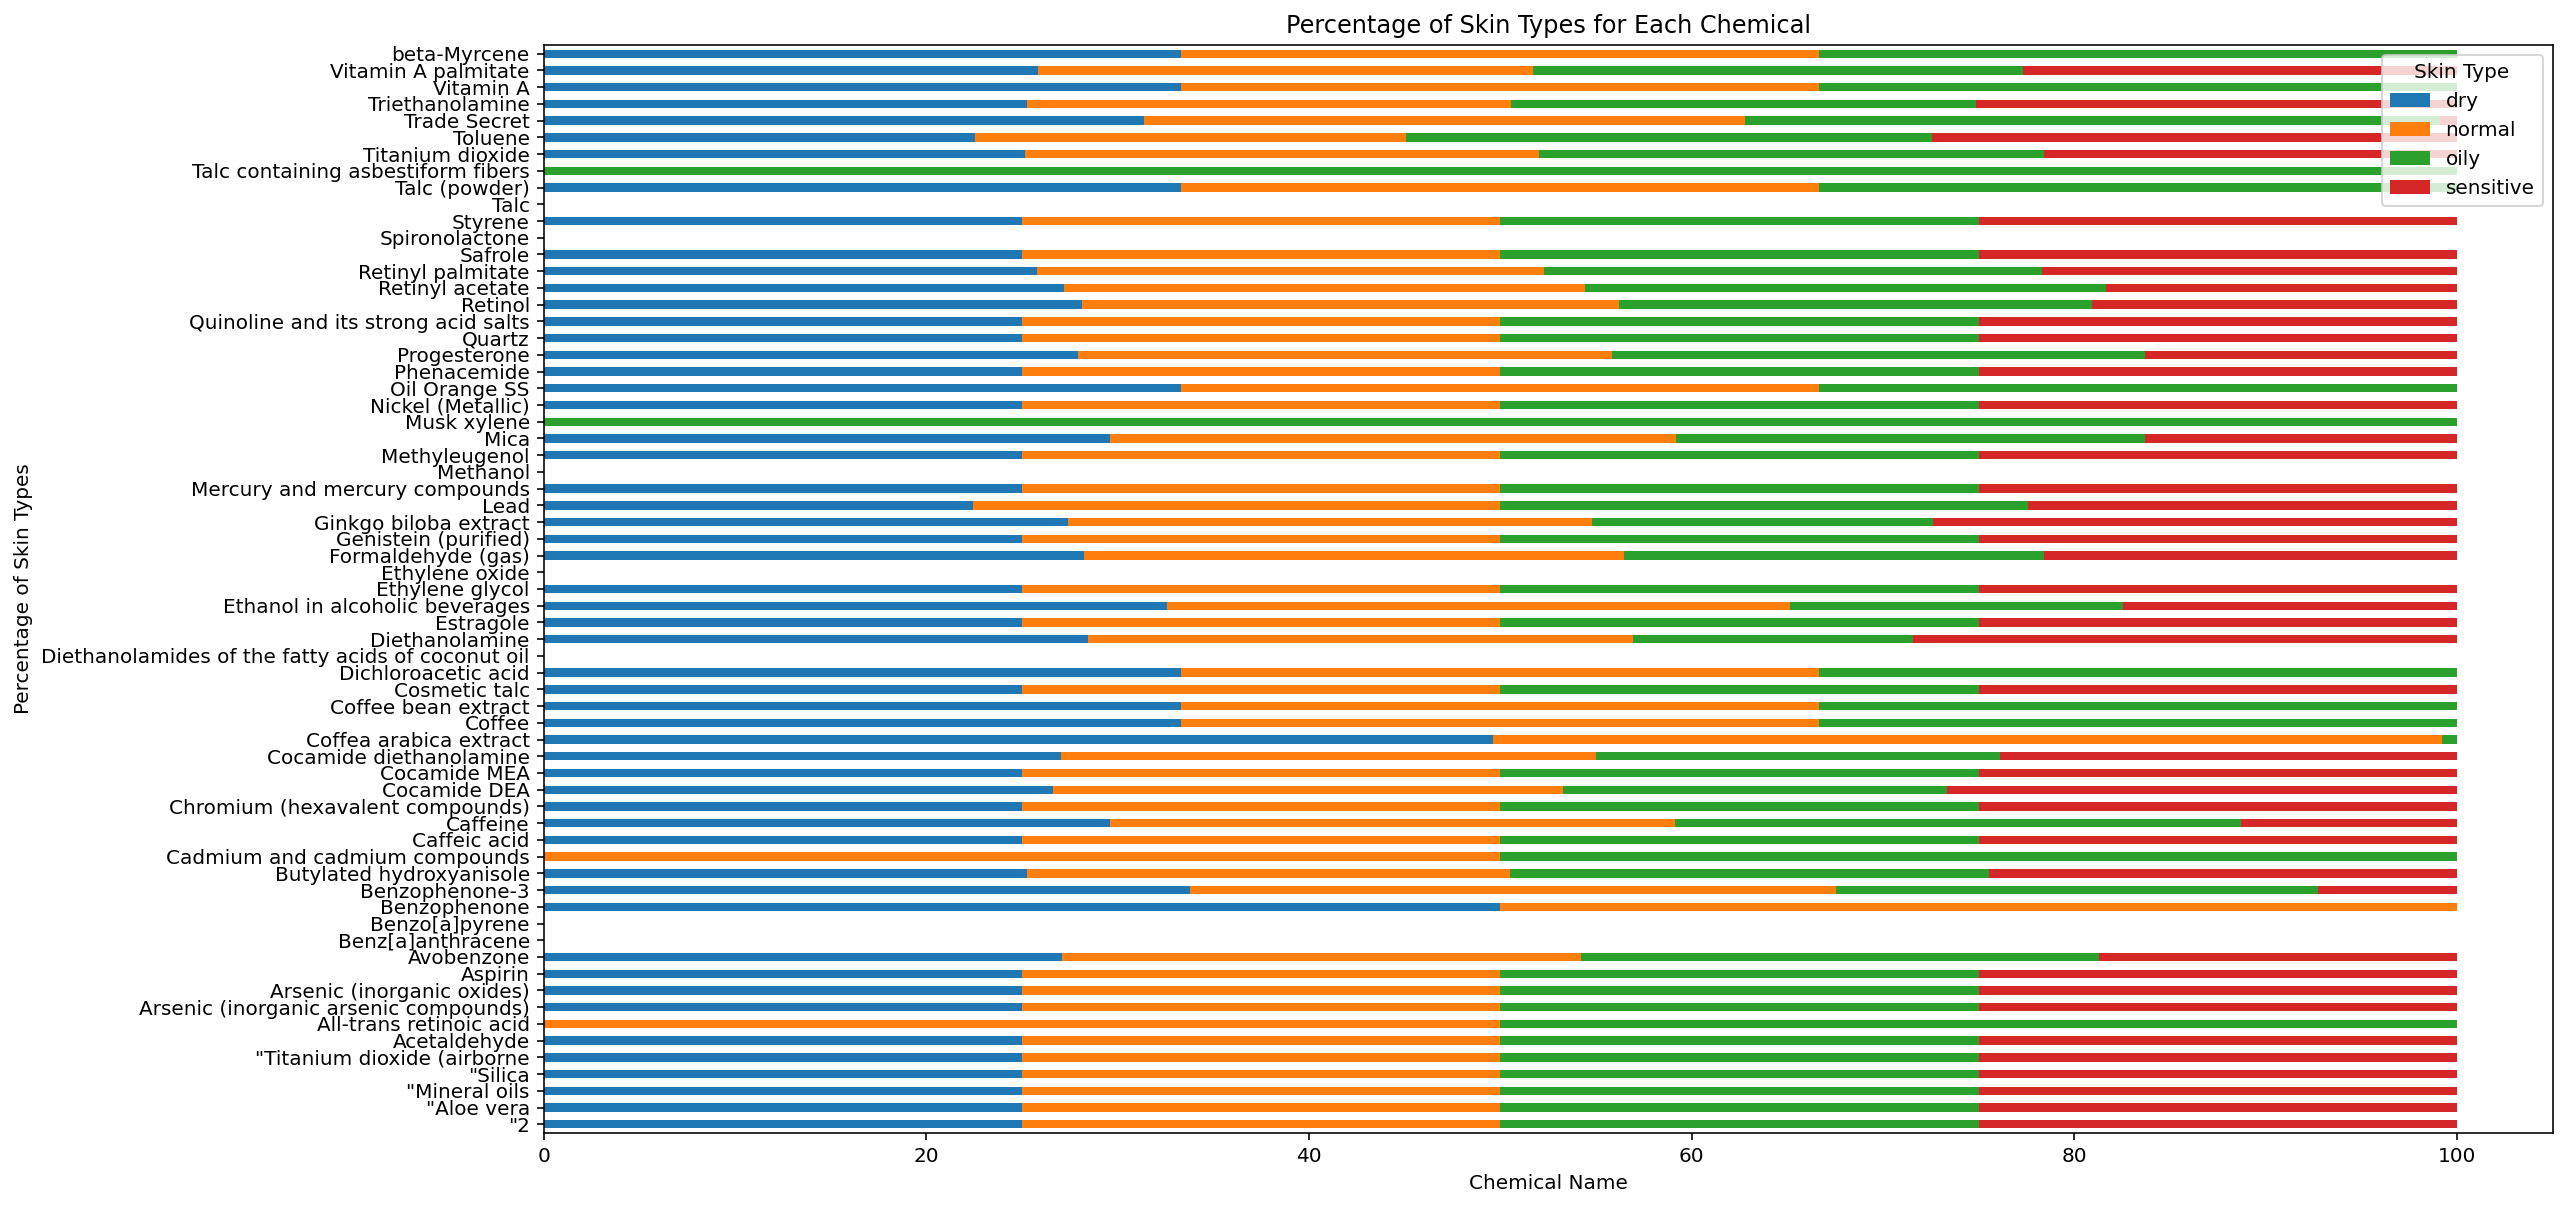

In [215]:
# calculate total number of chemicals per skin type
pivot_table['total'] = pivot_table.sum(axis=1)

# calculate percentage of each skin type for each chemical
for col in pivot_table.columns:
    pivot_table[col] = pivot_table[col] / pivot_table['total'] * 100
pivot_table.drop(columns='total', inplace=True)

# set figure size
plt.figure(figsize=(18, 10))

# plot % of skin types for each chemical 
pivot_table.plot(kind='barh', stacked=True, figsize=(18, 10))
plt.xlabel('Chemical Name')
plt.ylabel('Percentage of Skin Types')
plt.title('Percentage of Skin Types for Each Chemical')

plt.legend(title='Skin Type', loc='upper right')
plt.show();

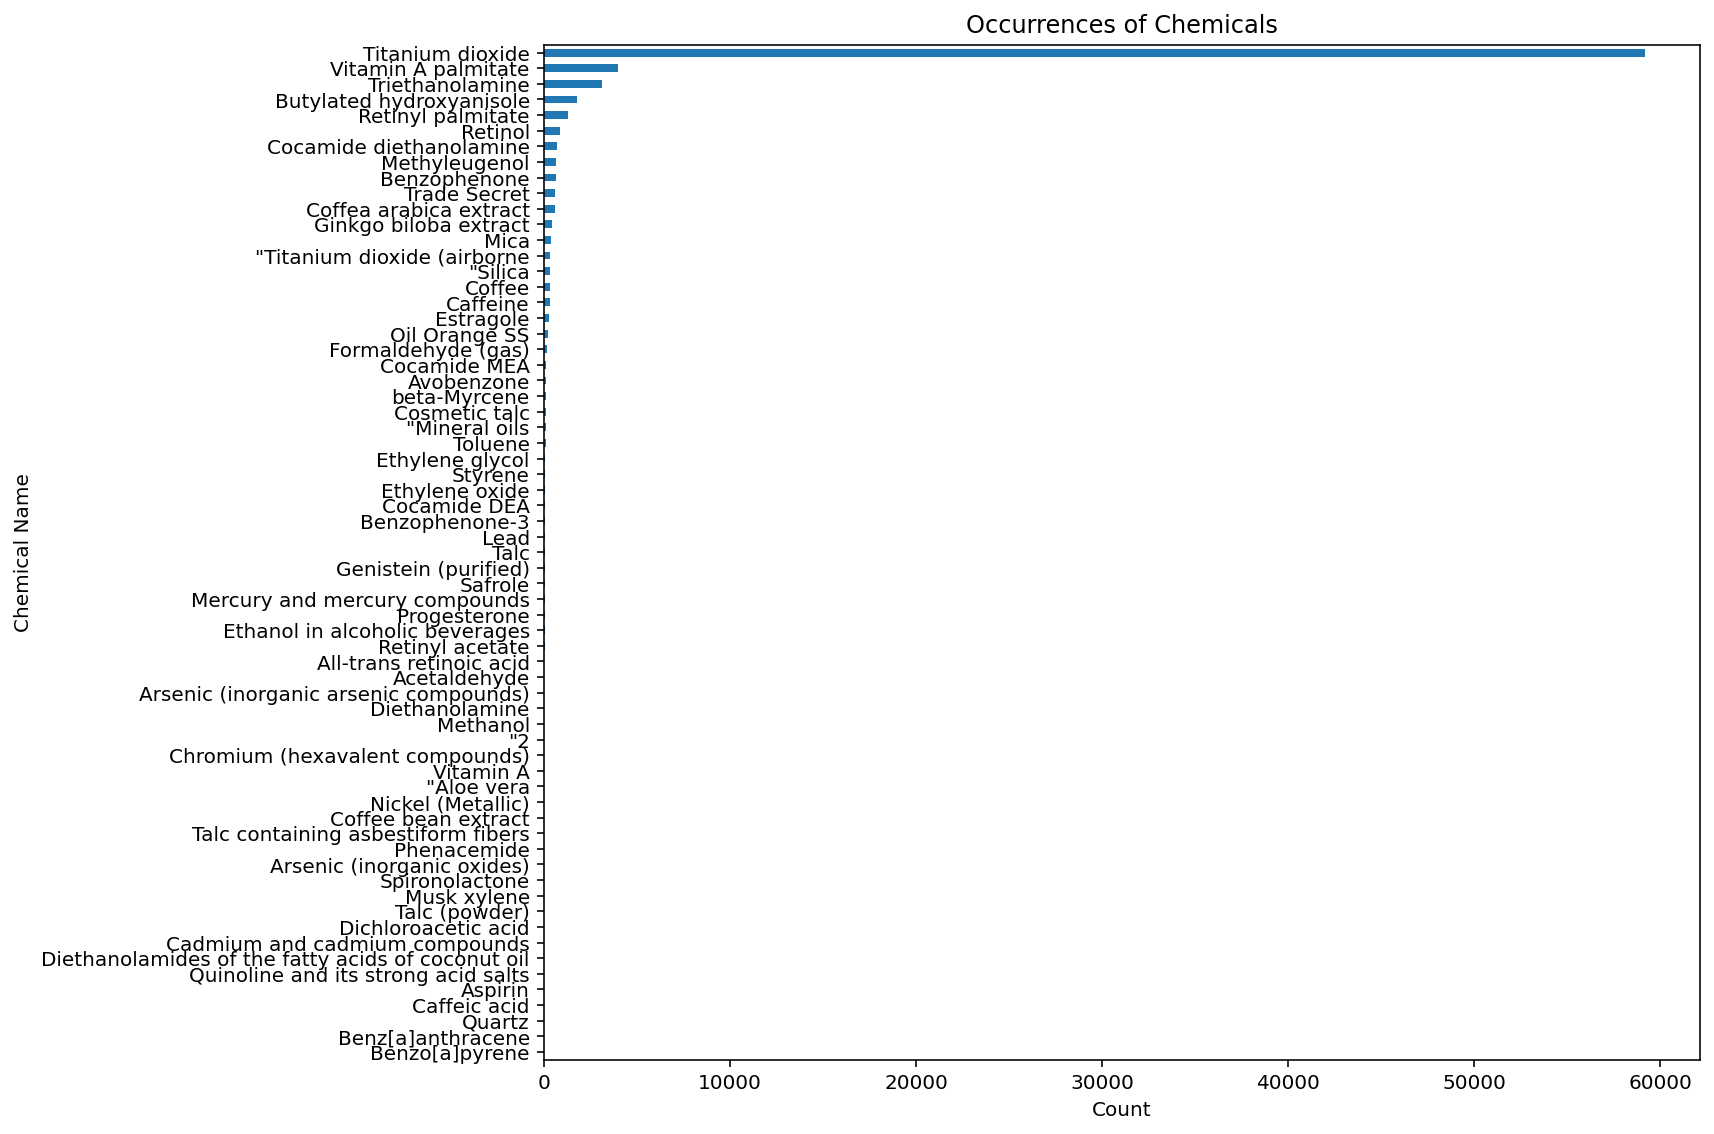

In [216]:
# count occurrences of each chemical
chemical_counts = balanced_df['ChemicalName'].value_counts()
chemical_counts_sorted = chemical_counts.sort_values(ascending=True)

# plot bar chart
plt.figure(figsize=(12, 8))
chemical_counts_sorted.plot(kind='barh')
plt.title('Occurrences of Chemicals')
plt.xlabel('Count')
plt.ylabel('Chemical Name')
plt.tight_layout()
plt.show()

In [217]:
# summary statistics of target column 'ordered'
balanced_df['ordered'].describe()

count    78393.000000
mean         0.126797
std          0.332748
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: ordered, dtype: float64

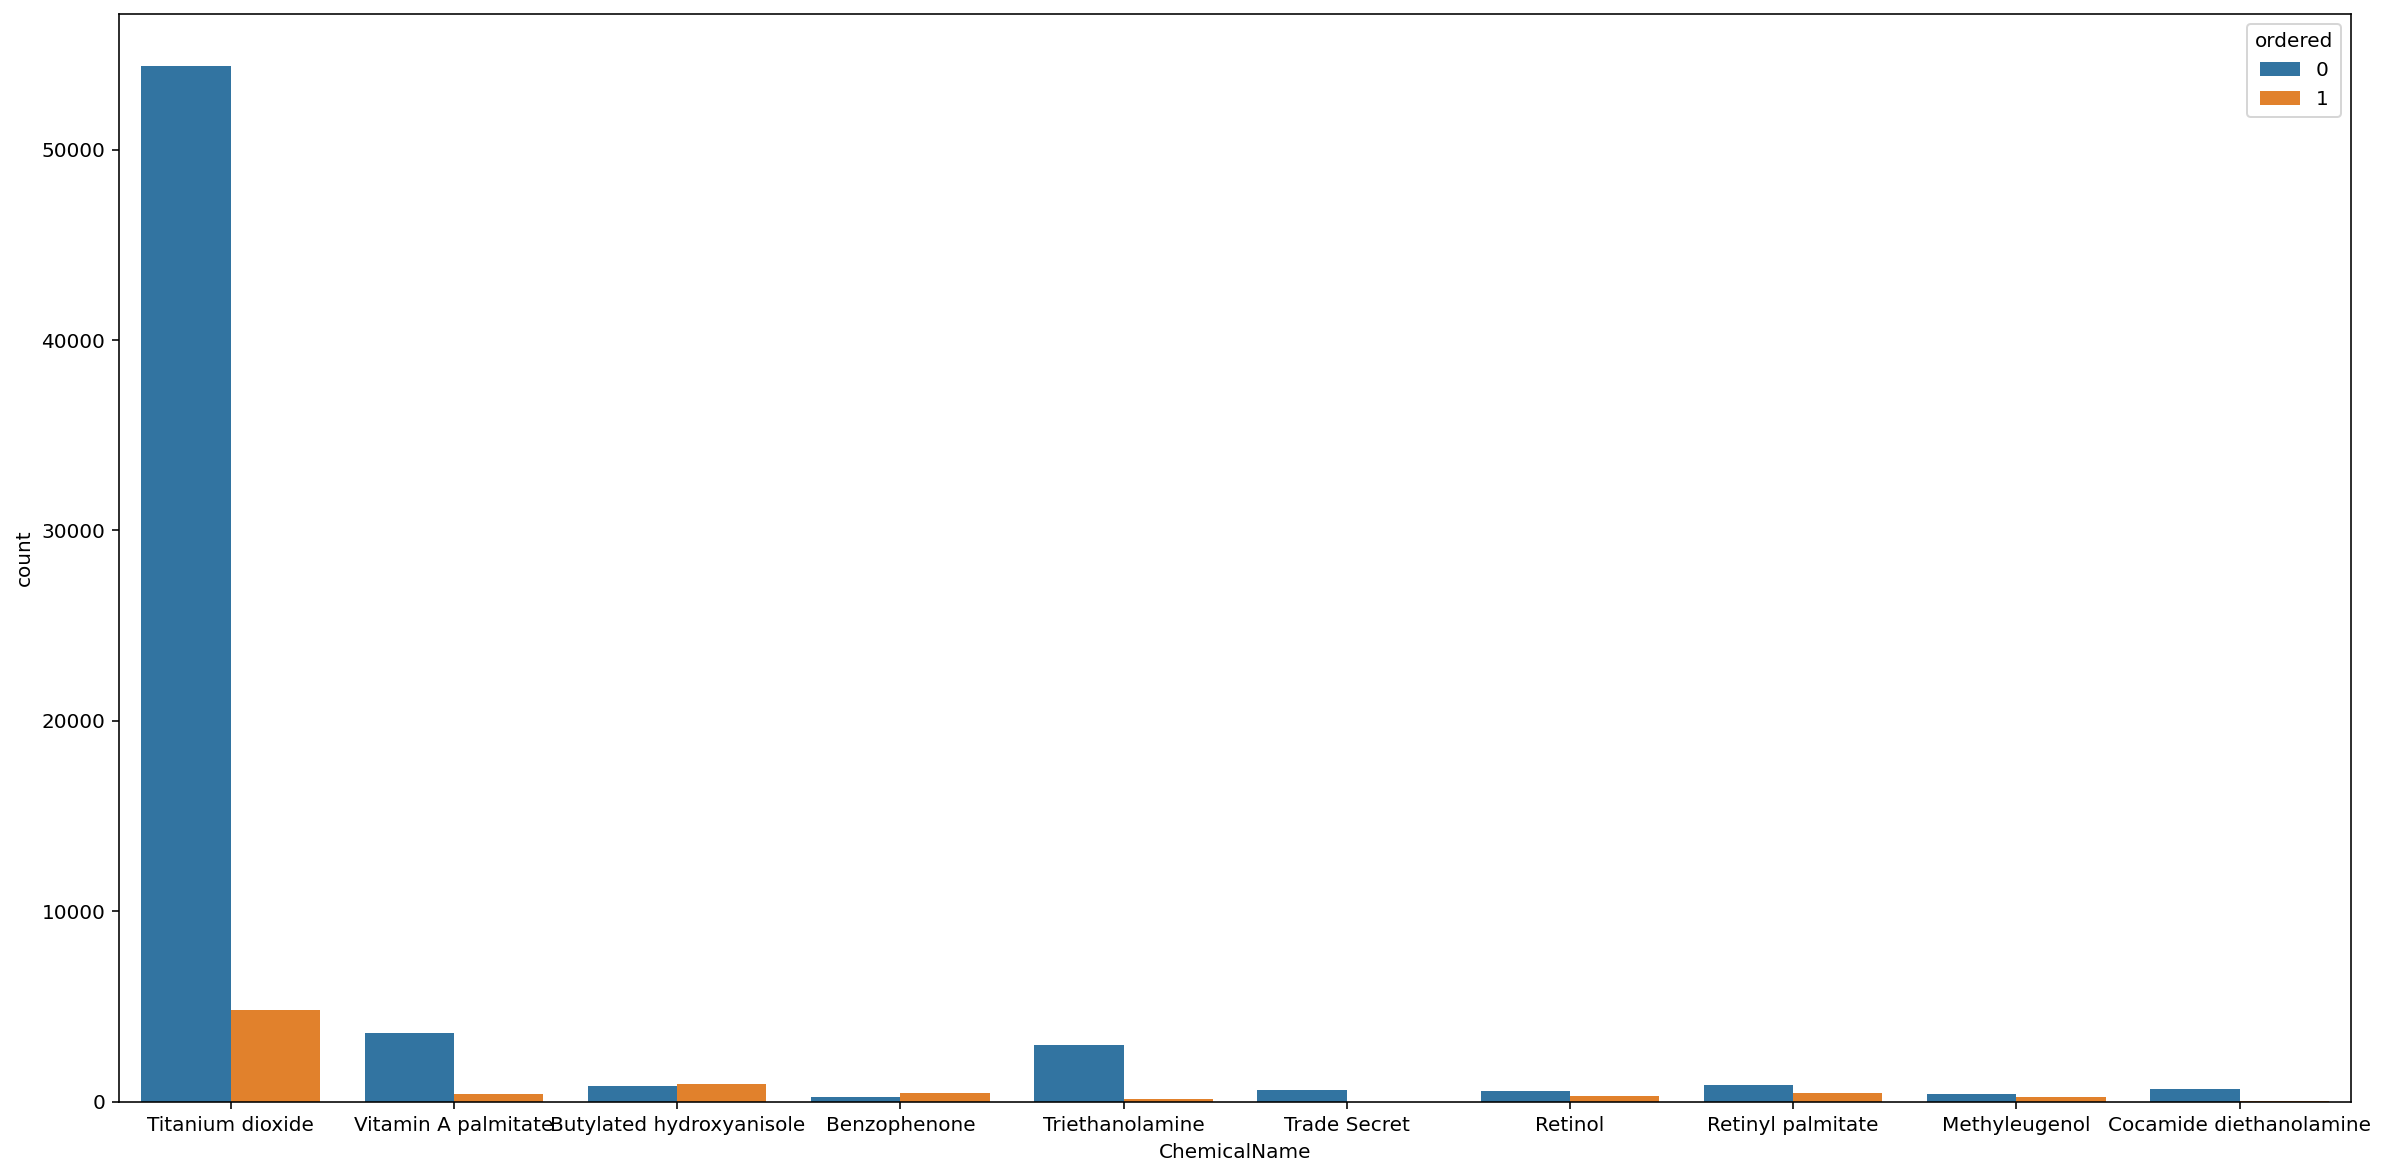

In [218]:
# create df for top chemicals + whether they were bought 
top_n_chemicals = balanced_df['ChemicalName'].value_counts().nlargest(10).index
top_n_df = balanced_df[balanced_df['ChemicalName'].isin(top_n_chemicals)]

# set figure
plt.figure(figsize=(20, 10))
sns.countplot(data=top_n_df, x="ChemicalName", hue="ordered")
plt.show()

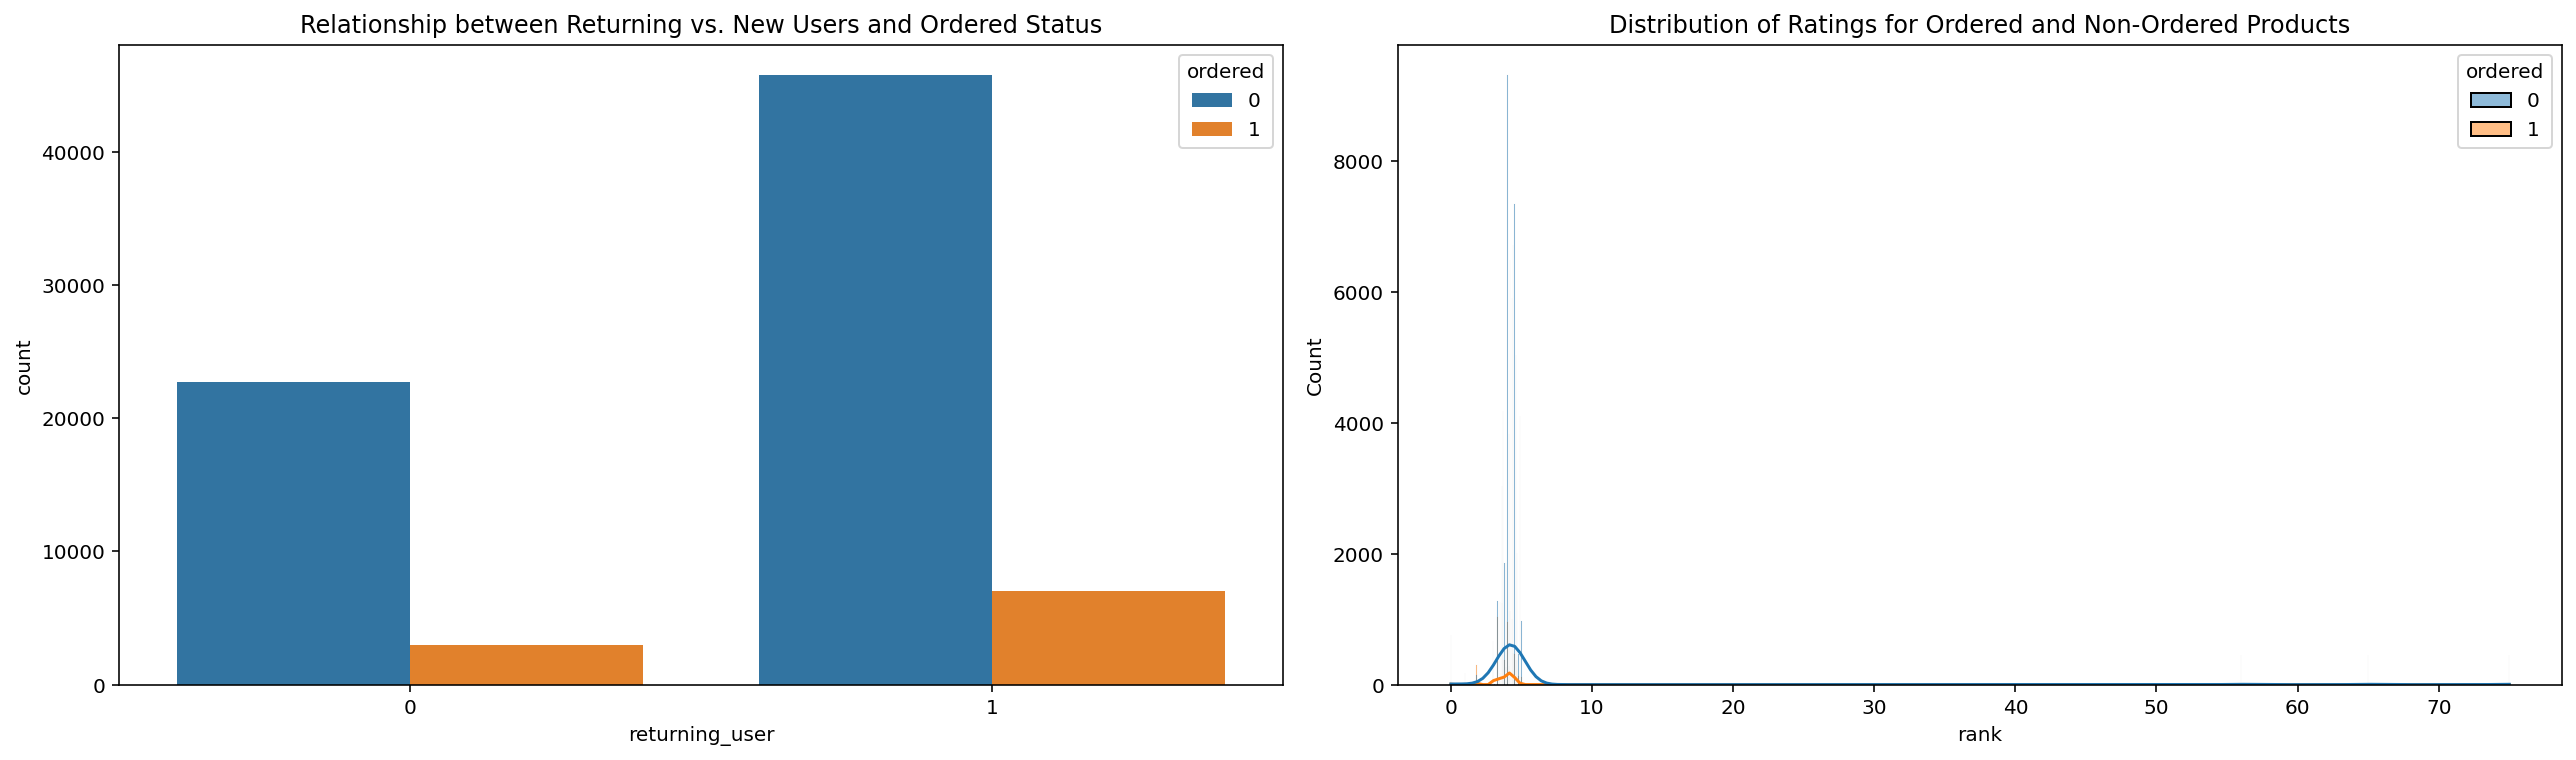

In [219]:
plt.figure(figsize=(18, 10))

# relationship between returning vs. new users and ordered status
plt.subplot(2, 2, 1)
sns.countplot(data=balanced_df, x='returning_user', hue='ordered')
plt.title('Relationship between Returning vs. New Users and Ordered Status')

# distribution of ratings for ordered and non-ordered products
plt.subplot(2, 2, 2)
sns.histplot(data=balanced_df, x='rank', hue='ordered', kde=True)
plt.title('Distribution of Ratings for Ordered and Non-Ordered Products')

plt.tight_layout()
plt.show()

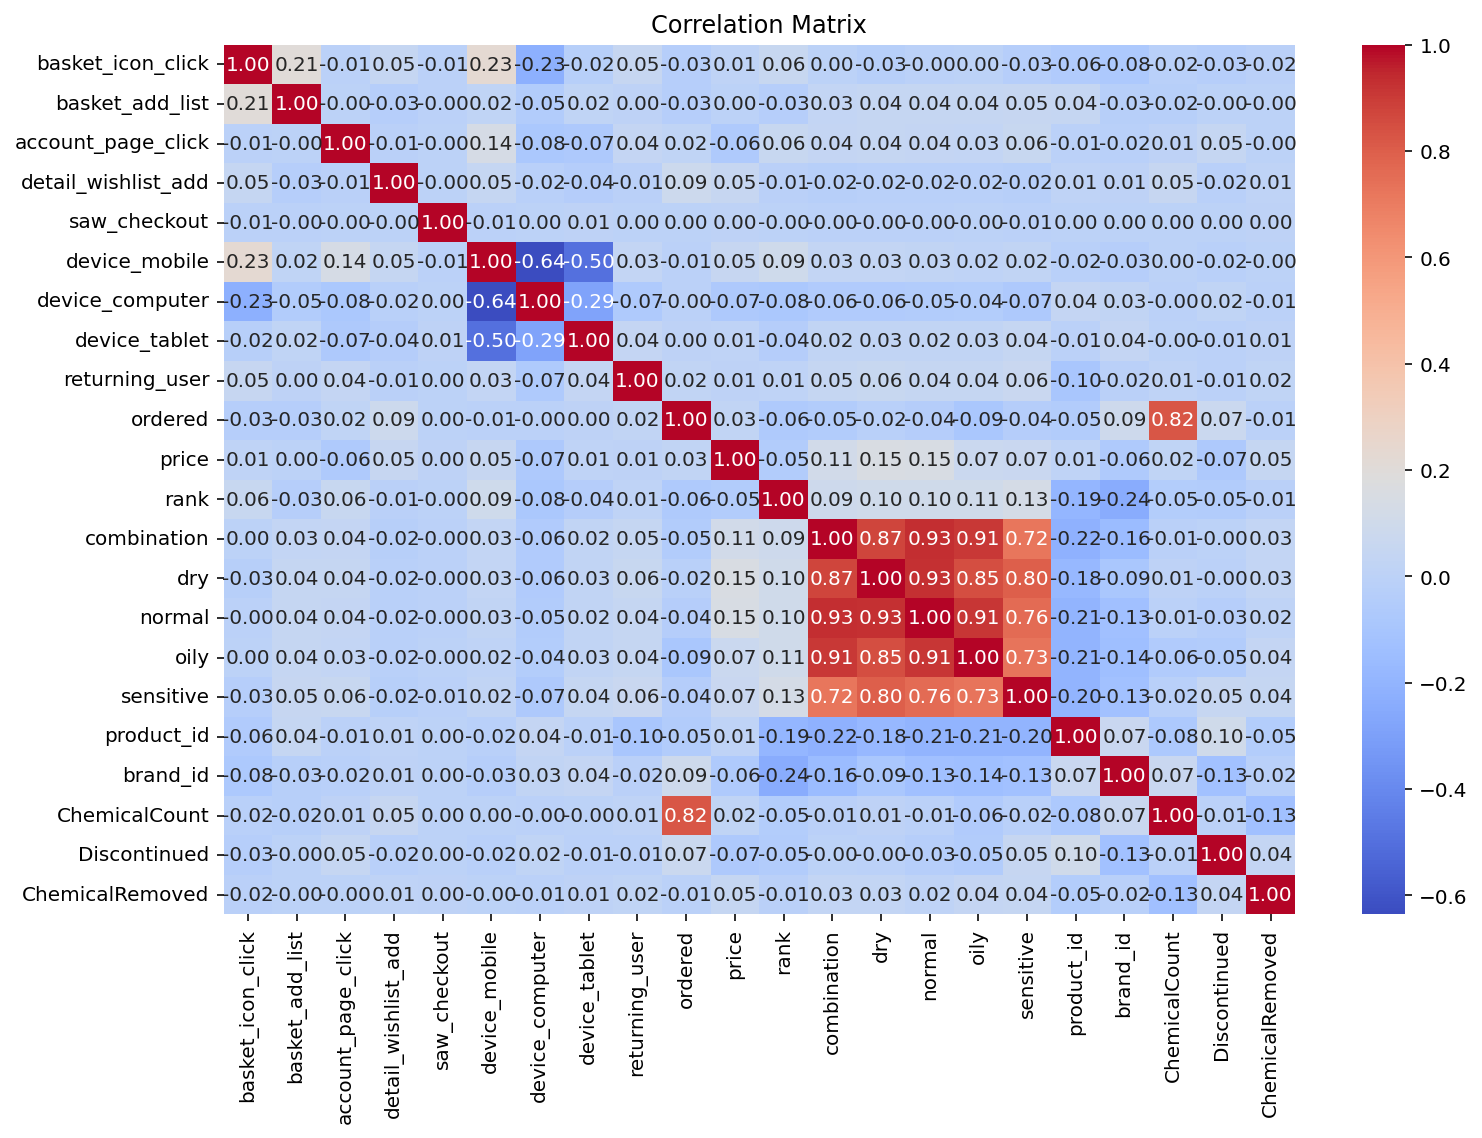

In [220]:
correlation_matrix = balanced_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

### Data Scrubbing 

#### Data Consistency

In [221]:
# data consitency w/device columns 
inconsistent_records = balanced_df[(balanced_df['device_mobile'] + balanced_df['device_computer'] + balanced_df['device_tablet']) > 1]

In [222]:
# drop inconcistent records - rows where the sum of device columns is greater than 1 (1049 rows were picked up to have suplicate values)
inconsistent_records_index = (balanced_df['device_mobile'] + balanced_df['device_computer'] + balanced_df['device_tablet']) > 1
balanced_df.drop(inconsistent_records_index.index[inconsistent_records_index], inplace=True)

In [223]:
balanced_df.shape #shape after duplicate values were dropped 

(76701, 30)

#### Data Type Conversion 

In [224]:
balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76701 entries, 62854 to 56484
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   UserID               76701 non-null  object 
 1   basket_icon_click    76701 non-null  int64  
 2   basket_add_list      76701 non-null  int64  
 3   account_page_click   76701 non-null  int64  
 4   detail_wishlist_add  76701 non-null  int64  
 5   saw_checkout         76701 non-null  int64  
 6   device_mobile        76701 non-null  int64  
 7   device_computer      76701 non-null  int64  
 8   device_tablet        76701 non-null  int64  
 9   returning_user       76701 non-null  int64  
 10  ordered              76701 non-null  int64  
 11  label                76701 non-null  object 
 12  brand                76701 non-null  object 
 13  name                 76701 non-null  object 
 14  price                76701 non-null  float64
 15  rank                 76701 non-n

In [225]:
# convert Rank, Discontinued, and ChemicalRemoved, Dry to integer type
balanced_df['rank'] = balanced_df['rank'].astype(int)
balanced_df['Discontinued'] = balanced_df['Discontinued'].astype(int)
balanced_df['ChemicalRemoved'] = balanced_df['ChemicalRemoved'].astype(int)
balanced_df['dry'] = balanced_df['dry'].astype(int)

#### Outlier Detection 

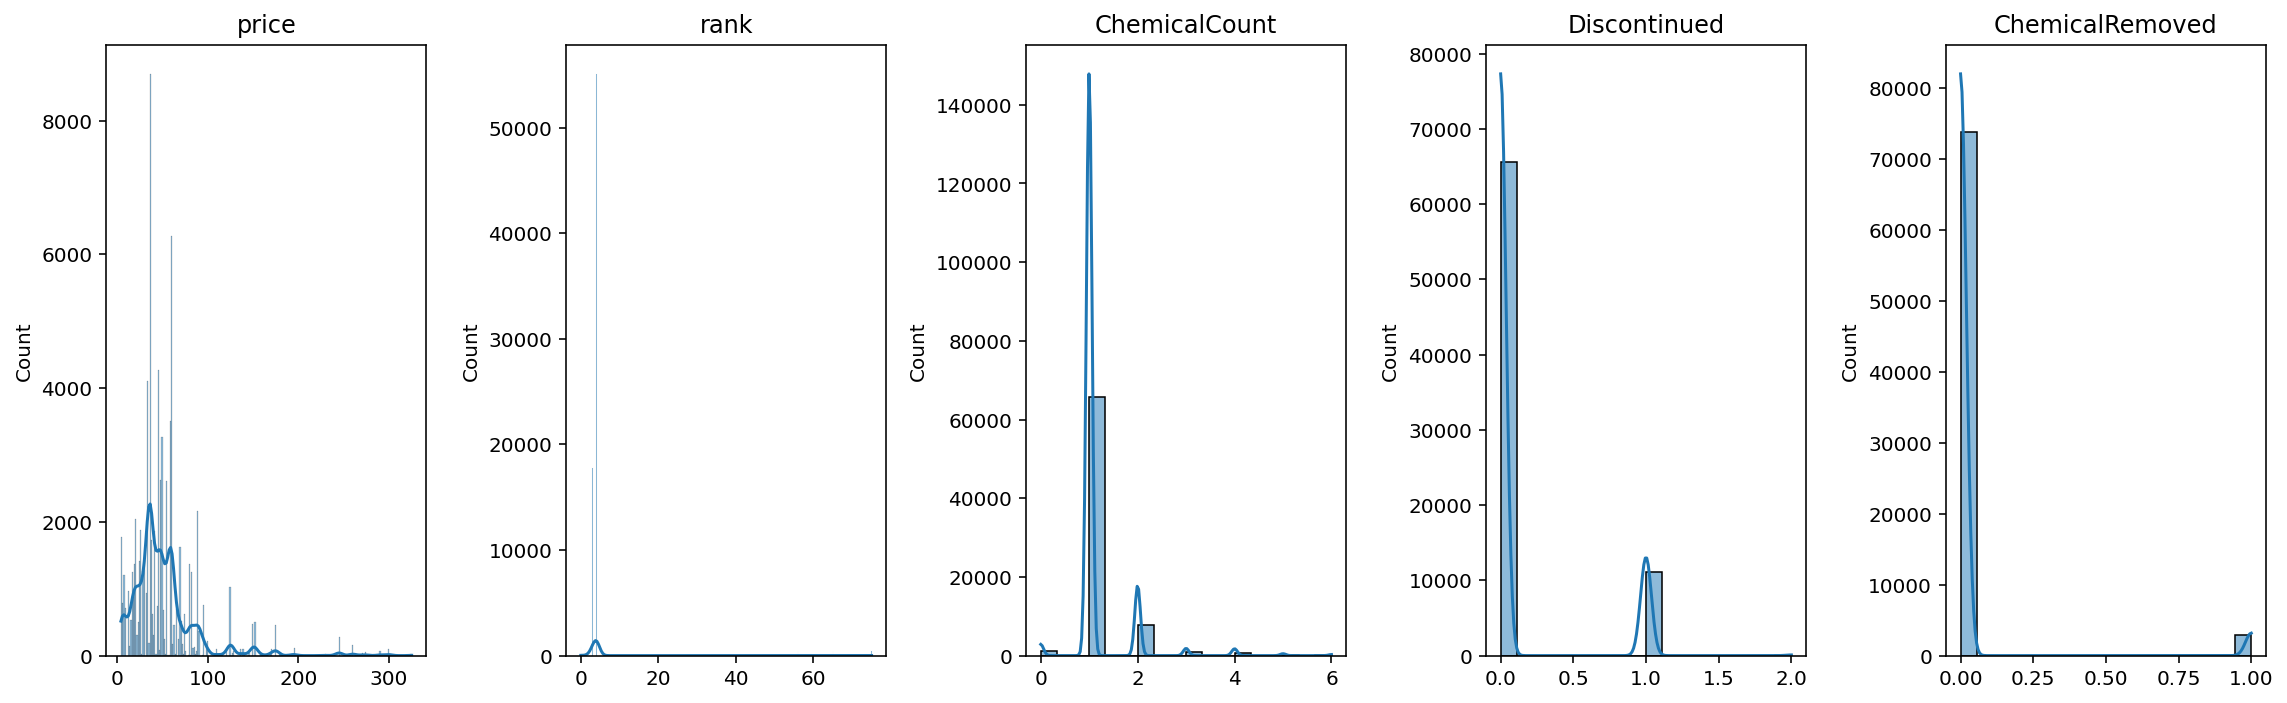

In [226]:
# visulaize potential outliers 
def visualize_distribution(balanced_df, columns):
    fig, axes = plt.subplots(nrows=1, ncols=len(columns), figsize=(16, 5))
    for i, col in enumerate(columns):
        sns.histplot(balanced_df[col], ax=axes[i], kde=True)
        axes[i].set_title(col)
        axes[i].set_xlabel('')
    plt.tight_layout()
    plt.show()

# define numerical columns for visualization
numerical_columns = ['price', 'rank', 'ChemicalCount', 'Discontinued', 'ChemicalRemoved']
visualize_distribution(balanced_df, numerical_columns)

In [227]:
 balanced_df[numerical_columns].describe() #outliers will remain in the df 

,price,rank,ChemicalCount,Discontinued,ChemicalRemoved
count,76701.000000,76701.000000,76701.000000,76701.000000,76701.000000
mean,50.596550,4.797317,1.156673,0.146556,0.037196
std,36.810045,8.202126,0.557657,0.356419,0.189244
min,4.000000,0.000000,0.000000,0.000000,0.000000
25%,32.000000,3.000000,1.000000,0.000000,0.000000
50%,45.000000,4.000000,1.000000,0.000000,0.000000
75%,60.000000,4.000000,1.000000,0.000000,0.000000
max,325.000000,75.000000,6.000000,2.000000,1.000000


In [228]:
balanced_df['ChemicalCount'].value_counts() # inspect chemical count distribution 

1    65623
2     7902
0     1264
3      810
4      769
5      213
6      120
Name: ChemicalCount, dtype: int64

#### Duplicate Values 

In [229]:
# check for duplicates
balanced_df.duplicated().sum() #original df is 52276 rows 

48318

In [230]:
duplicate_rows = balanced_df[balanced_df.duplicated()]
duplicate_rows.head()

,UserID,basket_icon_click,basket_add_list,account_page_click,detail_wishlist_add,saw_checkout,device_mobile,device_computer,device_tablet,returning_user,ordered,label,brand,name,price,rank,ingredients,combination,dry,normal,oily,sensitive,product_id,brand_id,PrimaryCategory,SubCategory,ChemicalName,ChemicalCount,Discontinued,ChemicalRemoved
51541,2a0c-9b78acd8-2a0c-4622-b29c-845917,1,0,0,0,0,0,0,1,1,0,Treatment,MURAD,Revitalixir™ Recovery Serum,89.0,4,Water- Glycerin- Propanediol- Prunus Armeniaca...,1.0,1,1,1,1,76,684,Skin Care Products,Skin Moisturizers (making a cosmetic claim),Vitamin A palmitate,1,0,0
15841,a84d-74970753-a84d-4171-9315-230746,0,0,0,0,0,1,0,0,1,0,Cleanser,CHARLOTTE TILBURY,Multi-Miracle Glow Cleansing Balm,60.0,4,Glycerin- Water- Caprylic/Capric Triglyceride-...,1.0,1,1,1,1,16,449,Sun-Related Products,Sunscreen (making a cosmetic claim),Titanium dioxide,1,0,0
23569,36b1-d678040b-36b1-481b-b8c8-197404,1,0,0,0,0,1,0,0,1,0,Cleanser,CHARLOTTE TILBURY,Multi-Miracle Glow Cleansing Balm,60.0,4,Glycerin- Water- Caprylic/Capric Triglyceride-...,1.0,1,1,1,1,16,449,Sun-Related Products,Sunscreen (making a cosmetic claim),Titanium dioxide,1,0,0
15800,a84d-74970753-a84d-4171-9315-230746,0,0,0,0,0,1,0,0,1,0,Cleanser,CHARLOTTE TILBURY,Multi-Miracle Glow Cleansing Balm,60.0,4,Glycerin- Water- Caprylic/Capric Triglyceride-...,1.0,1,1,1,1,16,449,Sun-Related Products,Sunscreen (making a cosmetic claim),Titanium dioxide,1,0,0
62885,6733-2b848d96-6733-b1cc-b581-717903,1,1,0,0,0,1,0,0,1,0,Cleanser,CHARLOTTE TILBURY,Multi-Miracle Glow Cleansing Balm,60.0,4,Glycerin- Water- Caprylic/Capric Triglyceride-...,1.0,1,1,1,1,16,449,Sun-Related Products,Sunscreen (making a cosmetic claim),Titanium dioxide,1,0,0


In [231]:
duplicate_rows['UserID'].value_counts() #UserID has duplicate values, rows will be dropped

925a-1cd99464-925a-4a33-aa27-430180    363
760c-b139c3av-760c-4c15-857b-121562    361
a9a8-1edddb36-a9a8-b199-a6b2-302492    360
dd97-62d093a5-dd97-417c-a569-580407    359
c7a1-a79c212a-c7a1-4287-9134-772713    358
7852-9973bc5a-7852-4a12-8230-22786     358
5977-375aba85-5977-41db-969b-262952    358
0270-6a05759b-0270-472d-a914-258777    358
c50c-04bd3a65-c50c-4b6a-845b-979809    358
4aa8-78365688-4aa8-4d7c-8772-772052    358
cd11-21c93d38-cd11-4526-8dba-416180    358
7ac9-73483b19-7ac9-41b1-b6b0-336714    354
784a-a3ava1e6-784a-463a-93cd-976746    333
945d-94c07370-945d-41e9-8d21-617160    331
5b67-1a961377-5b67-4d52-8501-147469    331
9776-a4c28abd-9776-47dc-8900-820197    331
2a0c-9b78acd8-2a0c-4622-b29c-845917    331
8464-c2718d1c-8464-4037-96d6-942562    330
63a0-d7d570d3-63a0-4a43-a814-762958    329
7243-934379d2-7243-4262-bc86-269679    328
7796-67258b67-7796-b1d9-81cb-688454    327
3a10-5cd576a0-3a10-4736-b01c-841276    271
5299-73ac797c-5299-4aa2-a253-312689    271
c06d-d141e7

In [232]:
# remove duplicate rows 
clean_df = balanced_df.drop_duplicates()
clean_df = clean_df.reset_index(drop=True)

In [233]:
# inspect df 
print('Number of Rows:', clean_df.shape[0])
print('Number of Columns:', clean_df.shape[1], '\n')

clean_df.info()

Number of Rows: 28383
Number of Columns: 30 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28383 entries, 0 to 28382
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   UserID               28383 non-null  object 
 1   basket_icon_click    28383 non-null  int64  
 2   basket_add_list      28383 non-null  int64  
 3   account_page_click   28383 non-null  int64  
 4   detail_wishlist_add  28383 non-null  int64  
 5   saw_checkout         28383 non-null  int64  
 6   device_mobile        28383 non-null  int64  
 7   device_computer      28383 non-null  int64  
 8   device_tablet        28383 non-null  int64  
 9   returning_user       28383 non-null  int64  
 10  ordered              28383 non-null  int64  
 11  label                28383 non-null  object 
 12  brand                28383 non-null  object 
 13  name                 28383 non-null  object 
 14  price                28383 non-null  flo

In [234]:
clean_df.head()

,UserID,basket_icon_click,basket_add_list,account_page_click,detail_wishlist_add,saw_checkout,device_mobile,device_computer,device_tablet,returning_user,ordered,label,brand,name,price,rank,ingredients,combination,dry,normal,oily,sensitive,product_id,brand_id,PrimaryCategory,SubCategory,ChemicalName,ChemicalCount,Discontinued,ChemicalRemoved
0,6733-2b848d96-6733-b1cc-b581-717903,1,1,0,0,0,1,0,0,1,0,Cleanser,CHARLOTTE TILBURY,Multi-Miracle Glow Cleansing Balm,60.0,4,Glycerin- Water- Caprylic/Capric Triglyceride-...,1.0,1,1,1,1,16,449,Sun-Related Products,Sunscreen (making a cosmetic claim),Titanium dioxide,1,0,0
1,2a0c-9b78acd8-2a0c-4622-b29c-845917,1,0,0,0,0,0,0,1,1,0,Treatment,MURAD,Revitalixir™ Recovery Serum,89.0,4,Water- Glycerin- Propanediol- Prunus Armeniaca...,1.0,1,1,1,1,76,684,Skin Care Products,Skin Moisturizers (making a cosmetic claim),Vitamin A palmitate,1,0,0
2,0960-58c6722a-0960-4ad4-9a3a-337319,1,0,0,0,0,1,0,0,1,0,Face Mask,LANEIGE,Lip Sleeping Mask,20.0,4,Diisostearyl Malate- Hydrogenated Polyisobuten...,0.0,0,0,0,0,67,834,Sun-Related Products,Sunscreen (making a cosmetic claim),Titanium dioxide,1,0,0
3,1b45-8b673a74-1b45-43av-88d1-476475,1,0,0,0,0,1,0,0,1,0,Moisturizer,PERRICONE MD,Vitamin C Ester Photo-Brightening Moisturizer ...,69.0,4,Water- Glycerin- Cyclopentasiloxane- Dimethico...,0.0,0,0,0,0,86,260,Skin Care Products,Facial Masks,Titanium dioxide,1,0,0
4,5099-9c7d2a36-5099-4c8a-8772-762243,0,0,0,0,0,1,0,0,0,0,Moisturizer,FARSÁLI,Rose Gold Elixir – 24k Gold Infused Beauty Oil,54.0,4,Rosa Rubiginosa (Rosehip) Seed Oil- Carthamus ...,0.0,0,0,0,0,36,70,Skin Care Products,Nighttime Skin Care,Titanium dioxide,1,1,0


### Feature Selection 

#### Chi-Square 

We will use chi-square to identify columns with high p-values and remove the redundant/irrelevant columns. 

In [235]:
# define target column to be analyzed for assocation 
target_column = 'ordered'

# create an empty array to store the results of chi-square test
chi_results = []

# iterate through all columns (excluding the target column)
for column in clean_df.columns:
    if column != target_column:
        # create a contingency table for the independent and target variable
        cross_tab = pd.crosstab(index=clean_df[column], columns=clean_df[target_column])
        # perform chi-square test
        chi2, p, dof, expected = chi2_contingency(cross_tab)
        # append results to the list
        chi_results.append({
            'Variable': column,
            'Chi-Square Value': chi2,
            'P-Value': p,
            'Degrees of Freedom': dof
        })


# display results in a df 
chi_df = pd.DataFrame(chi_results)
chi_df

,Variable,Chi-Square Value,P-Value,Degrees of Freedom
0,UserID,4092.551147,2.131997e-303,1230
1,basket_icon_click,3.531202,6.022412e-02,1
2,basket_add_list,2.933980,8.673343e-02,1
3,account_page_click,0.535132,4.644573e-01,1
4,detail_wishlist_add,36.858622,1.270132e-09,1
5,saw_checkout,3.313569,6.871010e-02,1
6,device_mobile,0.011984,9.128288e-01,1
7,device_computer,1.138406,2.859894e-01,1
8,device_tablet,1.941391,1.635176e-01,1
9,returning_user,0.073148,7.868073e-01,1


In [236]:
# drop redundant columns such as userid, product_id, and brand_id and those identified with non-signifcant p-values
clean_df.drop(['UserID', 'name', 'brand_id', 'PrimaryCategory', 'SubCategory', 'ingredients', 
               'basket_icon_click', 'basket_add_list', 'ChemicalRemoved', 'ChemicalCount'], axis=1, inplace=True)

In [237]:
clean_df.head(25)

,account_page_click,detail_wishlist_add,saw_checkout,device_mobile,device_computer,device_tablet,returning_user,ordered,label,brand,price,rank,combination,dry,normal,oily,sensitive,product_id,ChemicalName,Discontinued
0,0,0,0,1,0,0,1,0,Cleanser,CHARLOTTE TILBURY,60.0,4,1.0,1,1,1,1,16,Titanium dioxide,0
1,0,0,0,0,0,1,1,0,Treatment,MURAD,89.0,4,1.0,1,1,1,1,76,Vitamin A palmitate,0
2,0,0,0,1,0,0,1,0,Face Mask,LANEIGE,20.0,4,0.0,0,0,0,0,67,Titanium dioxide,0
3,0,0,0,1,0,0,1,0,Moisturizer,PERRICONE MD,69.0,4,0.0,0,0,0,0,86,Titanium dioxide,0
4,0,0,0,1,0,0,0,0,Moisturizer,FARSÁLI,54.0,4,0.0,0,0,0,0,36,Titanium dioxide,1
5,0,0,0,0,1,0,1,1,Treatment,BOSCIA,36.0,3,1.0,1,1,1,1,13,Titanium dioxide,1
6,0,0,0,0,0,1,0,0,Treatment,BOSCIA,36.0,3,1.0,1,1,1,1,13,Titanium dioxide,1
7,0,0,0,1,0,0,0,0,Face Mask,SEPHORA COLLECTION,6.0,4,0.0,0,0,0,0,93,Butylated hydroxyanisole,0
8,0,0,0,0,0,1,0,0,Face Mask,DR. JART+,7.0,4,1.0,1,1,1,1,28,Titanium dioxide,0
9,0,0,0,1,0,0,1,1,Face Mask,ORIGINS,7.0,4,1.0,1,1,1,1,84,Titanium dioxide,0


#### Variance Inflation Factor (VIF)

In [238]:
X_numeric = clean_df.select_dtypes(include=['float64', 'int64'])

# create a df for VIF values
vif = pd.DataFrame()
vif["Variable"] = X_numeric.columns

# calculate/store VIF values for each numeric variable
vif["VIF"] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]
print(vif)

               Variable        VIF
0    account_page_click   1.029768
1   detail_wishlist_add   1.008343
2          saw_checkout   1.000281
3         device_mobile   7.563466
4       device_computer   4.011514
5         device_tablet   3.037107
6        returning_user   1.011068
7               ordered   1.025987
8                 price   1.074259
9                  rank   1.027447
10          combination   6.053295
11                  dry   8.216699
12               normal  11.997687
13                 oily   5.080079
14            sensitive   2.622549
15           product_id   1.094734
16         Discontinued   1.028978


It's recommended to drop variables with high VIF values (>10) as they indicate significant multicollinearity. The following columns will be dropped: device_mobile, device_computer, device_tablet. 

In [239]:
# drop specified columns
clean_df.drop(['device_mobile', 'device_computer', 'device_tablet'], axis=1, inplace=True)

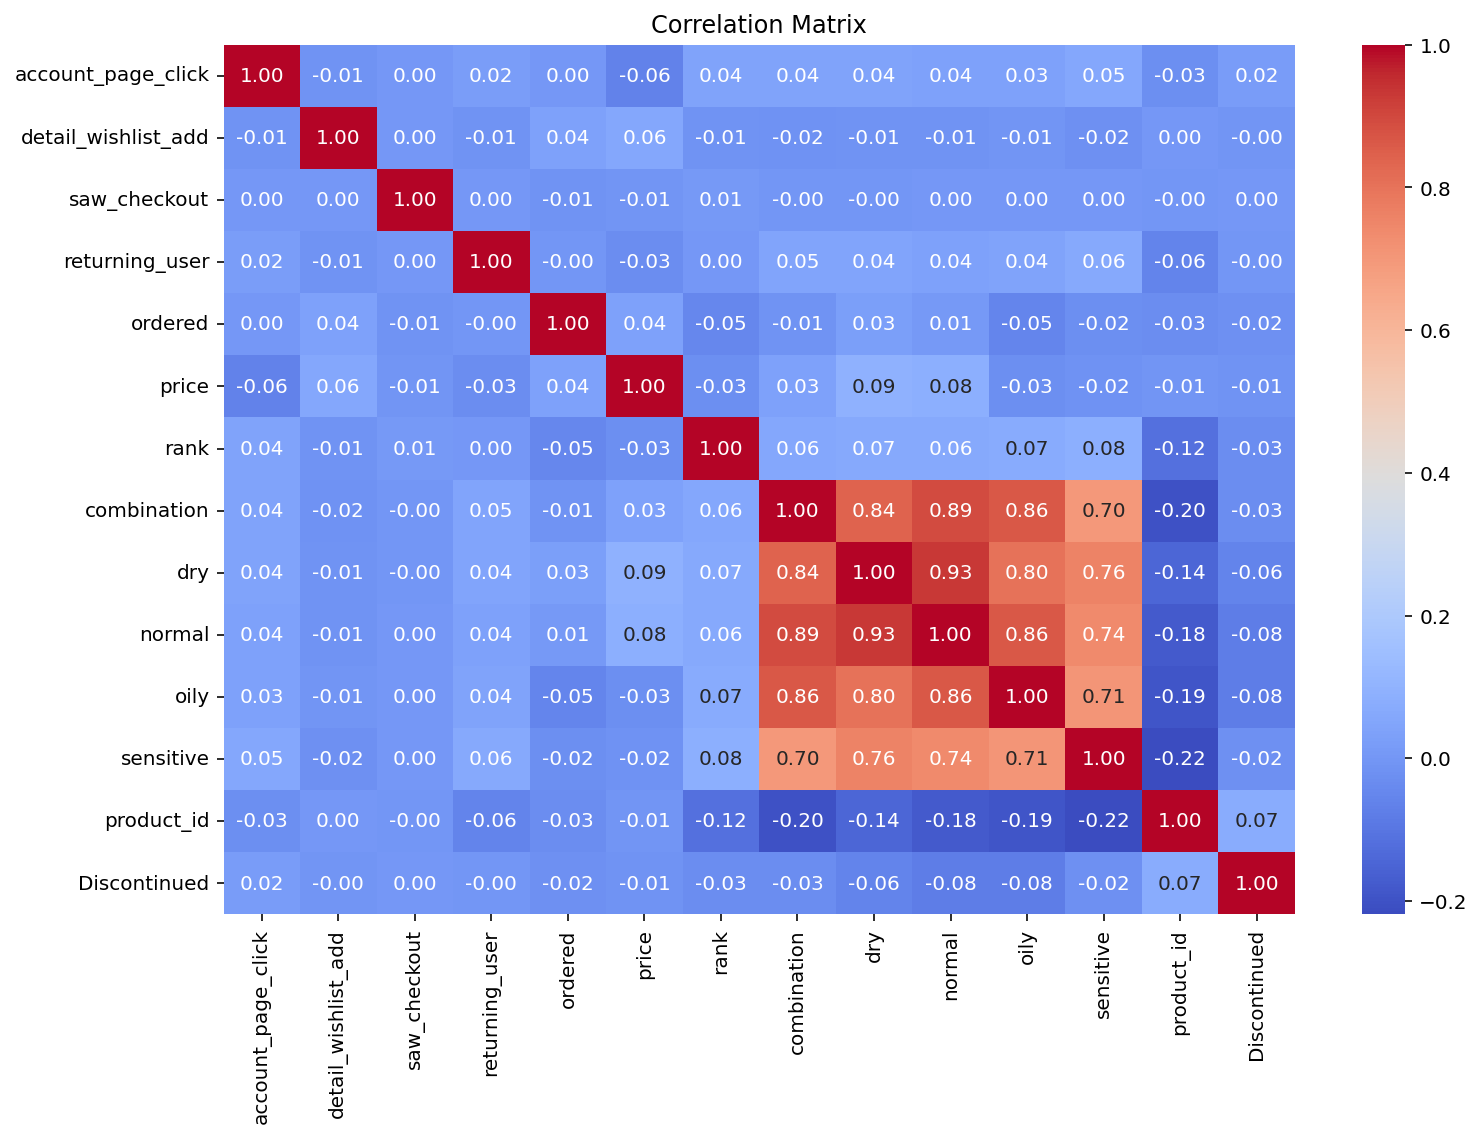

In [240]:
# create correlation matrix with reduced df 
correlation_matrix = clean_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [241]:
# correlation bewteen ordered and other variables 
ordered_correlation = correlation_matrix['ordered']
ordered_correlation

account_page_click     0.004639
detail_wishlist_add    0.036538
saw_checkout          -0.010895
returning_user        -0.001701
ordered                1.000000
price                  0.036052
rank                  -0.051961
combination           -0.012877
dry                    0.025184
normal                 0.008534
oily                  -0.053127
sensitive             -0.024930
product_id            -0.029324
Discontinued          -0.019924
Name: ordered, dtype: float64

#### Feature Transformation

In [242]:
# one hot encode categorical variables
cat_col = ["label", "brand", "ChemicalName", "rank"]
clean_df['ChemicalName'] = clean_df['ChemicalName'].str.replace('"', '')
encoded_df = pd.get_dummies(clean_df, columns=cat_col)

In [243]:
encoded_df.head()

,account_page_click,detail_wishlist_add,saw_checkout,returning_user,ordered,price,combination,dry,normal,oily,sensitive,product_id,Discontinued,label_Cleanser,label_Eye cream,label_Face Mask,label_Moisturizer,label_Sun protect,label_Treatment,brand_AMOREPACIFIC,brand_ANTHONY,brand_BAREMINERALS,brand_BEAUTYBIO,brand_BECCA,brand_BELIF,brand_BIOEFFECT,brand_BIOSSANCE,brand_BLACK UP,brand_BLITHE,brand_BOBBI BROWN,brand_BOSCIA,brand_CAUDALIE,brand_CHARLOTTE TILBURY,brand_CLARINS,brand_CLARISONIC,brand_CLINIQUE,brand_COOLA,brand_COVER FX,brand_DERMADOCTOR,brand_DIOR,brand_DR. BRANDT SKINCARE,brand_DR. DENNIS GROSS SKINCARE,brand_DR. JART+,brand_DRUNK ELEPHANT,brand_ERBORIAN,brand_ERNO LASZLO,brand_ESTÉE LAUDER,brand_EVE LOM,brand_FARMACY,brand_FARSÁLI,brand_FENTY BEAUTY BY RIHANNA,brand_FIRST AID BEAUTY,brand_FOREO,brand_FRESH,brand_GLAMGLOW,brand_GLOW RECIPE,brand_HERBIVORE,brand_HUM NUTRITION,brand_ILIA,brand_INDIE LEE,brand_IT COSMETICS,brand_J.ONE,brand_JACK BLACK,brand_JOSIE MARAN,brand_KATE SOMERVILLE,brand_KENZOKI,brand_KIEHL'S SINCE 1851,brand_KLORANE,brand_KOH GEN DO,brand_KORRES,brand_L'OCCITANE,brand_LA MER,brand_LANCER,brand_LANCÔME,brand_LANEIGE,brand_LAURA MERCIER,brand_LIGHTSTIM,brand_MAKE UP FOR EVER,brand_MDSOLARSCIENCES,brand_MILK MAKEUP,brand_MOROCCANOIL,brand_MURAD,brand_NARS,brand_NATURALLY SERIOUS,brand_NEOGEN DERMALOGY,brand_OLEHENRIKSEN,brand_OMOROVICZA,brand_ORIGINS,brand_PEACE OUT,brand_PERRICONE MD,brand_PETER THOMAS ROTH,brand_PHILOSOPHY,brand_PRIVATE DOCTOR,brand_REN CLEAN SKINCARE,brand_SAND & SKY,brand_SATURDAY SKIN,brand_SEPHORA COLLECTION,brand_SHISEIDO,brand_SK-II,brand_SKIN INC SUPPLEMENT BAR,brand_SKIN LAUNDRY,brand_SMASHBOX,brand_SON & PARK,brand_ST. TROPEZ TANNING ESSENTIALS,brand_SUNDAY RILEY,brand_SUPERGOOP!,brand_TARTE,brand_TATA HARPER,brand_TATCHA,brand_TOO COOL FOR SCHOOL,brand_URBAN DECAY,brand_VOLITION BEAUTY,brand_WANDER BEAUTY,brand_YOUTH TO THE PEOPLE,brand_YVES SAINT LAURENT,ChemicalName_2,ChemicalName_Acetaldehyde,ChemicalName_All-trans retinoic acid,ChemicalName_Aloe vera,ChemicalName_Arsenic (inorganic arsenic compounds),ChemicalName_Arsenic (inorganic oxides),ChemicalName_Aspirin,ChemicalName_Avobenzone,ChemicalName_Benz[a]anthracene,ChemicalName_Benzo[a]pyrene,ChemicalName_Benzophenone,ChemicalName_Benzophenone-3,ChemicalName_Butylated hydroxyanisole,ChemicalName_Cadmium and cadmium compounds,ChemicalName_Caffeic acid,ChemicalName_Caffeine,ChemicalName_Chromium (hexavalent compounds),ChemicalName_Cocamide DEA,ChemicalName_Cocamide MEA,ChemicalName_Cocamide diethanolamine,ChemicalName_Coffea arabica extract,ChemicalName_Coffee,ChemicalName_Coffee bean extract,ChemicalName_Cosmetic talc,ChemicalName_Dichloroacetic acid,ChemicalName_Diethanolamides of the fatty acids of coconut oil,ChemicalName_Diethanolamine,ChemicalName_Estragole,ChemicalName_Ethanol in alcoholic beverages,ChemicalName_Ethylene glycol,ChemicalName_Ethylene oxide,ChemicalName_Formaldehyde (gas),ChemicalName_Genistein (purified),ChemicalName_Ginkgo biloba extract,ChemicalName_Lead,ChemicalName_Mercury and mercury compounds,ChemicalName_Methanol,ChemicalName_Methyleugenol,ChemicalName_Mica,ChemicalName_Mineral oils,ChemicalName_Musk xylene,ChemicalName_Nickel (Metallic),ChemicalName_Oil Orange SS,ChemicalName_Phenacemide,ChemicalName_Progesterone,ChemicalName_Quartz,ChemicalName_Quinoline and its strong acid salts,ChemicalName_Retinol,ChemicalName_Retinyl acetate,ChemicalName_Retinyl palmitate,ChemicalName_Safrole,ChemicalName_Silica,ChemicalName_Spironolactone,ChemicalName_Styrene,ChemicalName_Talc,ChemicalName_Talc (powder),ChemicalName_Talc containing asbestiform fibers,ChemicalName_Titanium dioxide,ChemicalName_Titanium dioxide (airborne,ChemicalName_Toluene,ChemicalName_Trade Secret,ChemicalName_Triethanolamine,ChemicalName_Vitamin A,ChemicalName_Vitamin A palmitate,ChemicalName_beta-Myrcene,rank_0,rank_1,rank_2,rank_3,rank_4,rank_5,rank_56,rank_65,rank_75
0,0,0,0,1,0,60.0,1.0,1,1,1,1,16,0,1,0,0,0,0,0,0,0,0,0,0

In [244]:
encoded_df.shape

(28383, 189)

#### PCA

In [245]:
# create a copy of encoded_df before applying PCA 
pca_df = encoded_df.copy()

In [246]:
# standardize the data
scaler = StandardScaler()
# fit and transform data using scaler 
df_standardized = scaler.fit_transform(pca_df)

In [247]:
# apply PCA
pca = PCA()
pca.fit(df_standardized)

# calculate the cumulative explained variance ratio
explained_variance_ratio_cumulative = np.cumsum(pca.explained_variance_ratio_)

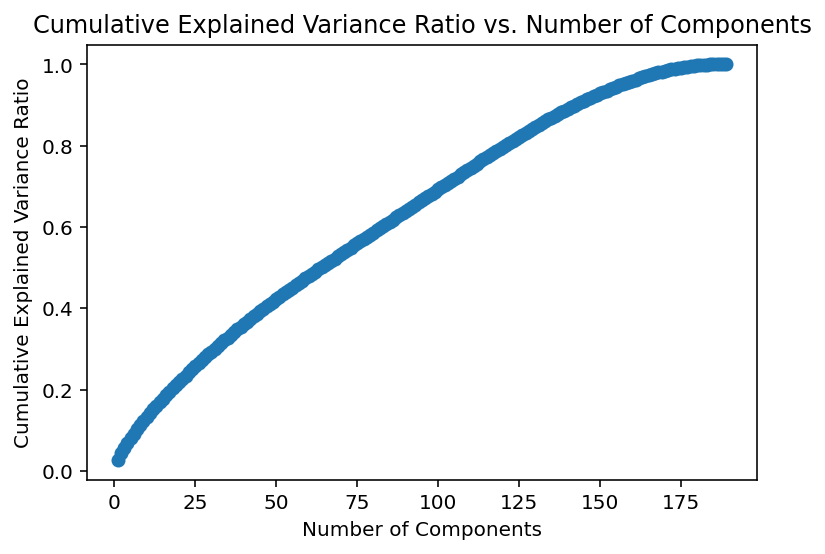

In [248]:
# plot cumulative explained variance ratio
plt.plot(range(1, len(explained_variance_ratio_cumulative) + 1), explained_variance_ratio_cumulative, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Components')
plt.show()

In [249]:
# find the number of components that fall within 80% to 90% cumulative explained variance
target_variance_range = (0.80, 0.90)

# use NumPy to find the index of the first component within the specified variance range
target_components = np.where((explained_variance_ratio_cumulative >= target_variance_range[0]) &
                             (explained_variance_ratio_cumulative <= target_variance_range[1]))[0][0] + 1

print("Ideal number of components within 80% to 90% variance range:", target_components)

Ideal number of components within 80% to 90% variance range: 121


In [250]:
# extract target variable
y = encoded_df['ordered']
X = encoded_df.drop(columns=['ordered'])

# standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# apply PCA
pca = PCA(n_components=97)  
X_pca = pca.fit_transform(X_scaled)

In [251]:
# concatenate transformed features with target variable
pca_df= pd.DataFrame(X_pca, columns=[f'pca_{i}' for i in range(X_pca.shape[1])])
pca_df['ordered'] = y.values

In [252]:
pca_df.head()

,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,pca_11,pca_12,pca_13,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19,pca_20,pca_21,pca_22,pca_23,pca_24,pca_25,pca_26,pca_27,pca_28,pca_29,pca_30,pca_31,pca_32,pca_33,pca_34,pca_35,pca_36,pca_37,pca_38,pca_39,pca_40,pca_41,pca_42,pca_43,pca_44,pca_45,pca_46,pca_47,pca_48,pca_49,pca_50,pca_51,pca_52,pca_53,pca_54,pca_55,pca_56,pca_57,pca_58,pca_59,pca_60,pca_61,pca_62,pca_63,pca_64,pca_65,pca_66,pca_67,pca_68,pca_69,pca_70,pca_71,pca_72,pca_73,pca_74,pca_75,pca_76,pca_77,pca_78,pca_79,pca_80,pca_81,pca_82,pca_83,pca_84,pca_85,pca_86,pca_87,pca_88,pca_89,pca_90,pca_91,pca_92,pca_93,pca_94,pca_95,pca_96,ordered
0,1.668132,-1.099662,-0.650838,-0.193357,2.518575,1.066486,-1.085536,0.590514,-0.153544,1.309162,-0.424184,0.114055,0.506228,-0.444449,-0.288358,0.558590,0.147231,0.602783,-0.382556,-0.792788,0.268173,-0.217205,0.239518,-0.455376,0.891547,0.620313,-0.426052,-0.643272,-0.425186,0.320385,-0.505654,-0.183309,0.131966,-0.449103,-0.651435,-0.555400,0.656135,-0.501573,0.336514,1.261023,-0.486875,-0.661772,-0.450338,0.564470,-1.557803,0.491401,-0.478948,-0.343979,-0.162795,-1.194846,0.430957,-1.399637,1.271309,-0.386728,0.486476,-1.163649,1.261662,-1.373546,-1.888943,-0.625363,-1.154774,0.490411,1.073131,1.843711,2.405495,-0.160896,-1.103616,1.934472,-1.436279,0.621835,0.000688,-0.275943,-1.454833,-0.623927,-0.774264,-1.146060,0.691857,-1.465830,0.531679,-1.072312,-0.589338,-0.783170,0.195395,-1.013746,0.804965,0.851233,0.584256,-0.793443,-0.589881,-0.359373,0.820868,0.108666,0.000553,-1.004983,0.693334,-1.083194,0.815744,0
1,1.675483,-0.861120,0.835062,0.408659,-0.158718,-1.022228,1.907662,1.801746,0.195414,-0.771922,1.084466,-0.338429,0.380682,-1.389821,0.812922,-0.035632,0.387386,-0.262746,0.323975,-0.226746,0.594469,0.293875,-1.186945,-0.912320,0.065274,0.770001,0.964687,0.453389,0.581880,-1.207807,1.627436,0.817623,-1.486363,-0.273389,0.221720,-1.171349,-1.167287,-0.747834,-1.272976,0.275151,-1.240008,-1.307099,1.025341,-0.728214,1.408919,-0.205020,-1.091313,0.395061,-0.139780,1.126260,-0.709774,0.225254,1.148962,0.534173,-0.389768,0.043351,0.539340,-0.669950,-0.083036,0.041891,0.159367,0.527892,0.200862,0.062989,-0.338128,-0.075555,-0.192525,0.074564,0.076809,-0.034269,-0.138655,0.009342,0.120274,0.041097,0.008687,-0.187154,0.010936,0.016440,-0.107293,0.153426,-0.185414,0.059788,-0.464275,0.305442,-0.001965,0.251656,-0.670916,-0.042589,-0.744178,-0.194513,0.252634,-0.341054,0.268180,-0.215852,0.520758,0.336503,0.343358,0
2,-3.255672,-1.265862,-1.287811,0.230574,-1.080095,-0.897068,-0.096857,-0.214111,-0.554677,0.410760,-0.746744,0.698250,0.599984,0.317632,-0.542798,0.363220,0.427905,-0.387078,-1.437642,-1.693948,-0.100128,-1.808510,-0.741660,2.615100,-0.368539,-1.163227,-0.048847,0.688070,-0.063578,-1.621778,-0.496127,1.844278,1.090311,1.423402,-1.446536,-0.241319,-0.294175,0.273206,-0.390438,-1.774180,0.934931,-0.262498,-0.681058,-2.002756,-1.942372,0.693165,-0.669534,0.276587,-0.300382,-0.191791,-0.464799,-0.527847,-1.229952,0.469145,0.749166,-0.601677,0.849117,-0.581260,-0.046792,0.483695,0.858584,-0.663956,0.102892,0.292104,-1.097069,-0.286462,-0.905081,-0.121112,-0.915061,-0.586891,0.037633,0.684137,0.041826,-0.107283,-0.040448,0.069075,-0.276025,0.042350,-0.566350,-0.524608,-0.291092,-0.572966,0.359561,0.083207,-0.202412,-0.110523,0.009411,0.090156,-0.206467,0.302672,0.334774,-0.001201,0.388790,-0.247532,-0.558533,-0.172906,-0.033252,0
3,-2.580228,-1.338626,1.750810,-0.466623,-0.158201,1.181969,0.260873,-0.453221,-0.686629,-0.200845,0.207147,0.542903,-0.231822,-0.635057,0.356981,-1.272551,1.529029,0.231525,0.049725,-1.474376,-0.557757,-0.499172,-0.762853,1.063919,-2.074685,-0.521759,-0.372811,-1.611350,-0.536873,1.010993,0.484563,0.342345,-0.146653,-1.146081,0.316382,0.057129,-0.278256,-0.498656,-0.021194,0.487330,-0.071157,0.623801,0.701181,0.310226,0.107133,-0.042795,-0.271566,-0.500319,0.149772,-0.122322,0.108742,0.467154,0.262308,-0.368903,-0.201239,-0.

### Test, Validation, Train Split

In [253]:
# split 90% modeling and 10 % holdout for prediction
df_train, df_holdout= train_test_split(pca_df, test_size=0.10, train_size=0.90, stratify=pca_df['ordered'])

# split the 5% into half for validation and half for testing
df_val, df_test = train_test_split(df_holdout, test_size=0.5, train_size=0.5, stratify=df_holdout['ordered'])

In [254]:
df_train.shape

(25544, 98)

In [255]:
df_val.shape

(1419, 98)

In [256]:
df_test.shape

(1420, 98)

### Transfer Data to S3 Bucket

In [257]:
# upload transformed data
# save DataFrame to a CSV file
pca_df.to_csv('sc_data.csv', index=False)

# upload file to S3 bucket
s3 = boto3.client('s3')
s3.upload_file('sc_data.csv', bucket, 'clean-data/sc_data.csv')

In [258]:
# upload train data
# save DataFrame to a CSV file
df_train.to_csv('train_data.csv', index=False)

# upload file to S3 bucket
s3 = boto3.client('s3')
s3.upload_file('train_data.csv', bucket, 'train-data/train_data.csv')

In [259]:
# upload validation data
# save DataFrame to a CSV file
df_val.to_csv('validation_data.csv', index=False)

# upload file to S3 bucket
s3 = boto3.client('s3')
s3.upload_file('validation_data.csv', bucket, 'validation-data/validation_data.csv')

In [260]:
# upload test data
# save DataFrame to a CSV file
df_test.to_csv('test_data.csv', index=False)

# upload file to S3 bucket
s3 = boto3.client('s3')
s3.upload_file('test_data.csv', bucket, 'test-data/test_data.csv')

### Modeling

In [261]:
!pip install -q autogluon
from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.tabular import TabularDataset, TabularPredictor
from tabulate import tabulate

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 5.1.5 requires pyqt5<5.13, which is not installed.
spyder 5.1.5 requires pyqtwebengine<5.13, which is not installed.
aiobotocore 2.12.3 requires botocore<1.34.70,>=1.34.41, but you have botocore 1.33.13 which is incompatible.
autovizwidget 0.21.0 requires pandas<2.0.0,>=0.20.1, but you have pandas 2.0.3 which is incompatible.
awscli 1.31.9 requires botocore==1.33.9, but you have botocore 1.33.13 which is incompatible.
hdijupyterutils 0.21.0 requires pandas<2.0.0,>=0.

In [262]:
# specify locations for train and test data
data_root = 's3://sc-cosmetics/'
train_data = TabularDataset(data_root + 'train-data/train_data.csv')
test_data = TabularDataset(data_root + 'test-data/test_data.csv')
model_directory = 's3://sc-cosmetics/autogloun-models' 

# fit models
predictor = TabularPredictor(label='ordered', path=model_directory).fit(train_data=train_data, verbosity=2)

# predictions for the best model
predictions = predictor.predict(test_data)

No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
save object to s3://sc-cosmetics/autogloun-models/learner.pkl
save object to s3://sc-cosmetics/autogloun-models/predictor.pkl
Beginning AutoGluon training ...
AutoGluon will save models to "s3://sc-cosmetics/autogloun-models"
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.8.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sa

The best model is WeightedEnsemble_L2. 

In [263]:
%store predictions

Stored 'predictions' (Series)


In [264]:
# get information about the models used in the predictor
predictor.leaderboard(test_data)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,NeuralNetTorch,0.900000,0.9164,accuracy,0.182770,0.116948,48.892430,0.182770,0.116948,48.892430,1,True,10
1,WeightedEnsemble_L2,0.899296,0.9168,accuracy,0.342189,0.130674,51.803382,0.084114,0.004940,1.651007,2,True,11
2,CatBoost,0.897183,0.9100,accuracy,0.240551,0.016475,22.560089,0.240551,0.016475,22.560089,1,True,7
3,ExtraTreesEntr,0.894366,0.9096,accuracy,0.530822,0.201677,6.337123,0.530822,0.201677,6.337123,1,True,9
4,ExtraTreesGini,0.894366,0.9092,accuracy,0.724212,0.244024,7.914840,0.724212,0.244024,7.914840,1,True,8
5,RandomForestEntr,0.893662,0.9104,accuracy,0.846678,0.162178,36.328590,0.846678,0.162178,36.328590,1,True,6
6,RandomForestGini,0.892958,0.9100,accuracy,0.743901,0.183082,38.059432,0.743901,0.183082,38.059432,1,True,5
7,KNeighborsDist,0.890141,0.8980,accuracy,0.814026,0.675038,0.143452,0.814026,0.675038,0.143452,1,True,2
8,KNeighborsUnif,0.888028,0.8976,accuracy,0.744748,1.243492,4.917058,0.744748,1.243492,4.917058,1,True,1
9,LightGBM,0.808451,0.8088,accuracy,0.075305,0.008786,1.259945,0.075305,0.008786,1.259945,1,True,4


In [265]:
# define predictor path 
local_model_directory = predictor.path 

In [266]:
%store local_model_directory

Stored 'local_model_directory' (str)


In [267]:
# load predictor to specified path 
predictor = TabularPredictor.load(predictor.path)
predictor 

In [268]:
# filter for top model (WeightedEnsemble_L2)
leaderboard = predictor.leaderboard(extra_info=True)
weighted_ensemble_row = leaderboard[leaderboard['model'] == 'WeightedEnsemble_L2']

# extract hyperparameters 
we2_hyperparameters = weighted_ensemble_row['hyperparameters'].iloc[0]

# print hyperparameters
print("Hyperparameters of WeightedEnsemble_L2 model:")
print(we2_hyperparameters)

Hyperparameters of WeightedEnsemble_L2 model:
{'use_orig_features': False, 'max_base_models': 25, 'max_base_models_per_type': 5, 'save_bag_folds': True}


S3 URI to AutoGloun models in S3: s3://sc-cosmetics/autogluon-models/

S3 URI to AutoML models created in SagemakerStudio stored in S3: s3://sc-cosmetics/automl/automl-sc-cosmetics/

### Performance Metrics

In [269]:
# compute performance metrics
performance = predictor.evaluate(test_data)
performance['ROC AUC'] = performance.pop('roc_auc') # add AUC ROC score

# print the performance metrics
df_performance = pd.DataFrame.from_dict(performance, orient='index', columns=['Value'])

# convert into tabular format
print(tabulate(df_performance, headers='keys', tablefmt='pipe'))

|                   |    Value |
|:------------------|---------:|
| accuracy          | 0.899296 |
| balanced_accuracy | 0.780616 |
| mcc               | 0.647299 |
| f1                | 0.691145 |
| precision         | 0.837696 |
| recall            | 0.588235 |
| ROC AUC           | 0.958598 |


#### Confusion Matrix 

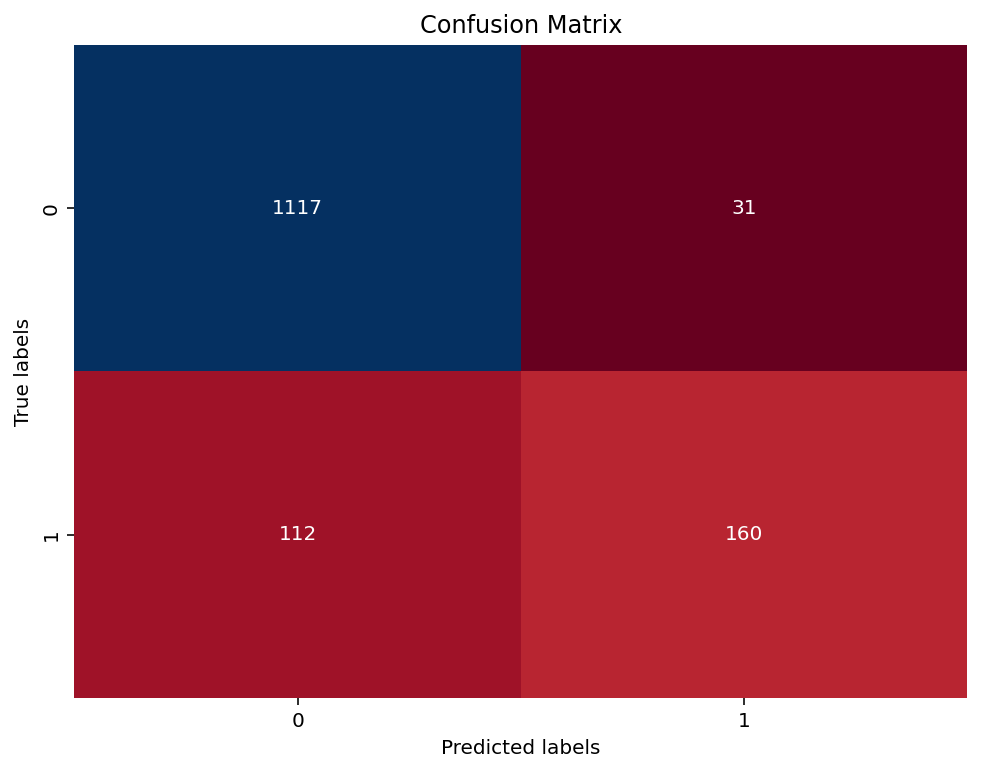

In [270]:
# confusion matrix
conf_matrix = confusion_matrix(test_data['ordered'], predictions)

# plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap = 'RdBu', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

#### ROC Curve AUC 

In [271]:
# get predictions
y_probs = predictor.predict_proba(test_data)[1] 
y_true = test_data['ordered'].values

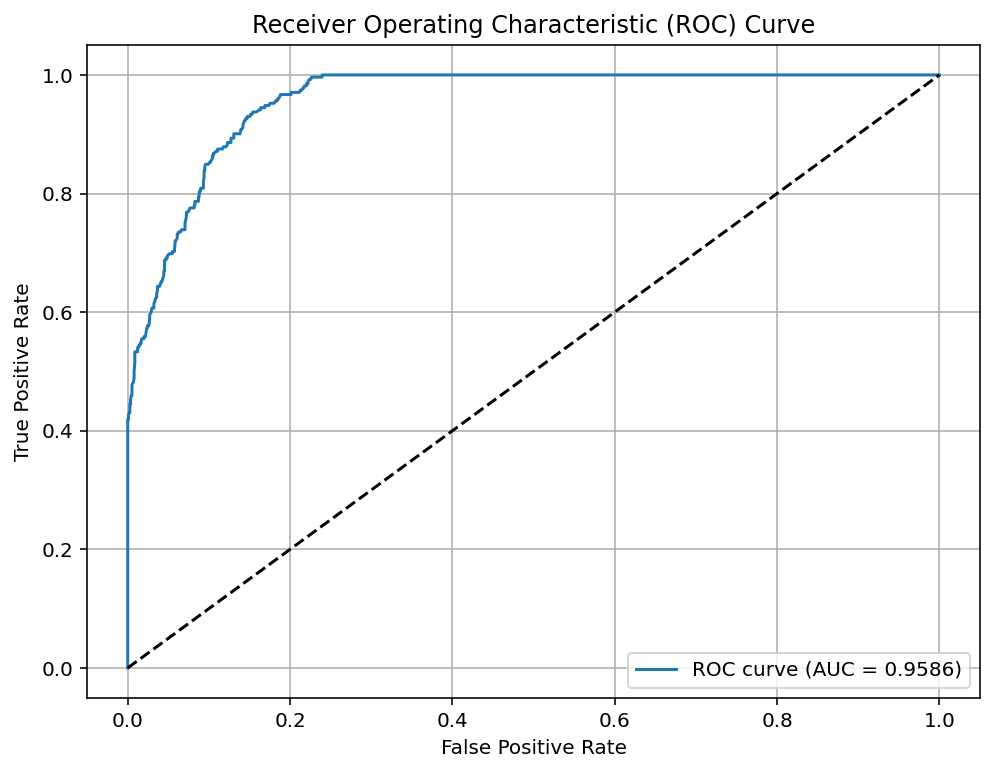

In [272]:
# compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
auc_score = roc_auc_score(y_true, y_probs)

# plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.4f})'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()

#### Precision Recall Curve

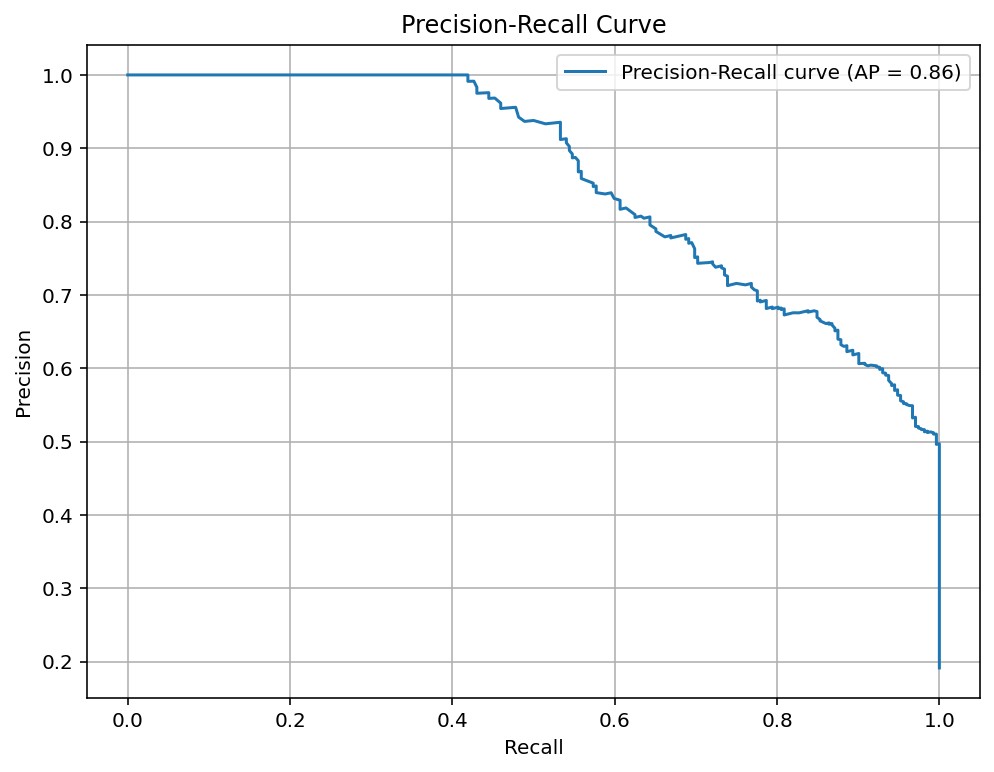

In [273]:
# precision recall curve
precision, recall, _ = precision_recall_curve(y_true, y_probs)
average_precision = average_precision_score(y_true, y_probs)

# plot precision recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

#### Gain Curve

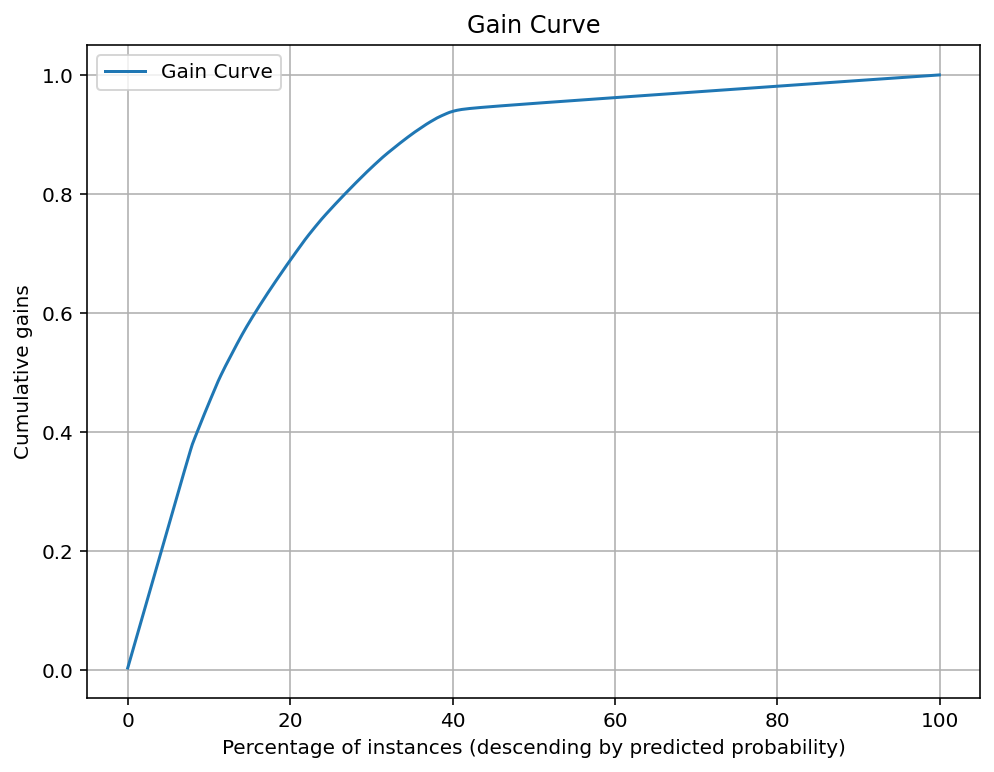

In [274]:
# gain curve
gains = np.cumsum(np.sort(y_probs)[::-1]) / np.sum(y_probs)
percentile = np.arange(0, len(gains)) / len(gains) * 100

# plot gain curve
plt.figure(figsize=(8, 6))
plt.plot(percentile, gains, label='Gain Curve')
plt.xlabel('Percentage of instances (descending by predicted probability)')
plt.ylabel('Cumulative gains')
plt.title('Gain Curve')
plt.legend()
plt.grid(True)
plt.show()